# 📓 Gemini Multimodal Supervised Fine‑Tuning — *RecipeBuilder*

**Last generated:** 2025-09-28 01:42 UTC

This notebook prepares a multimodal supervised fine‑tuning dataset from your Google Drive folders and Google Sheet,
then tunes a Gemini model on Vertex AI to predict **volume (cm³)** and **weight (g)** from an **image + label + width/height (inches)**.

It follows a cookbook style similar to your `RecipeBuilder_FT_Cookbook_SEPARATED`:
- Clearly labeled sections
- Run‑All friendly with a single configuration cell
- Rich inline comments & sanity checks
- JSONL dataset generation for *image tuning*
- Vertex AI SFT (Supervised Fine‑Tuning) job creation & polling
- Inference helpers for the tuned model

> **Important folder notes you mentioned**
> - Your class folders live under: `https://drive.google.com/drive/u/0/folders/1xV0uVBjCTJMD2ATbLniM062Fbs2efEtn` (referred here as **IMAGES_DRIVE_ROOT_ID**).
> - Inside each class (e.g., `Apple/ apple_1`), **images live in** a `*.tensorflow/train/` folder .
> - Your spreadsheet: `https://docs.google.com/spreadsheets/d/1A-kOYpyKQchIti6jTjT_1TrdxIAw2Pb5ozFg9TibL-8/edit?gid=1081451428#gid=1081451428`
>   - First column `main` → labels (`apple`, `banana`, `avocado`, ...)
>   - Second column `directory` → e.g. `apple_1`
>   - Third column `subimage` → filename (e.g. `0_jpg.rf....jpg`)
>   - Columns **I** and **J** contain **width_in** and **height_in** (inches).

> **What the model learns**
> We *don't* provide density as an input; instead, the tuned model will implicitly learn density from label patterns.
> Targets are computed with simple shape heuristics + a tunable density lookup (you can edit it in one place).

> **Tip**
> Run this in **Colab** or **Vertex AI Workbench**. Make sure your GCP project has Vertex AI enabled and you have a GCS bucket.


## 0) 🔧 One‑cell configuration (edit and Run)

Set your project, region, bucket, and how to find your data. If you know the *mounted* Drive path to
`1xV0uVBjCTJMD2ATbLniM062Fbs2efEtn`, set `DATASET_LOCAL_ROOT` (fast, no Drive API).
Otherwise, leave it `None` and the code will traverse by **names** under the Drive mount using a robust glob.


In [ ]:
#@title Find DATASET_LOCAL_ROOT from your Drive folder ID (fixed: no includeItemsFromAllDrives on get)
FOLDER_ID = "1xV0uVBjCTJMD2ATbLniM062Fbs2efEtn"  # your images root id

# Ensure you're authenticated & Drive is mounted (no-op if already done)
try:
    from google.colab import auth as colab_auth
    colab_auth.authenticate_user()
except Exception:
    pass

try:
    from google.colab import drive
    drive.mount("/content/drive")
except Exception:
    pass

# Build Drive API client with user creds
import google.auth
from google.auth.transport.requests import Request
from googleapiclient.discovery import build

SCOPES = ["https://www.googleapis.com/auth/drive.readonly"]

def get_user_creds(scopes):
    creds, _ = google.auth.default(scopes=scopes)
    if hasattr(creds, "with_scopes") and getattr(creds, "requires_scopes", False):
        creds = creds.with_scopes(scopes)
    if not creds.valid:
        creds.refresh(Request())
    return creds

creds = get_user_creds(SCOPES)
svc = build("drive", "v3", credentials=creds, cache_discovery=False)

def get_file(file_id, fields="id,name,mimeType,parents"):
    # NOTE: only supportsAllDrives is valid for get()
    return svc.files().get(
        fileId=file_id,
        fields=fields,
        supportsAllDrives=True
    ).execute()

# Walk up parents to reconstruct the name trail
folder = get_file(FOLDER_ID)
if folder.get("mimeType") != "application/vnd.google-apps.folder":
    raise ValueError("Provided ID is not a folder.")

names = [folder["name"]]
parents = folder.get("parents", [])
hops = 0
while parents and hops < 25:
    parent = get_file(parents[0])
    names.append(parent["name"])
    parents = parent.get("parents", [])
    hops += 1

names = list(reversed(names))  # root..target
print("Drive ancestry (names):", " ⟶ ".join(names))

# Search for the terminal folder locally under MyDrive / Shareddrives
from pathlib import Path
terminal = names[-1]
roots = [Path("/content/drive/MyDrive"), Path("/content/drive/Shareddrives")]
candidates = []
for root in roots:
    try:
        for p in root.rglob(terminal):
            if p.is_dir():
                # Check expected pattern inside: *tensorflow*/train/*
                looks_ok = bool(list(p.rglob("*tensorflow*/train/*")))
                candidates.append((str(p), looks_ok))
    except Exception:
        pass

print("\nCandidate DATASET_LOCAL_ROOT paths:")
if not candidates:
    print("  (none found)")
    print("\nIf none found:")
    print("  • Add a shortcut of the folder to **My Drive** (so it appears under the mount), or")
    print("  • Skip local paths and use the Drive-API resolver I shared earlier (it works by folder ID).")
else:
    for path, ok in candidates:
        mark = "✅ has *tensorflow*/train files" if ok else "⚠️ could not confirm train files"
        print("  ", path, " ", mark)

print("\nIf a path above is correct, set:")
print('DATASET_LOCAL_ROOT = "<copy one path above>"')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive ancestry (names): RecipeBuilder ⟶ Data ⟶ MetaFood ⟶ roboflow

Candidate DATASET_LOCAL_ROOT paths:
  (none found)

If none found:
  • Add a shortcut of the folder to **My Drive** (so it appears under the mount), or
  • Skip local paths and use the Drive-API resolver I shared earlier (it works by folder ID).

If a path above is correct, set:
DATASET_LOCAL_ROOT = "<copy one path above>"


In [ ]:
from google.colab import userdata
try:
    from google.colab import userdata
    get_secret = userdata.get
except Exception:
    get_secret = os.getenv
#@title ✅ Project & data config
PROJECT_ID = get_secret("GOOGLE_CLOUD_PROJECT")
REGION   = get_secret("GOOGLE_DEFAULT_REGION")
BUCKET_URI  = get_secret("GOOGLE_DEFAULT_BUCKET")

# Data locations
SHEET_URL = "https://docs.google.com/spreadsheets/d/1A-kOYpyKQchIti6jTjT_1TrdxIAw2Pb5ozFg9TibL-8/edit?gid=1081451428#gid=1081451428"  #@param {type:"string"}
SHEET_GID = 1081451428  #@param {type:"number"}

# If you *know* the mounted path to the folder id 1xV0uVBjCTJMD2ATbLniM062Fbs2efEtn, set it here (recommended).
# Example: "/content/drive/MyDrive/recipebuilder/IMAGES_ROOT"
DATASET_LOCAL_ROOT = None  #@param {type:"string"}

# If leaving DATASET_LOCAL_ROOT=None, we will still search under the Drive mount using folder names.
IMAGES_DRIVE_ROOT_ID = "1xV0uVBjCTJMD2ATbLniM062Fbs2efEtn"  # known root id from your message

# Base model and tuning knobs
BASE_MODEL = "gemini-2.5-flash"  # e.g. "gemini-2.5-flash" or "gemini-2.5-pro"
EPOCH_COUNT = 2                  # int
LEARNING_RATE_MULTIPLIER = 1.0   # float
ADAPTER_SIZE = 4                 # int (allowed: 1, 4, 8, 16, 32)

# Densities (g/cm3). The model *learns* these patterns; we use them to compute targets.
# Values are reasonable starting points; tweak per your measurements.
DENSITY = {
    "apple": 0.80,
    "banana": 1.05,
    "avocado": 1.00,
}

# Shape rules per label (how we approximate volume from width & height in *cm*).
# Supported shapes: "ellipsoid", "banana_cylinder_2hemi", "sphere".
SHAPE_RULES = {
    "apple": {"shape": "ellipsoid", "a_from": "w/2", "b_from": "w/2", "c_from": "h/2", "scale": 1.0},
    "avocado": {"shape": "ellipsoid", "a_from": "w/2", "b_from": "0.75*w/2", "c_from": "h/2", "scale": 1.0},
    "banana": {"shape": "banana_cylinder_2hemi"},
}

from datetime import datetime as _dt
TUNED_MODEL_DISPLAY_NAME = f"recipebuilder-sft-{_dt.now().strftime('%Y%m%d-%H%M%S')}"

print("✔ Config loaded.")

✔ Config loaded.


## 1) 🧰 Install libraries

In [ ]:
#@title Install (Colab/Workbench)
!pip -q install --upgrade google-cloud-aiplatform google-genai gcsfs google-cloud-storage \
  pandas openpyxl gspread oauth2client pydrive2 tqdm

## 2) 🔐 Authenticate & init Vertex AI

In [ ]:
#@title Auth (Colab): Google account + Vertex init — robust
import os, re, math, json, hashlib, pathlib, glob, random, time, textwrap
from datetime import datetime
from typing import Dict, Any, Tuple

# 1) Colab account auth (no-op outside Colab)
try:
    from google.colab import auth as colab_auth
    colab_auth.authenticate_user()
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# 2) Helper to re-read secrets/env in case config cell wasn't executed yet
try:
    from google.colab import userdata
    _get = userdata.get
except Exception:
    _get = os.getenv

def _norm(s):
    if s is None:
        return ""
    return str(s).strip().strip('"').strip("'")

# Fill from globals or secrets/env; normalize and add gs:// if needed
def ensure_project_region_bucket():
    global PROJECT_ID, REGION, BUCKET_URI
    PROJECT_ID = _norm(globals().get("PROJECT_ID")) or _norm(_get("GOOGLE_CLOUD_PROJECT"))
    REGION     = _norm(globals().get("REGION"))     or _norm(_get("GOOGLE_DEFAULT_REGION")) or "us-central1"
    BUCKET_URI = _norm(globals().get("BUCKET_URI")) or _norm(_get("GOOGLE_DEFAULT_BUCKET"))
    if BUCKET_URI and not BUCKET_URI.startswith("gs://"):
        BUCKET_URI = f"gs://{BUCKET_URI}"

ensure_project_region_bucket()

# 3) Validate with clear guidance
def _fail(msg):
    raise AssertionError(
        msg +
        f"\n\nCurrent values:\n  PROJECT_ID={repr(globals().get('PROJECT_ID'))}\n"
        f"  REGION={repr(globals().get('REGION'))}\n"
        f"  BUCKET_URI={repr(globals().get('BUCKET_URI'))}\n"
        "How to fix:\n"
        "- In Colab: set 🔑 Variables GOOGLE_CLOUD_PROJECT, GOOGLE_DEFAULT_REGION, GOOGLE_DEFAULT_BUCKET.\n"
        "- Or export env vars before running: GOOGLE_CLOUD_PROJECT / GOOGLE_DEFAULT_REGION / GOOGLE_DEFAULT_BUCKET.\n"
        "- Bucket may be 'my-bucket' or 'gs://my-bucket'."
    )

if not PROJECT_ID:
    _fail("PROJECT_ID is empty.")
if not REGION:
    _fail("REGION is empty.")
if not BUCKET_URI or not BUCKET_URI.startswith("gs://"):
    _fail("BUCKET_URI is empty or missing 'gs://' prefix.")

print("Project:", PROJECT_ID)
print("Region :", REGION)
print("Bucket :", BUCKET_URI)

# 4) Init Vertex AI and ensure bucket exists
import vertexai
from google.cloud import storage

vertexai.init(project=PROJECT_ID, location=REGION)
print("✔ Vertex AI initialized.")

bucket_name = BUCKET_URI.replace("gs://","").split("/")[0]
storage_client = storage.Client(project=PROJECT_ID)

try:
    buckets = [b.name for b in storage_client.list_buckets()]
    if bucket_name not in buckets:
        print(f"Creating bucket {BUCKET_URI} in {REGION} ...")
        # If gcloud isn't available/authorized, this will print guidance.
        exit_code = os.system(
            f"gcloud storage buckets create {BUCKET_URI} "
            f"--project {PROJECT_ID} --location={REGION} --uniform-bucket-level-access"
        )
        if exit_code != 0:
            print("⚠️ Could not auto-create bucket via gcloud. Create it once from console or run the command above manually.")
    else:
        print("✔ Bucket exists:", bucket_name)
except Exception as e:
    print("⚠️ Bucket check/create skipped due to:", e)

# 5) Mount Drive (if in Colab)
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    print("✔ Drive mounted at /content/drive")


Project: recipebuilder-473405
Region : us-central1
Bucket : gs://recipebuilder-finetune
✔ Vertex AI initialized.
✔ Bucket exists: recipebuilder-finetune
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ Drive mounted at /content/drive


## 3) 📑 Load spreadsheet → canonical DataFrame

We normalize column names to:
- `main` (label), `directory`, `subimage`, `width_in`, `height_in`

If your sheet uses different headers, the mapping below will try to auto‑detect.


In [ ]:
#@title Read + Normalize (compact)
import pandas as pd, re, io, requests, google.auth
from google.auth.transport.requests import Request

# assumes SHEET_URL / SHEET_GID already set earlier

def _csv_url(u,gid):
    m = re.search(r"/spreadsheets/d/([^/]+)/", u); sid = m.group(1)
    return f"https://docs.google.com/spreadsheets/d/{sid}/export?format=csv&gid={gid}"

def _creds():
    c,_ = google.auth.default(scopes=[
        "https://www.googleapis.com/auth/spreadsheets.readonly",
        "https://www.googleapis.com/auth/drive.readonly",
    ])
    if not c.valid: c.refresh(Request())
    return c

def load_sheet(url, gid):
    r = requests.get(_csv_url(url, gid),
                     headers={"Authorization": f"Bearer {_creds().token}"},
                     timeout=60)
    r.raise_for_status()
    return pd.read_csv(io.BytesIO(r.content))

def canon(s): return re.sub(r"[ \t_\-\(\)]+","",str(s).strip().lower())

raw_df = load_sheet(SHEET_URL, SHEET_GID)

lk = {canon(c): c for c in raw_df.columns}
def pick(keys):
    K = [canon(k) for k in keys]
    for k in K:
        if k in lk: return lk[k]
    # last chance: direct compare against existing headers canon
    for col in raw_df.columns:
        if canon(col) in K: return col
    raise KeyError(f"need one of {keys}; have {list(raw_df.columns)}")

cols = dict(
    main      = pick(["main","label","class","category"]),
    directory = pick(["directory","dir","subdir","subset","folder"]),
    subimage  = pick(["subimage","sub-image","sub_image","sample image","sampleimage","image","filename","file"]),
    width_in  = pick(["width in inches","widthininches","widthinches","width_in_inches","width(inches)","w_in","width_in","widthin"]),
    height_in = pick(["height in inches","heightininches","heightinches","height_in_inches","height(inches)","h_in","height_in","heightin"]),
)

df = (raw_df.rename(columns={
        cols["main"]:"main", cols["directory"]:"directory",
        cols["subimage"]:"subimage", cols["width_in"]:"width_in",
        cols["height_in"]:"height_in"
     })[["main","directory","subimage","width_in","height_in"]]
      .assign(
        main=lambda d: d.main.astype(str).str.strip(),
        directory=lambda d: d.directory.astype(str).str.strip(),
        subimage=lambda d: d.subimage.astype(str).str.strip(),
        width_in=lambda d: pd.to_numeric(d.width_in, errors="coerce"),
        height_in=lambda d: pd.to_numeric(d.height_in, errors="coerce"),
     )
     .dropna(subset=["main","directory","subimage","width_in","height_in"])
     .reset_index(drop=True)
)

print("✔ columns:", {k: cols[k] for k in cols})
df.head()


✔ columns: {'main': 'main', 'directory': 'directory', 'subimage': 'Sub-Image', 'width_in': 'width in inches', 'height_in': 'height in inches'}


,main,directory,subimage,width_in,height_in
0,Apple,apple_1,0_jpg.rf.6b3008fd1530955ce4c518423fbdc74a.jpg,3.406350,3.348333
1,Apple,apple_1,1_jpg.rf.84a5528c280ef71952e1ab1f690fe66a.jpg,3.406350,3.333009
2,Apple,apple_1,10_jpg.rf.f22c78ec177b30dac96cb96bd7d16450.jpg,3.414365,3.432616
3,Apple,apple_1,100_jpg.rf.56980ccc53529eedfd47226f00104de1.jpg,3.358261,3.378982
4,Apple,apple_1,101_jpg.rf.1a7875d909967dd209251766eef19244.jpg,3.390320,3.424954


In [ ]:
# Run only if df doesn't already exist with expected columns
need_norm = True
try:
    need_norm = not set(["main","directory","subimage","width_in","height_in"]).issubset(df.columns)
except NameError:
    need_norm = True

if need_norm:
    # ... put the normalization logic here ...
    pass
else:
    print("✔ Skipped: df already normalized.")


✔ Skipped: df already normalized.


## 4) 📂 Resolve image file paths on Drive

---



We look for files at: `DATASET_LOCAL_ROOT / main / directory / *tensorflow* / train / subimage`

If `DATASET_LOCAL_ROOT` is `None`, we search under your mounted Drive for matching paths.


In [ ]:
#@title Read sheet → Normalize → Resolve from Drive (by folder ID) → Upload to GCS (all-in-one)
import os, io, re, hashlib
import pandas as pd
from collections import defaultdict, deque
from tqdm import tqdm

# ---------- Config (uses existing globals if present) ----------
SHEET_URL = globals().get("SHEET_URL", "https://docs.google.com/spreadsheets/d/1A-kOYpyKQchIti6jTjT_1TrdxIAw2Pb5ozFg9TibL-8/edit?gid=1081451428#gid=1081451428")
SHEET_GID = globals().get("SHEET_GID", 1081451428)
IMAGES_DRIVE_ROOT_ID = globals().get("IMAGES_DRIVE_ROOT_ID")  # must be set earlier
PROJECT_ID = globals().get("PROJECT_ID")
BUCKET_URI = globals().get("BUCKET_URI")
TUNED_MODEL_DISPLAY_NAME = globals().get("TUNED_MODEL_DISPLAY_NAME", "recipebuilder-sft")

assert IMAGES_DRIVE_ROOT_ID, "IMAGES_DRIVE_ROOT_ID is not set."
assert PROJECT_ID and BUCKET_URI and BUCKET_URI.startswith("gs://"), "PROJECT_ID/BUCKET_URI not set."

# ---------- 1) Read private sheet (auth CSV) ----------
import google.auth, requests, io
from google.auth.transport.requests import Request

def _csv_url(u,gid):
    m = re.search(r"/spreadsheets/d/([^/]+)/", u); sid = m.group(1)
    return f"https://docs.google.com/spreadsheets/d/{sid}/export?format=csv&gid={gid}"

creds,_ = google.auth.default(scopes=[
    "https://www.googleapis.com/auth/spreadsheets.readonly",
    "https://www.googleapis.com/auth/drive.readonly",
])
if not creds.valid: creds.refresh(Request())
csv = requests.get(_csv_url(SHEET_URL, SHEET_GID), headers={"Authorization": f"Bearer {creds.token}"}, timeout=60)
csv.raise_for_status()
raw_df = pd.read_csv(io.BytesIO(csv.content))
print("✔ Sheet loaded.")

# ---------- 2) Normalize columns ----------
def canon(s): return re.sub(r"[ \t_\-\(\)]+","",str(s).strip().lower())
lk = {canon(c): c for c in raw_df.columns}

def pick(*keys):
    K = {canon(k) for k in keys}
    for col in raw_df.columns:
        if canon(col) in K: return col
    raise KeyError(keys)

main_col  = pick("main","label","class","category")
dir_col   = pick("directory","dir","subdir","subset","folder")
# Prefer hashed names if available
subimg_col = lk.get("subimage") or lk.get("sub-image") or lk.get("sampleimage") or lk.get("sample image")
if "Sub-Image" in raw_df.columns: subimg_col = "Sub-Image"

w_col = pick("width in inches","widthininches","widthinches","width_in_inches","width(inches)","w_in","width_in","widthin")
h_col = pick("height in inches","heightininches","heightinches","height_in_inches","height(inches)","h_in","height_in","heightin")

df = (raw_df.rename(columns={
        main_col:"main", dir_col:"directory", subimg_col:"subimage", w_col:"width_in", h_col:"height_in"
     })[["main","directory","subimage","width_in","height_in"]]
     .assign(
        main=lambda d: d.main.astype(str).str.strip(),
        directory=lambda d: d.directory.astype(str).str.strip(),
        subimage=lambda d: d.subimage.astype(str).str.strip(),
        width_in=lambda d: pd.to_numeric(d.width_in, errors="coerce"),
        height_in=lambda d: pd.to_numeric(d.height_in, errors="coerce"),
     ).dropna().reset_index(drop=True)
)
print(f"✔ Normalized rows: {len(df)} ; using subimage column: {subimg_col}")

# ---------- 3) Drive crawl under IMAGES_DRIVE_ROOT_ID ----------
from googleapiclient.discovery import build
drive = build("drive", "v3", credentials=creds, cache_discovery=False)
FOLDER_MIME = "application/vnd.google-apps.folder"

def list_children(pid):
    q = f"'{pid}' in parents and trashed=false"
    page = None
    while True:
        resp = drive.files().list(
            q=q, pageSize=1000, pageToken=page,
            fields="nextPageToken,files(id,name,mimeType,parents)",
            supportsAllDrives=True, includeItemsFromAllDrives=True
        ).execute()
        for f in resp.get("files", []): yield f
        page = resp.get("nextPageToken")
        if not page: break

print("🔎 Crawling Drive under:", IMAGES_DRIVE_ROOT_ID)
nodes, kids = {}, defaultdict(list)
q = deque([IMAGES_DRIVE_ROOT_ID])
while q:
    pid = q.popleft()
    for f in list_children(pid):
        fid = f["id"]; nodes[fid] = f; kids[pid].append(fid)
        if f.get("mimeType")==FOLDER_MIME: q.append(fid)
print("✔ Indexed items:", len(nodes))

# find "*tensorflow*/train" folders
train_folders = []
for fid, m in nodes.items():
    if m.get("mimeType")==FOLDER_MIME and "tensorflow" in m["name"].lower():
        for cid in kids.get(fid, []):
            c = nodes[cid]
            if c.get("mimeType")==FOLDER_MIME and c["name"].lower()=="train":
                train_folders.append(cid)
print("✔ train folders:", len(train_folders))

def ancestry(fid):
    names=[nodes[fid]["name"].lower()]
    p=nodes[fid].get("parents",[]); hops=0
    while p and hops<20:
        pid=p[0]
        if pid not in nodes:
            nodes[pid]=drive.files().get(fileId=pid, fields="id,name,mimeType,parents", supportsAllDrives=True).execute()
        names.append(nodes[pid]["name"].lower())
        p=nodes[pid].get("parents",[]); hops+=1
        if pid==IMAGES_DRIVE_ROOT_ID: break
    return list(reversed(names))

EXTS=(".jpg",".jpeg",".png",".webp",".bmp")
file_index=defaultdict(list)  # name.lower() -> [(file_id, ancestry)]
for t in train_folders:
    for cid in kids.get(t, []):
        c=nodes[cid]; nm=c["name"].lower()
        if c.get("mimeType")!=FOLDER_MIME and nm.endswith(EXTS):
            file_index[nm].append((cid, ancestry(cid)))
print("✔ indexed image names:", len(file_index))

# ---------- 4) Fuzzy match helper (exact → roboflow-hash → stem contains) ----------
def pick_best(row):
    tgt=str(row["subimage"]).strip().lower()
    main=str(row["main"]).strip().lower()
    subdir=str(row["directory"]).strip().lower()

    cands=file_index.get(tgt, [])
    if not cands:
        stem,ext=os.path.splitext(tgt)
        hashed_prefix=f"{stem}_jpg.rf."
        exts=[ext or ".jpg",".jpg",".jpeg",".png",".webp",".bmp"]
        for k in file_index.keys():
            if k.startswith(hashed_prefix) and any(k.endswith(e) for e in exts):
                cands.extend(file_index[k])
    if not cands:
        stem=re.sub(r"[^a-z0-9]+","", os.path.splitext(tgt)[0])
        if stem:
            for k in file_index.keys():
                kstem=re.sub(r"[^a-z0-9]+","", os.path.splitext(k)[0])
                if stem==kstem or stem in kstem:
                    cands.extend(file_index[k])
    if not cands: return None

    def score(entry):
        _id, anc = entry; s=0
        if main in anc: s+=3
        if subdir in anc: s+=3
        if any("tensorflow" in a for a in anc): s+=1
        if "train" in anc: s+=1
        return s
    return sorted(cands, key=score, reverse=True)[0]

# ---------- 5) Download + upload to GCS ----------
from googleapiclient.http import MediaIoBaseDownload
from google.cloud import storage
storage_client = storage.Client(project=PROJECT_ID)
bucket_name = BUCKET_URI.replace("gs://","").split("/")[0]
bucket = storage_client.bucket(bucket_name)
os.makedirs("/content/tmp_dl", exist_ok=True)

def dl_drive(file_id, dest):
    req=drive.files().get_media(fileId=file_id, supportsAllDrives=True)
    with io.FileIO(dest,"wb") as fh:
        dl=MediaIoBaseDownload(fh, req); done=False
        while not done: _,done=dl.next_chunk()

def gcs_upload(local_path):
    fname=os.path.basename(local_path)
    h=hashlib.md5(local_path.encode()).hexdigest()[:10]
    blob_path=f"{TUNED_MODEL_DISPLAY_NAME}/data/images/{h}_{fname}"
    blob=bucket.blob(blob_path)
    if not blob.exists(): blob.upload_from_filename(local_path)
    return f"gs://{bucket_name}/{blob_path}"

uris,misses,ok=[],[],0
for _,r in tqdm(df.iterrows(), total=len(df), desc="Resolve & upload"):
    best=pick_best(r)
    if not best:
        uris.append(None); misses.append((r["main"], r["directory"], r["subimage"])); continue
    fid,_=best
    tmp=f"/content/tmp_dl/{os.path.basename(str(r['subimage']))}"
    try:
        dl_drive(fid,tmp)
        uris.append(gcs_upload(tmp)); ok+=1
    except Exception as e:
        uris.append(None); misses.append((r["main"], r["directory"], r["subimage"], str(e)))

df["gcs_uri"]=uris
print(f"☁️ Uploaded {ok} / {len(df)} images to {BUCKET_URI}")
if misses[:5]: print("Unresolved (first 5):", misses[:5])

# keep only resolved rows
df = df.dropna(subset=["gcs_uri"]).reset_index(drop=True)
df.head()


✔ Sheet loaded.
✔ Normalized rows: 4537 ; using subimage column: Sub-Image
🔎 Crawling Drive under: 1xV0uVBjCTJMD2ATbLniM062Fbs2efEtn


KeyboardInterrupt: 

In [ ]:
#@title 🖼️ Resize images to 50% (no crop) and map to new URIs (idempotent) — robust ratio check
import io, os, hashlib, math
from PIL import Image
from google.cloud import storage
from tqdm import tqdm
import pandas as pd

# Use the frame that already has gcs_uri
USE = "df_subset" if ("df_subset" in globals() and "gcs_uri" in df_subset.columns) else "df"
assert USE in globals() and "gcs_uri" in globals()[USE].columns and len(globals()[USE])>0, \
    "Run the step that creates df/df_subset with a gcs_uri column first."

df_in = globals()[USE].dropna(subset=["gcs_uri"]).reset_index(drop=True)

client = storage.Client(project=PROJECT_ID)
bucket_name = BUCKET_URI.replace("gs://","").split("/",1)[0]
bucket = client.bucket(bucket_name)

DATASET_PREFIX = f"{TUNED_MODEL_DISPLAY_NAME}/data_resized"
IMG_PREFIX = f"{DATASET_PREFIX}/images"

def _blob_exists(path: str) -> bool:
    return client.bucket(bucket_name).blob(path).exists()

def _download_bytes(gs_uri: str) -> bytes:
    b,p = gs_uri.replace("gs://","").split("/",1)
    return client.bucket(b).blob(p).download_as_bytes()

def _upload_bytes(data: bytes, dest_path: str) -> str:
    blob = bucket.blob(dest_path)
    if not blob.exists():
        blob.upload_from_string(data)
    return f"gs://{bucket_name}/{dest_path}"

def _dest_path_for(src_gs_uri: str) -> str:
    h = hashlib.md5(src_gs_uri.encode()).hexdigest()[:12]
    name = os.path.basename(src_gs_uri)
    return f"{IMG_PREFIX}/{h}_{name}"

def _resize_half(img_bytes: bytes) -> tuple[bytes, tuple[int,int], tuple[int,int]]:
    """Return (bytes_resized, (w0,h0), (w1,h1)); uses LANCZOS, NEVER crops."""
    with Image.open(io.BytesIO(img_bytes)) as im:
        w0, h0 = im.size
        # Use round for symmetric halving; guarantees pure resize, no crop
        target = (max(1, round(w0 * 0.5)), max(1, round(h0 * 0.5)))
        im2 = im.resize(target, Image.LANCZOS)
        buf = io.BytesIO()
        fmt = (im.format or "JPEG").upper()
        if fmt not in ("JPEG","PNG","WEBP","BMP"):
            fmt = "JPEG"
        im2.save(buf, format=fmt, **({"quality": 90} if fmt=="JPEG" else {}))
        return buf.getvalue(), (w0, h0), target

new_uris, created, reused = [], 0, 0
ratio_warnings = 0

for uri in tqdm(df_in["gcs_uri"], desc="Resize→upload"):
    dest = _dest_path_for(uri)
    if _blob_exists(dest):
        new_uris.append(f"gs://{bucket_name}/{dest}"); reused += 1
        continue

    b = _download_bytes(uri)
    out, (w0,h0), (w1,h1) = _resize_half(b)

    # Sanity: no crop (always true for resize), dimensions halved (within 1 px due to rounding)
    assert w1 in (max(1, w0//2), max(1, round(w0*0.5))) and h1 in (max(1, h0//2), max(1, round(h0*0.5)))

    # Aspect ratio check with relaxed tolerance to allow integer rounding noise
    ar0 = w0 / max(1e-6, h0)
    ar1 = w1 / max(1e-6, h1)
    if not math.isclose(ar0, ar1, rel_tol=0.0, abs_tol=5e-3):
        ratio_warnings += 1
        # Just log a warning; do NOT fail—this is still a pure resize
        print(f"[warn] slight AR drift: {ar0:.6f} → {ar1:.6f} for {os.path.basename(uri)}")

    new_uris.append(_upload_bytes(out, dest)); created += 1

df_resized = df_in.copy()
df_resized["gcs_uri_resized"] = new_uris
print(f"✔ Resized images created: {created}, reused: {reused}, total mapped: {len(df_resized)}")
if ratio_warnings:
    print(f"ℹ️ Aspect-ratio warnings: {ratio_warnings} (tiny rounding drift; still a non-cropped resize)")
display(df_resized.head())


AssertionError: Run the step that creates df/df_subset with a gcs_uri column first.

In [ ]:
#@title Read sheet → Normalize → Resolve from Drive (by folder ID) → Resize 50% (no crop) → Upload to GCS (all-in-one)
import os, io, re, hashlib, math
from collections import defaultdict, deque

import pandas as pd
from PIL import Image
from tqdm import tqdm

# =================== Config (uses existing globals if present) ===================
SHEET_URL = globals().get("SHEET_URL", "https://docs.google.com/spreadsheets/d/1A-kOYpyKQchIti6jTjT_1TrdxIAw2Pb5ozFg9TibL-8/edit?gid=1081451428#gid=1081451428")
SHEET_GID = globals().get("SHEET_GID", 1081451428)
IMAGES_DRIVE_ROOT_ID = globals().get("IMAGES_DRIVE_ROOT_ID")  # must be set earlier
PROJECT_ID = globals().get("PROJECT_ID")
BUCKET_URI = globals().get("BUCKET_URI")
TUNED_MODEL_DISPLAY_NAME = globals().get("TUNED_MODEL_DISPLAY_NAME", "recipebuilder-sft")

# AR warning behavior
AR_WARN_ABS_TOL = 5e-3            # abs tolerance for AR drift warnings (e.g., 0.005)
VERBOSE_AR_WARNINGS = True        # print per-file warn lines
# ================================================================================
assert IMAGES_DRIVE_ROOT_ID, "IMAGES_DRIVE_ROOT_ID is not set."
assert PROJECT_ID and BUCKET_URI and BUCKET_URI.startswith("gs://"), "PROJECT_ID/BUCKET_URI not set."

# ---------- 1) Read private sheet (auth CSV) ----------
import google.auth, requests
from google.auth.transport.requests import Request

def _csv_url(u,gid):
    m = re.search(r"/spreadsheets/d/([^/]+)/", u); sid = m.group(1)
    return f"https://docs.google.com/spreadsheets/d/{sid}/export?format=csv&gid={gid}"

creds,_ = google.auth.default(scopes=[
    "https://www.googleapis.com/auth/spreadsheets.readonly",
    "https://www.googleapis.com/auth/drive.readonly",
])
if not creds.valid: creds.refresh(Request())
csv = requests.get(_csv_url(SHEET_URL, SHEET_GID), headers={"Authorization": f"Bearer {creds.token}"}, timeout=60)
csv.raise_for_status()
raw_df = pd.read_csv(io.BytesIO(csv.content))
print("✔ Sheet loaded.")

# ---------- 2) Normalize columns ----------
def canon(s): return re.sub(r"[ \t_\-\(\)]+","",str(s).strip().lower())
lk = {canon(c): c for c in raw_df.columns}

def pick(*keys):
    K = {canon(k) for k in keys}
    for col in raw_df.columns:
        if canon(col) in K: return col
    raise KeyError(keys)

main_col  = pick("main","label","class","category")
dir_col   = pick("directory","dir","subdir","subset","folder")
subimg_col = lk.get("subimage") or lk.get("sub-image") or lk.get("sampleimage") or lk.get("sample image")
if "Sub-Image" in raw_df.columns: subimg_col = "Sub-Image"

w_col = pick("width in inches","widthininches","widthinches","width_in_inches","width(inches)","w_in","width_in","widthin")
h_col = pick("height in inches","heightininches","heightinches","height_in_inches","height(inches)","h_in","height_in","heightin")

df = (raw_df.rename(columns={
        main_col:"main", dir_col:"directory", subimg_col:"subimage", w_col:"width_in", h_col:"height_in"
     })[["main","directory","subimage","width_in","height_in"]]
     .assign(
        main=lambda d: d.main.astype(str).str.strip(),
        directory=lambda d: d.directory.astype(str).str.strip(),
        subimage=lambda d: d.subimage.astype(str).str.strip(),
        width_in=lambda d: pd.to_numeric(d.width_in, errors="coerce"),
        height_in=lambda d: pd.to_numeric(d.height_in, errors="coerce"),
     ).dropna().reset_index(drop=True)
)
print(f"✔ Normalized rows: {len(df)} ; using subimage column: {subimg_col}")

# ---------- 3) Crawl Drive under IMAGES_DRIVE_ROOT_ID & index files ----------
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
drive = build("drive", "v3", credentials=creds, cache_discovery=False)
FOLDER_MIME = "application/vnd.google-apps.folder"

def list_children(pid):
    q = f"'{pid}' in parents and trashed=false"
    page = None
    while True:
        resp = drive.files().list(
            q=q, pageSize=1000, pageToken=page,
            fields="nextPageToken,files(id,name,mimeType,parents)",
            supportsAllDrives=True, includeItemsFromAllDrives=True
        ).execute()
        for f in resp.get("files", []): yield f
        page = resp.get("nextPageToken")
        if not page: break

print("🔎 Crawling Drive under:", IMAGES_DRIVE_ROOT_ID)
nodes, kids = {}, defaultdict(list)
q = deque([IMAGES_DRIVE_ROOT_ID])
while q:
    pid = q.popleft()
    for f in list_children(pid):
        fid = f["id"]; nodes[fid] = f; kids[pid].append(fid)
        if f.get("mimeType")==FOLDER_MIME: q.append(fid)
print("✔ Indexed items:", len(nodes))

# find "*tensorflow*/train" folders
train_folders = []
for fid, m in nodes.items():
    if m.get("mimeType")==FOLDER_MIME and "tensorflow" in m["name"].lower():
        for cid in kids.get(fid, []):
            c = nodes[cid]
            if c.get("mimeType")==FOLDER_MIME and c["name"].lower()=="train":
                train_folders.append(cid)
print("✔ train folders:", len(train_folders))

def ancestry(fid):
    names=[nodes[fid]["name"].lower()]
    p=nodes[fid].get("parents",[]); hops=0
    while p and hops<20:
        pid=p[0]
        if pid not in nodes:
            nodes[pid]=drive.files().get(fileId=pid, fields="id,name,mimeType,parents", supportsAllDrives=True).execute()
        names.append(nodes[pid]["name"].lower())
        p=nodes[pid].get("parents",[]); hops+=1
        if pid==IMAGES_DRIVE_ROOT_ID: break
    return list(reversed(names))

EXTS=(".jpg",".jpeg",".png",".webp",".bmp")
file_index=defaultdict(list)  # name.lower() -> [(file_id, ancestry)]
for t in train_folders:
    for cid in kids.get(t, []):
        c=nodes[cid]; nm=c["name"].lower()
        if c.get("mimeType")!=FOLDER_MIME and nm.endswith(EXTS):
            file_index[nm].append((cid, ancestry(cid)))
print("✔ indexed image names:", len(file_index))

# ---------- 4) Fuzzy match helper (exact → roboflow-hash → stem contains) ----------
def pick_best(row):
    tgt=str(row["subimage"]).strip().lower()
    main=str(row["main"]).strip().lower()
    subdir=str(row["directory"]).strip().lower()

    cands=file_index.get(tgt, [])
    if not cands:
        stem,ext=os.path.splitext(tgt)
        hashed_prefix=f"{stem}_jpg.rf."
        exts=[ext or ".jpg",".jpg",".jpeg",".png",".webp",".bmp"]
        for k in file_index.keys():
            if k.startswith(hashed_prefix) and any(k.endswith(e) for e in exts):
                cands.extend(file_index[k])
    if not cands:
        stem=re.sub(r"[^a-z0-9]+","", os.path.splitext(tgt)[0])
        if stem:
            for k in file_index.keys():
                kstem=re.sub(r"[^a-z0-9]+","", os.path.splitext(k)[0])
                if stem==kstem or stem in kstem:
                    cands.extend(file_index[k])
    if not cands: return None

    def score(entry):
        _id, anc = entry; s=0
        if main in anc: s+=3
        if subdir in anc: s+=3
        if any("tensorflow" in a for a in anc): s+=1
        if "train" in anc: s+=1
        return s
    return sorted(cands, key=score, reverse=True)[0]

# ---------- 5) Resize (50% no crop) in-memory and upload directly to GCS ----------
from google.cloud import storage
storage_client = storage.Client(project=PROJECT_ID)
bucket_name = BUCKET_URI.replace("gs://","").split("/",1)[0]
bucket = storage_client.bucket(bucket_name)

DATASET_PREFIX = f"{TUNED_MODEL_DISPLAY_NAME}/data_resized"
IMG_PREFIX = f"{DATASET_PREFIX}/images"

def _blob_exists(path: str) -> bool:
    return storage_client.bucket(bucket_name).blob(path).exists()

def _upload_bytes(data: bytes, dest_path: str) -> str:
    blob = bucket.blob(dest_path)
    if not blob.exists():
        blob.upload_from_string(data)
    return f"gs://{bucket_name}/{dest_path}"

def _dest_path_for(file_id: str, filename: str) -> str:
    """
    Stable, idempotent destination based on Drive file_id.
    Keeps original base filename for traceability.
    """
    base = os.path.basename(filename)
    h = hashlib.md5(file_id.encode()).hexdigest()[:12]
    return f"{IMG_PREFIX}/{h}_{base}"

def _drive_download_bytes(file_id: str) -> tuple[bytes, str]:
    """
    Download raw bytes from Drive for given file_id.
    Returns (bytes, original_filename).
    """
    meta = drive.files().get(fileId=file_id, fields="name", supportsAllDrives=True).execute()
    name = meta["name"]
    req = drive.files().get_media(fileId=file_id, supportsAllDrives=True)
    buf = io.BytesIO()
    downloader = MediaIoBaseDownload(buf, req)
    done = False
    while not done:
        _, done = downloader.next_chunk()
    return buf.getvalue(), name

def _resize_half(img_bytes: bytes) -> tuple[bytes, tuple[int,int], tuple[int,int], str]:
    """Return (bytes_resized, (w0,h0), (w1,h1), format_used); LANCZOS, NEVER crops."""
    with Image.open(io.BytesIO(img_bytes)) as im:
        w0, h0 = im.size
        # exact halving with rounding
        w1 = max(1, round(w0 * 0.5))
        h1 = max(1, round(h0 * 0.5))
        im2 = im.resize((w1, h1), Image.LANCZOS)
        buf = io.BytesIO()
        fmt = (im.format or "JPEG").upper()
        if fmt not in ("JPEG","PNG","WEBP","BMP"):
            fmt = "JPEG"
        save_kwargs = {"quality": 90} if fmt=="JPEG" else {}
        im2.save(buf, format=fmt, **save_kwargs)
        return buf.getvalue(), (w0,h0), (w1,h1), fmt

uris_resized, misses, created, reused = [], [], 0, 0
ratio_warnings = 0

for _, r in tqdm(df.iterrows(), total=len(df), desc="Resolve → resize → upload"):
    picked = pick_best(r)
    if not picked:
        uris_resized.append(None)
        misses.append((r["main"], r["directory"], r["subimage"]))
        continue

    fid, _anc = picked

    # compute destination path up front and skip download if already present
    meta = drive.files().get(fileId=fid, fields="name", supportsAllDrives=True).execute()
    dest_path = _dest_path_for(fid, meta["name"])
    if _blob_exists(dest_path):
        uris_resized.append(f"gs://{bucket_name}/{dest_path}")
        reused += 1
        continue

    try:
        img_bytes, name = _drive_download_bytes(fid)
        out, (w0,h0), (w1,h1), fmt = _resize_half(img_bytes)

        # Sanity: exact halving with tolerance; aspect ratio preserved (no crop)
        assert w1 in (max(1, w0//2), max(1, round(w0*0.5))) and h1 in (max(1, h0//2), max(1, round(h0*0.5)))
        ar0 = w0 / max(1e-6, h0); ar1 = w1 / max(1e-6, h1)
        if not math.isclose(ar0, ar1, rel_tol=0.0, abs_tol=AR_WARN_ABS_TOL):
            ratio_warnings += 1
            if VERBOSE_AR_WARNINGS:
                print(f"[warn] slight AR drift: {ar0:.6f} → {ar1:.6f} for {name}")

        # ensure path suffix matches chosen format for clarity (optional)
        base, _ext = os.path.splitext(name)
        safe_ext = { "JPEG": ".jpg", "PNG": ".png", "WEBP": ".webp", "BMP": ".bmp" }[fmt]
        dest_path = _dest_path_for(fid, base + safe_ext)

        uris_resized.append(_upload_bytes(out, dest_path))
        created += 1
    except Exception as e:
        uris_resized.append(None)
        misses.append((r["main"], r["directory"], r["subimage"], str(e)))

df_resized = df.copy()
df_resized["gcs_uri_resized"] = uris_resized

print(f"☁️ Resized uploads created: {created}, reused: {reused}, total mapped: {len(df_resized)}")
if ratio_warnings:
    print(f"ℹ️ Aspect-ratio warnings: {ratio_warnings} (tiny rounding drift; still a non-cropped resize)")
if misses[:5]:
    print("Unresolved (first 5):", misses[:5])

# keep only successfully resolved & uploaded rows
df_resized = df_resized.dropna(subset=["gcs_uri_resized"]).reset_index(drop=True)
df_resized.head()


✔ Sheet loaded.
✔ Normalized rows: 4537 ; using subimage column: Sub-Image
🔎 Crawling Drive under: 1xV0uVBjCTJMD2ATbLniM062Fbs2efEtn
✔ Indexed items: 5095
✔ train folders: 26
✔ indexed image names: 4757


Resolve → resize → upload:   2%|▏         | 72/4537 [01:07<1:03:22,  1.17it/s]

[warn] slight AR drift: 1.005222 → 1.000000 for 162_jpg.rf.10f1691665dce19c29c9b1cfe158a23c.jpg


Resolve → resize → upload:   2%|▏         | 75/4537 [01:10<1:00:15,  1.23it/s]

[warn] slight AR drift: 1.016529 → 1.010989 for 165_jpg.rf.b28829dd86b70ceeae9238975cd3aca6.jpg


Resolve → resize → upload:   4%|▍         | 172/4537 [02:38<1:11:38,  1.02it/s]

[warn] slight AR drift: 1.015748 → 1.021053 for 73_jpg.rf.5db00caf05fd4cacd666298b98c226d1.jpg


Resolve → resize → upload:   5%|▍         | 206/4537 [03:07<1:03:15,  1.14it/s]

[warn] slight AR drift: 1.156740 → 1.150000 for 102_jpg.rf.a23c4fa351fa883626ca1676a75f22b0.jpg


Resolve → resize → upload:   5%|▍         | 210/4537 [03:10<1:02:29,  1.15it/s]

[warn] slight AR drift: 1.170347 → 1.177215 for 106_jpg.rf.d174af887983cd4512355c7a31236c61.jpg


Resolve → resize → upload:   5%|▍         | 224/4537 [03:24<1:10:12,  1.02it/s]

[warn] slight AR drift: 1.076246 → 1.082353 for 119_jpg.rf.a21276eef866dc78141a0d757b88df67.jpg


Resolve → resize → upload:   5%|▌         | 230/4537 [03:29<1:07:11,  1.07it/s]

[warn] slight AR drift: 1.026954 → 1.021505 for 124_jpg.rf.0a700701acd5fd14ebb8ca6a8d2bb512.jpg


Resolve → resize → upload:   5%|▌         | 232/4537 [03:31<1:00:49,  1.18it/s]

[warn] slight AR drift: 1.005222 → 1.000000 for 126_jpg.rf.d6d18cb37a2772618ad355ed2319089e.jpg


Resolve → resize → upload:   6%|▌         | 264/4537 [03:59<1:02:42,  1.14it/s]

[warn] slight AR drift: 1.062678 → 1.056818 for 155_jpg.rf.e9e8d7142e73084c0392da7f02907611.jpg


Resolve → resize → upload:   6%|▌         | 266/4537 [04:01<1:06:38,  1.07it/s]

[warn] slight AR drift: 1.072829 → 1.078652 for 157_jpg.rf.26218fbd8b5000789a5f1dd07ca2655b.jpg


Resolve → resize → upload:   6%|▌         | 270/4537 [04:05<1:07:54,  1.05it/s]

[warn] slight AR drift: 1.084507 → 1.078652 for 160_jpg.rf.cdb6f576fd1c8e246f00889833930aae.jpg


Resolve → resize → upload:   6%|▌         | 271/4537 [04:06<1:02:43,  1.13it/s]

[warn] slight AR drift: 1.108262 → 1.102273 for 161_jpg.rf.c97500a8452cdd8ce08a683a4d5604b6.jpg


Resolve → resize → upload:   6%|▌         | 272/4537 [04:06<59:24,  1.20it/s]  

[warn] slight AR drift: 1.084034 → 1.089888 for 162_jpg.rf.9b8a397a6b0c2d2c499a1e3d6e0c5616.jpg


Resolve → resize → upload:   6%|▋         | 293/4537 [04:28<1:23:45,  1.18s/it]

[warn] slight AR drift: 1.035806 → 1.030612 for 181_jpg.rf.b511a54185c4cc36e7fb69b205692a06.jpg


Resolve → resize → upload:   7%|▋         | 320/4537 [04:52<1:00:27,  1.16it/s]

[warn] slight AR drift: 1.138973 → 1.132530 for 26_jpg.rf.f9c877044b34c80c2c283b42841f43d2.jpg


Resolve → resize → upload:   7%|▋         | 327/4537 [04:58<1:01:46,  1.14it/s]

[warn] slight AR drift: 1.148368 → 1.154762 for 32_jpg.rf.fd362ec1d2d8e5892343af22fc89b008.jpg


Resolve → resize → upload:   7%|▋         | 336/4537 [05:05<54:27,  1.29it/s]

[warn] slight AR drift: 1.104683 → 1.098901 for 40_jpg.rf.bab1ca0f83edd9f7604194193ff6c28f.jpg


Resolve → resize → upload:   7%|▋         | 340/4537 [05:09<57:07,  1.22it/s]

[warn] slight AR drift: 1.096692 → 1.102041 for 44_jpg.rf.447959fcdc49d9138ad4adad653e6978.jpg


Resolve → resize → upload:   8%|▊         | 359/4537 [05:26<1:02:35,  1.11it/s]

[warn] slight AR drift: 1.089552 → 1.083333 for 61_jpg.rf.0cd20f28d300461301d68358425e4622.jpg


Resolve → resize → upload:   8%|▊         | 362/4537 [05:28<1:01:54,  1.12it/s]

[warn] slight AR drift: 1.106583 → 1.100000 for 64_jpg.rf.dbddcb4a7202b03e8e46fcbba3472af7.jpg


Resolve → resize → upload:   8%|▊         | 368/4537 [05:34<1:05:08,  1.07it/s]

[warn] slight AR drift: 1.095775 → 1.089888 for 7_jpg.rf.c894e01c3b30594f6badaf956488565f.jpg


Resolve → resize → upload:   8%|▊         | 369/4537 [05:35<59:57,  1.16it/s]  

[warn] slight AR drift: 1.100295 → 1.094118 for 70_jpg.rf.84439cfe659ed75e4bfaf836d04a41c3.jpg


Resolve → resize → upload:   8%|▊         | 376/4537 [05:41<1:03:25,  1.09it/s]

[warn] slight AR drift: 1.116343 → 1.122222 for 77_jpg.rf.c7917c9d6da310e4159e5ad02aa6e5d1.jpg


Resolve → resize → upload:   9%|▉         | 430/4537 [06:29<57:17,  1.19it/s]

[warn] slight AR drift: 1.034568 → 1.039604 for 124_jpg.rf.34b6a9af631d1cda4951dcf13390d1d6.jpg


Resolve → resize → upload:  13%|█▎        | 583/4537 [08:46<53:01,  1.24it/s]

[warn] slight AR drift: 1.072993 → 1.067961 for 83_jpg.rf.24cb1c527fd4aed166929b4aff67ca29.jpg


Resolve → resize → upload:  13%|█▎        | 586/4537 [08:49<56:04,  1.17it/s]

[warn] slight AR drift: 1.054054 → 1.049020 for 86_jpg.rf.5d3498eb520f68d23dba74956d7ea31a.jpg


Resolve → resize → upload:  13%|█▎        | 601/4537 [09:03<1:02:07,  1.06it/s]

[warn] slight AR drift: 1.140845 → 1.150943 for 0_jpg.rf.75f9d0a00a05f8035cb4fd27470b1390.jpg


Resolve → resize → upload:  13%|█▎        | 607/4537 [09:09<1:03:06,  1.04it/s]

[warn] slight AR drift: 1.082192 → 1.072727 for 103_jpg.rf.7271fab13eb4a8ac507954c0c0493810.jpg


Resolve → resize → upload:  14%|█▎        | 614/4537 [09:16<1:05:25,  1.00s/it]

[warn] slight AR drift: 1.130435 → 1.125000 for 11_jpg.rf.cb5af663052173edfe3c40fa658624c7.jpg


Resolve → resize → upload:  14%|█▎        | 618/4537 [09:19<53:33,  1.22it/s]

[warn] slight AR drift: 1.137441 → 1.132075 for 113_jpg.rf.f7112a81b6bef0f3d7b87a799498e788.jpg


Resolve → resize → upload:  14%|█▎        | 621/4537 [09:21<56:17,  1.16it/s]

[warn] slight AR drift: 1.141463 → 1.147059 for 116_jpg.rf.922794a3d5583ccf44c78efffbee8404.jpg


Resolve → resize → upload:  14%|█▎        | 623/4537 [09:23<59:11,  1.10it/s]

[warn] slight AR drift: 1.144279 → 1.150000 for 118_jpg.rf.f59d4a974932b369320daff598ae5cf5.jpg


Resolve → resize → upload:  14%|█▍        | 624/4537 [09:24<58:54,  1.11it/s]

[warn] slight AR drift: 1.134328 → 1.140000 for 119_jpg.rf.5d0091a5a577a9c0fd60efc863986cb3.jpg


Resolve → resize → upload:  14%|█▍        | 629/4537 [09:28<50:08,  1.30it/s]

[warn] slight AR drift: 1.138462 → 1.132653 for 123_jpg.rf.9c91d362fbe01fa2a5fb4e80a7852ace.jpg


Resolve → resize → upload:  14%|█▍        | 632/4537 [09:30<52:26,  1.24it/s]

[warn] slight AR drift: 1.112821 → 1.102041 for 126_jpg.rf.4b126cd9796f82d88eeb7ca2cc9882a1.jpg


Resolve → resize → upload:  14%|█▍        | 633/4537 [09:31<55:54,  1.16it/s]

[warn] slight AR drift: 1.107692 → 1.102041 for 127_jpg.rf.a20c82696c8dadf591bd20dd8dbfea7b.jpg


Resolve → resize → upload:  14%|█▍        | 635/4537 [09:33<53:15,  1.22it/s]

[warn] slight AR drift: 1.128079 → 1.117647 for 13_jpg.rf.d2091cdbe372a412299e98728685e519.jpg


Resolve → resize → upload:  14%|█▍        | 644/4537 [09:40<49:35,  1.31it/s]

[warn] slight AR drift: 1.089552 → 1.100000 for 14_jpg.rf.1b2389a056fc1186861ab6cf49e2d723.jpg


Resolve → resize → upload:  14%|█▍        | 652/4537 [09:46<50:38,  1.28it/s]

[warn] slight AR drift: 1.131980 → 1.142857 for 147_jpg.rf.a62ec5f0e2b1d197977046cfcd2189bd.jpg


Resolve → resize → upload:  14%|█▍        | 653/4537 [09:47<49:29,  1.31it/s]

[warn] slight AR drift: 1.166667 → 1.171717 for 148_jpg.rf.36dc0055e4c7598408483b5ac2aa765d.jpg


Resolve → resize → upload:  14%|█▍        | 654/4537 [09:48<57:15,  1.13it/s]

[warn] slight AR drift: 1.175879 → 1.170000 for 149_jpg.rf.3bb516a0fd83092c41f641a31d144253.jpg


Resolve → resize → upload:  14%|█▍        | 655/4537 [09:49<55:52,  1.16it/s]

[warn] slight AR drift: 1.106061 → 1.111111 for 15_jpg.rf.3a6977f99a5b91a80ed055cd52d1b3a7.jpg


Resolve → resize → upload:  14%|█▍        | 656/4537 [09:50<1:00:07,  1.08it/s]

[warn] slight AR drift: 1.154930 → 1.160377 for 150_jpg.rf.dea95a78ec7c459b3059b7a26b7b6264.jpg


Resolve → resize → upload:  15%|█▍        | 661/4537 [09:54<50:53,  1.27it/s]

[warn] slight AR drift: 1.165854 → 1.176471 for 155_jpg.rf.d418ffef8e56eaa11de3321e26eca6ff.jpg


Resolve → resize → upload:  15%|█▍        | 667/4537 [10:00<59:50,  1.08it/s]  

[warn] slight AR drift: 1.195980 → 1.190000 for 160_jpg.rf.59872df6bda215bd30a32e90dabb0584.jpg


Resolve → resize → upload:  15%|█▍        | 669/4537 [10:01<54:05,  1.19it/s]

[warn] slight AR drift: 1.168367 → 1.163265 for 162_jpg.rf.3f13c62bf11f33ac4ff64ae1fb60d4b4.jpg


Resolve → resize → upload:  15%|█▍        | 671/4537 [10:03<1:00:22,  1.07it/s]

[warn] slight AR drift: 1.143617 → 1.148936 for 164_jpg.rf.dc1cc564916709d383228e49301bced8.jpg


Resolve → resize → upload:  15%|█▍        | 672/4537 [10:05<1:22:51,  1.29s/it]

[warn] slight AR drift: 1.194444 → 1.200000 for 165_jpg.rf.24cb191c57a948d848e5aab379a3fbd6.jpg


Resolve → resize → upload:  15%|█▍        | 673/4537 [10:07<1:21:20,  1.26s/it]

[warn] slight AR drift: 1.188571 → 1.181818 for 166_jpg.rf.1e71a620e5b752d26b7c024c12c4e88a.jpg


Resolve → resize → upload:  15%|█▍        | 674/4537 [10:07<1:13:00,  1.13s/it]

[warn] slight AR drift: 1.166667 → 1.172414 for 167_jpg.rf.056bf8cc027233e7d2927c3639b0be3b.jpg


Resolve → resize → upload:  15%|█▍        | 675/4537 [10:09<1:14:52,  1.16s/it]

[warn] slight AR drift: 1.185792 → 1.173913 for 168_jpg.rf.203013b6d5f659e732ccdd5a80a64f8f.jpg


Resolve → resize → upload:  15%|█▍        | 677/4537 [10:11<1:08:04,  1.06s/it]

[warn] slight AR drift: 1.109375 → 1.104167 for 17_jpg.rf.d3845630fc04793102d0254c00799b5b.jpg


Resolve → resize → upload:  15%|█▌        | 681/4537 [10:14<54:58,  1.17it/s]

[warn] slight AR drift: 1.158228 → 1.164557 for 173_jpg.rf.61740f3d0257e2e6a5867fb018a0df79.jpg


Resolve → resize → upload:  15%|█▌        | 682/4537 [10:15<52:47,  1.22it/s]

[warn] slight AR drift: 1.198718 → 1.205128 for 174_jpg.rf.e5d0128d1a98f013a38d66eaf268d2b9.jpg


Resolve → resize → upload:  15%|█▌        | 683/4537 [10:15<55:18,  1.16it/s]

[warn] slight AR drift: 1.161290 → 1.153846 for 175_jpg.rf.eeac52cf66d96d43b7af665deb5bc778.jpg


Resolve → resize → upload:  15%|█▌        | 688/4537 [10:19<54:36,  1.17it/s]

[warn] slight AR drift: 1.101604 → 1.095745 for 18_jpg.rf.1612e1b657658e13f86cd38bcb8deb95.jpg


Resolve → resize → upload:  15%|█▌        | 691/4537 [10:22<51:15,  1.25it/s]

[warn] slight AR drift: 1.136095 → 1.142857 for 182_jpg.rf.a823e1983e22e6ee105f5f8e874f68a3.jpg


Resolve → resize → upload:  15%|█▌        | 694/4537 [10:24<52:44,  1.21it/s]

[warn] slight AR drift: 1.150838 → 1.144444 for 185_jpg.rf.810df86a8fbdd9163739bc46c74fa727.jpg


Resolve → resize → upload:  15%|█▌        | 698/4537 [10:28<51:32,  1.24it/s]

[warn] slight AR drift: 1.154255 → 1.148936 for 189_jpg.rf.0983f43e538d1318adada8aa399d1c15.jpg


Resolve → resize → upload:  15%|█▌        | 700/4537 [10:28<40:44,  1.57it/s]

[warn] slight AR drift: 1.155080 → 1.148936 for 190_jpg.rf.d2442e4709705e023e36477f658e73c2.jpg


Resolve → resize → upload:  15%|█▌        | 701/4537 [10:29<44:00,  1.45it/s]

[warn] slight AR drift: 1.154255 → 1.148936 for 191_jpg.rf.41fa1c865afa9fdc609f16c5042f72b6.jpg


Resolve → resize → upload:  15%|█▌        | 702/4537 [10:30<49:01,  1.30it/s]

[warn] slight AR drift: 1.174603 → 1.180851 for 192_jpg.rf.17fad6648d3a328822ffbcfdec2a5191.jpg


Resolve → resize → upload:  16%|█▌        | 704/4537 [10:33<1:03:30,  1.01it/s]

[warn] slight AR drift: 1.172775 → 1.166667 for 194_jpg.rf.6c6f89c306bea3ab74abb138d2f4095a.jpg


Resolve → resize → upload:  16%|█▌        | 707/4537 [10:35<53:12,  1.20it/s]

[warn] slight AR drift: 1.172775 → 1.166667 for 197_jpg.rf.2d4b74406d1fe9888ed0495ab2732cda.jpg


Resolve → resize → upload:  16%|█▌        | 708/4537 [10:36<53:33,  1.19it/s]

[warn] slight AR drift: 1.162304 → 1.156250 for 198_jpg.rf.1f06378312d6dbc063d2a81820a65bb6.jpg


Resolve → resize → upload:  16%|█▌        | 709/4537 [10:36<54:11,  1.18it/s]

[warn] slight AR drift: 1.173684 → 1.178947 for 199_jpg.rf.4d27c19438527d499132009b846439b3.jpg


Resolve → resize → upload:  16%|█▌        | 719/4537 [10:42<36:00,  1.77it/s]

[warn] slight AR drift: 1.132184 → 1.126437 for 28_jpg.rf.4cb88381a0afa5611f39e093191d20e2.jpg


Resolve → resize → upload:  16%|█▌        | 721/4537 [10:43<42:32,  1.49it/s]

[warn] slight AR drift: 1.152466 → 1.142857 for 3_jpg.rf.e4b70e5fd21596551b62ce00f110e7c8.jpg


Resolve → resize → upload:  16%|█▌        | 726/4537 [10:48<59:07,  1.07it/s]

[warn] slight AR drift: 1.119318 → 1.113636 for 34_jpg.rf.94ca2bed01c1f15886bdd4303c575f5f.jpg


Resolve → resize → upload:  16%|█▌        | 727/4537 [10:49<56:24,  1.13it/s]

[warn] slight AR drift: 1.132184 → 1.126437 for 35_jpg.rf.384828f97c99dd299ad948d4dcb868ec.jpg


Resolve → resize → upload:  16%|█▌        | 728/4537 [10:50<55:51,  1.14it/s]

[warn] slight AR drift: 1.125714 → 1.113636 for 36_jpg.rf.537aa02e789ab9335e4124ea548e09a0.jpg


Resolve → resize → upload:  16%|█▌        | 730/4537 [10:52<56:39,  1.12it/s]

[warn] slight AR drift: 1.131429 → 1.125000 for 38_jpg.rf.729b16fc81f27260d966a2867d96b77b.jpg


Resolve → resize → upload:  16%|█▌        | 733/4537 [10:55<1:02:14,  1.02it/s]

[warn] slight AR drift: 1.106742 → 1.101124 for 40_jpg.rf.ad8d22f314b887ac80b7b317c8ea7027.jpg


Resolve → resize → upload:  16%|█▌        | 734/4537 [10:56<1:04:40,  1.02s/it]

[warn] slight AR drift: 1.141243 → 1.147727 for 41_jpg.rf.8eee23f11a746a9622b19b47837356a9.jpg


Resolve → resize → upload:  16%|█▌        | 735/4537 [10:56<58:43,  1.08it/s]  

[warn] slight AR drift: 1.126374 → 1.120879 for 42_jpg.rf.e71679811ff8336572f06aadef5c591b.jpg


Resolve → resize → upload:  16%|█▋        | 738/4537 [10:59<57:07,  1.11it/s]

[warn] slight AR drift: 1.119792 → 1.125000 for 45_jpg.rf.28b3b965aa8e07dc70b026ac310981af.jpg


Resolve → resize → upload:  16%|█▋        | 741/4537 [11:02<56:24,  1.12it/s]

[warn] slight AR drift: 1.082126 → 1.076923 for 48_jpg.rf.7d4187d7f1b32416d2807194e9c9325d.jpg


Resolve → resize → upload:  16%|█▋        | 746/4537 [11:06<58:47,  1.07it/s]

[warn] slight AR drift: 1.064516 → 1.074074 for 53_jpg.rf.6dbb7115da4ffe094cca7a492d29415e.jpg


Resolve → resize → upload:  17%|█▋        | 783/4537 [11:42<59:12,  1.06it/s]

[warn] slight AR drift: 0.963636 → 0.956522 for 87_jpg.rf.4b6caa73369d4259e1d44bceda350094.jpg


Resolve → resize → upload:  17%|█▋        | 792/4537 [11:50<51:13,  1.22it/s]

[warn] slight AR drift: 1.024291 → 1.016129 for 95_jpg.rf.7f88259a8868bd0c0e75669ade405027.jpg


Resolve → resize → upload:  18%|█▊        | 795/4537 [11:52<50:56,  1.22it/s]

[warn] slight AR drift: 1.023715 → 1.031746 for frame_0000_jpg.rf.bdc0f939c5bf18c5a0ae35eb0267842a.jpg


Resolve → resize → upload:  18%|█▊        | 796/4537 [11:53<53:36,  1.16it/s]

[warn] slight AR drift: 1.023529 → 1.015625 for frame_0001_jpg.rf.c48fdf68a6ae5e53e9a74e5b2ca054a4.jpg


Resolve → resize → upload:  18%|█▊        | 798/4537 [11:55<56:46,  1.10it/s]

[warn] slight AR drift: 1.039526 → 1.047619 for frame_0003_jpg.rf.74f0cf2bbe3bc2c4f7e41589ca6ae448.jpg


Resolve → resize → upload:  18%|█▊        | 802/4537 [11:59<1:00:02,  1.04it/s]

[warn] slight AR drift: 1.023529 → 1.015625 for frame_0007_jpg.rf.c48fdf68a6ae5e53e9a74e5b2ca054a4.jpg


Resolve → resize → upload:  18%|█▊        | 809/4537 [12:05<59:55,  1.04it/s]  

[warn] slight AR drift: 1.096654 → 1.104478 for frame_0014_jpg.rf.6706e770e3b5653da431d04345897eb3.jpg


Resolve → resize → upload:  18%|█▊        | 810/4537 [12:06<54:45,  1.13it/s]

[warn] slight AR drift: 1.023529 → 1.015625 for frame_0015_jpg.rf.c48fdf68a6ae5e53e9a74e5b2ca054a4.jpg


Resolve → resize → upload:  18%|█▊        | 811/4537 [12:07<51:37,  1.20it/s]

[warn] slight AR drift: 1.095238 → 1.102941 for frame_0016_jpg.rf.c22e81373acf79d3968ddf3bb937ab41.jpg


Resolve → resize → upload:  19%|█▊        | 840/4537 [12:35<59:44,  1.03it/s]  

[warn] slight AR drift: 1.166113 → 1.173333 for frame_0045_jpg.rf.90bd76c671b5a3edfa5b12920759f3bb.jpg


Resolve → resize → upload:  19%|█▊        | 850/4537 [12:43<51:37,  1.19it/s]

[warn] slight AR drift: 1.023529 → 1.015625 for frame_0055_jpg.rf.c48fdf68a6ae5e53e9a74e5b2ca054a4.jpg


Resolve → resize → upload:  19%|█▉        | 877/4537 [13:08<48:14,  1.26it/s]

[warn] slight AR drift: 1.023529 → 1.015625 for frame_0082_jpg.rf.c48fdf68a6ae5e53e9a74e5b2ca054a4.jpg


Resolve → resize → upload:  19%|█▉        | 883/4537 [13:12<47:33,  1.28it/s]

[warn] slight AR drift: 1.080586 → 1.088235 for frame_0088_jpg.rf.1fe3196e1dd5bdd66985793e5aaa37b7.jpg


Resolve → resize → upload:  20%|█▉        | 885/4537 [13:14<49:09,  1.24it/s]

[warn] slight AR drift: 1.049123 → 1.056338 for frame_0090_jpg.rf.8394f72788822f5e6c65dca605e2998c.jpg


Resolve → resize → upload:  20%|█▉        | 894/4537 [13:22<49:46,  1.22it/s]

[warn] slight AR drift: 1.048443 → 1.055556 for frame_0099_jpg.rf.d6ba8d1ee5d2ed4a86fc7cc0f9743afc.jpg


Resolve → resize → upload:  20%|█▉        | 905/4537 [13:31<45:30,  1.33it/s]

[warn] slight AR drift: 1.022140 → 1.014706 for frame_0110_jpg.rf.f3c65ea856b28a6aa93f1a774d14972f.jpg


Resolve → resize → upload:  20%|██        | 918/4537 [13:44<1:06:01,  1.09s/it]

[warn] slight AR drift: 1.085603 → 1.093750 for frame_0123_jpg.rf.5aa7ef9f006c65d93e619e01cfb4dc36.jpg


Resolve → resize → upload:  20%|██        | 928/4537 [13:54<52:24,  1.15it/s]

[warn] slight AR drift: 1.097378 → 1.089552 for frame_0133_jpg.rf.56601a2d0fcd2192a4dffce89123d4d9.jpg


Resolve → resize → upload:  21%|██        | 937/4537 [14:03<57:17,  1.05it/s]  

[warn] slight AR drift: 1.023529 → 1.015625 for frame_0142_jpg.rf.c48fdf68a6ae5e53e9a74e5b2ca054a4.jpg


Resolve → resize → upload:  21%|██        | 942/4537 [14:07<53:38,  1.12it/s]

[warn] slight AR drift: 1.086379 → 1.093333 for frame_0147_jpg.rf.47b0ba3d8af1ee864817796e8447cbdc.jpg


Resolve → resize → upload:  21%|██        | 952/4537 [14:16<55:54,  1.07it/s]

[warn] slight AR drift: 1.031746 → 1.025316 for frame_0157_jpg.rf.b30b7a44baf4c989621c207d46302950.jpg


Resolve → resize → upload:  21%|██        | 961/4537 [14:24<51:28,  1.16it/s]

[warn] slight AR drift: 1.022305 → 1.029851 for frame_0166_jpg.rf.64649728ecbeda7d87575bff563b176f.jpg


Resolve → resize → upload:  21%|██▏       | 971/4537 [14:33<55:35,  1.07it/s]

[warn] slight AR drift: 1.021978 → 1.029412 for frame_0176_jpg.rf.8c52a9f873565c0a8f1764b946605e5f.jpg


Resolve → resize → upload:  22%|██▏       | 998/4537 [14:55<46:59,  1.26it/s]

[warn] slight AR drift: 1.113208 → 1.121212 for 100_jpg.rf.4ea13b74e11c46fdf7fbc898146a7c4c.jpg


Resolve → resize → upload:  22%|██▏       | 1005/4537 [15:02<57:21,  1.03it/s]

[warn] slight AR drift: 0.992780 → 1.000000 for 107_jpg.rf.61a993453970d48dd9df5c3adaea12ac.jpg


Resolve → resize → upload:  22%|██▏       | 1012/4537 [15:09<1:04:54,  1.10s/it]

[warn] slight AR drift: 0.927869 → 0.934211 for 113_jpg.rf.1e25b62d275839514b3c986d2d956fcc.jpg


Resolve → resize → upload:  22%|██▏       | 1018/4537 [15:14<54:05,  1.08it/s]

[warn] slight AR drift: 0.938375 → 0.943820 for 119_jpg.rf.28e56566ef4e621c318227d355d2dbcd.jpg


Resolve → resize → upload:  23%|██▎       | 1027/4537 [15:22<52:02,  1.12it/s]

[warn] slight AR drift: 0.962865 → 0.968085 for 127_jpg.rf.8d31d457d1830dbeeca9c45503021598.jpg


Resolve → resize → upload:  23%|██▎       | 1031/4537 [15:27<1:01:07,  1.05s/it]

[warn] slight AR drift: 0.952756 → 0.957895 for 130_jpg.rf.e5c6edbb9f2af129bb0950f384945dd3.jpg


Resolve → resize → upload:  24%|██▍       | 1110/4537 [16:31<47:49,  1.19it/s]

[warn] slight AR drift: 0.993127 → 0.986301 for 22_jpg.rf.c1e6206e9b1df841b0570b8bd90be993.jpg


Resolve → resize → upload:  25%|██▍       | 1122/4537 [16:41<44:21,  1.28it/s]

[warn] slight AR drift: 1.007273 → 1.000000 for 33_jpg.rf.a667dbbb5a13cfbff97ed6f7363fd0e7.jpg


Resolve → resize → upload:  25%|██▍       | 1129/4537 [16:46<44:30,  1.28it/s]

[warn] slight AR drift: 1.085603 → 1.093750 for 4_jpg.rf.48dd6a99bd603f49687ab99676437157.jpg


Resolve → resize → upload:  25%|██▌       | 1137/4537 [16:53<47:58,  1.18it/s]

[warn] slight AR drift: 1.007018 → 1.014085 for 47_jpg.rf.ad31cad2389e5308fc2b87ff1c4b3775.jpg


Resolve → resize → upload:  25%|██▌       | 1138/4537 [16:54<47:07,  1.20it/s]

[warn] slight AR drift: 1.007168 → 1.000000 for 48_jpg.rf.0b9209a0b59803a445f4b6d29b721a79.jpg


Resolve → resize → upload:  25%|██▌       | 1142/4537 [16:58<47:37,  1.19it/s]

[warn] slight AR drift: 1.021818 → 1.014493 for 51_jpg.rf.39d9276a6e5bd97ba02784beb8e5b4ce.jpg


Resolve → resize → upload:  25%|██▌       | 1144/4537 [16:59<44:22,  1.27it/s]

[warn] slight AR drift: 1.036630 → 1.044118 for 53_jpg.rf.58fb66b332bd75a148f97776b5647e96.jpg


Resolve → resize → upload:  26%|██▌       | 1157/4537 [17:11<49:50,  1.13it/s]

[warn] slight AR drift: 1.077739 → 1.070423 for 65_jpg.rf.cb1ba5d5f84f9b43d8b1e8753de7b807.jpg


Resolve → resize → upload:  26%|██▌       | 1158/4537 [17:13<1:06:30,  1.18s/it]

[warn] slight AR drift: 1.078292 → 1.085714 for 66_jpg.rf.7a4963eec429512f677b51ad96ed59a4.jpg


Resolve → resize → upload:  26%|██▌       | 1173/4537 [17:27<49:00,  1.14it/s]

[warn] slight AR drift: 1.081784 → 1.089552 for 8_jpg.rf.8db152a0d322eacedb431f89bd13234d.jpg


Resolve → resize → upload:  26%|██▌       | 1177/4537 [17:30<45:08,  1.24it/s]

[warn] slight AR drift: 1.068966 → 1.076923 for 83_jpg.rf.7aed0e4ed31e1b7475655e1df6ec5480.jpg


Resolve → resize → upload:  26%|██▌       | 1178/4537 [17:31<44:34,  1.26it/s]

[warn] slight AR drift: 1.068441 → 1.060606 for 84_jpg.rf.9c93e8d233abb4cae7b2728f00589e76.jpg


Resolve → resize → upload:  26%|██▌       | 1180/4537 [17:33<43:24,  1.29it/s]

[warn] slight AR drift: 1.066914 → 1.074627 for 86_jpg.rf.cd725bfe97c7473573caf7372a498ac7.jpg


Resolve → resize → upload:  26%|██▌       | 1181/4537 [17:33<45:20,  1.23it/s]

[warn] slight AR drift: 1.089347 → 1.082192 for 87_jpg.rf.94b14f0d9a79ba56b7f544c18d2f91c0.jpg


Resolve → resize → upload:  26%|██▌       | 1185/4537 [17:37<53:12,  1.05it/s]

[warn] slight AR drift: 1.048780 → 1.041667 for 90_jpg.rf.ddcb1887e9587815e98aaf271350050d.jpg


Resolve → resize → upload:  26%|██▌       | 1190/4537 [17:42<49:55,  1.12it/s]

[warn] slight AR drift: 1.050542 → 1.057971 for 95_jpg.rf.36f8a20bdb99baf52e03cfa84fd13e0e.jpg


Resolve → resize → upload:  26%|██▋       | 1193/4537 [17:44<44:29,  1.25it/s]

[warn] slight AR drift: 1.080000 → 1.072464 for 98_jpg.rf.cb21b3262876d1f9a609efee72e60102.jpg


Resolve → resize → upload:  27%|██▋       | 1203/4537 [17:53<52:11,  1.06it/s]

[warn] slight AR drift: 0.980456 → 0.974026 for 105_jpg.rf.fc04ad0539578ffe724a55d292c83897.jpg


Resolve → resize → upload:  27%|██▋       | 1237/4537 [18:22<41:07,  1.34it/s]

[warn] slight AR drift: 1.063158 → 1.070423 for 136_jpg.rf.c2c178b1a89b11966aab87ee695362de.jpg


Resolve → resize → upload:  27%|██▋       | 1238/4537 [18:23<41:19,  1.33it/s]

[warn] slight AR drift: 1.064516 → 1.057143 for 137_jpg.rf.ca4ef8cbc2b09fde82611e24126962d4.jpg


Resolve → resize → upload:  27%|██▋       | 1239/4537 [18:23<42:35,  1.29it/s]

[warn] slight AR drift: 1.065455 → 1.057971 for 138_jpg.rf.91c4bbd1dab49e5e1230cf38b14bcb1d.jpg


Resolve → resize → upload:  27%|██▋       | 1246/4537 [18:30<52:31,  1.04it/s]

[warn] slight AR drift: 1.070588 → 1.062500 for 144_jpg.rf.f1a9a9072682178d5c0a1632cbe46cb5.jpg


Resolve → resize → upload:  28%|██▊       | 1248/4537 [18:32<50:35,  1.08it/s]

[warn] slight AR drift: 1.071146 → 1.079365 for 146_jpg.rf.fb42e23485f6d0345b0578eae1c17588.jpg


Resolve → resize → upload:  28%|██▊       | 1250/4537 [18:34<48:00,  1.14it/s]

[warn] slight AR drift: 1.072289 → 1.080645 for 148_jpg.rf.d1bc5561574eebfa3e7fd17fe070f15f.jpg


Resolve → resize → upload:  28%|██▊       | 1270/4537 [18:52<54:45,  1.01s/it]

[warn] slight AR drift: 1.007782 → 1.015625 for 166_jpg.rf.1b3288a08484149d6499aa18d0664fcd.jpg


Resolve → resize → upload:  28%|██▊       | 1271/4537 [18:53<51:09,  1.06it/s]

[warn] slight AR drift: 1.007782 → 1.015625 for 167_jpg.rf.62bff8b7fc6a2bf55410b5a020e957c8.jpg


Resolve → resize → upload:  28%|██▊       | 1286/4537 [19:07<48:41,  1.11it/s]

[warn] slight AR drift: 1.008032 → 1.016129 for 180_jpg.rf.133d0845f907042f674432d410a6bdb9.jpg


Resolve → resize → upload:  28%|██▊       | 1287/4537 [19:07<48:38,  1.11it/s]

[warn] slight AR drift: 1.008032 → 1.016129 for 181_jpg.rf.be5c19f37b18e48277f00309fa40688a.jpg


Resolve → resize → upload:  29%|██▉       | 1309/4537 [19:26<45:40,  1.18it/s]

[warn] slight AR drift: 1.024691 → 1.016393 for 21_jpg.rf.5161d70f73f3e0b97e2c3ceba4818fbd.jpg


Resolve → resize → upload:  29%|██▉       | 1336/4537 [19:51<52:23,  1.02it/s]

[warn] slight AR drift: 0.974026 → 0.965517 for 46_jpg.rf.e264913fd39c6448ddc9adfb1b12cb8c.jpg


Resolve → resize → upload:  30%|██▉       | 1339/4537 [19:54<44:57,  1.19it/s]

[warn] slight AR drift: 0.990868 → 0.981818 for 49_jpg.rf.a592ecdc96974b0a4a7d47c998a8a21a.jpg


Resolve → resize → upload:  30%|██▉       | 1346/4537 [20:01<54:06,  1.02s/it]

[warn] slight AR drift: 1.008969 → 1.000000 for 55_jpg.rf.d19086bd6a43622ba34ba37b2dd3c499.jpg


Resolve → resize → upload:  30%|██▉       | 1356/4537 [20:09<49:50,  1.06it/s]

[warn] slight AR drift: 1.007547 → 1.015152 for 64_jpg.rf.0ea8e6528b213ee4cbbfe32c036c8c0d.jpg


Resolve → resize → upload:  30%|██▉       | 1361/4537 [20:14<52:39,  1.01it/s]

[warn] slight AR drift: 1.038314 → 1.046154 for 69_jpg.rf.4a611e386b6f841c52bd24ac3103025d.jpg


Resolve → resize → upload:  30%|███       | 1363/4537 [20:16<46:33,  1.14it/s]

[warn] slight AR drift: 1.039216 → 1.031250 for 70_jpg.rf.1945b3bca02c69451bd8c747e9159432.jpg


Resolve → resize → upload:  30%|███       | 1370/4537 [20:22<45:30,  1.16it/s]

[warn] slight AR drift: 1.055777 → 1.047619 for 77_jpg.rf.559706bfe7a71c66aa4ceb1da89766f7.jpg


Resolve → resize → upload:  30%|███       | 1379/4537 [20:31<48:40,  1.08it/s]

[warn] slight AR drift: 1.056680 → 1.048387 for 85_jpg.rf.bf6e9a8ded1a9559f638a40bfb410e7a.jpg


Resolve → resize → upload:  30%|███       | 1383/4537 [20:34<46:29,  1.13it/s]

[warn] slight AR drift: 1.056225 → 1.064516 for 89_jpg.rf.4f551b6a9ace6ed9105409b9a788209e.jpg


Resolve → resize → upload:  31%|███       | 1384/4537 [20:35<43:40,  1.20it/s]

[warn] slight AR drift: 1.007905 → 1.015873 for 9_jpg.rf.e4393ea9ea5b4783d0b025012f81d189.jpg


Resolve → resize → upload:  31%|███       | 1393/4537 [20:44<53:18,  1.02s/it]

[warn] slight AR drift: 1.022642 → 1.030303 for 98_jpg.rf.0a8805d67640630686e6a17128813619.jpg


Resolve → resize → upload:  31%|███       | 1394/4537 [20:45<51:48,  1.01it/s]

[warn] slight AR drift: 1.021978 → 1.029412 for 99_jpg.rf.666c1a53b079060e64f338dbf565f527.jpg


Resolve → resize → upload:  31%|███       | 1398/4537 [20:48<43:51,  1.19it/s]

[warn] slight AR drift: 3.482927 → 3.500000 for 100_jpg.rf.74f85e62d550d8f24b5737139919df65.jpg


Resolve → resize → upload:  31%|███       | 1399/4537 [20:49<44:47,  1.17it/s]

[warn] slight AR drift: 3.022831 → 3.009091 for 101_jpg.rf.d81fa99aa521c3cb5c1501e7e3153b95.jpg


Resolve → resize → upload:  31%|███▏      | 1421/4537 [21:09<41:52,  1.24it/s]

[warn] slight AR drift: 2.163265 → 2.156977 for 14_jpg.rf.422e34e47e1f96f937a7e4c2752cd6fc.jpg


Resolve → resize → upload:  31%|███▏      | 1422/4537 [21:09<40:48,  1.27it/s]

[warn] slight AR drift: 2.980392 → 2.968750 for 15_jpg.rf.14f7e91602e3f9437e40de5e361d39b0.jpg


Resolve → resize → upload:  31%|███▏      | 1424/4537 [21:11<40:35,  1.28it/s]

[warn] slight AR drift: 5.222222 → 5.263158 for 17_jpg.rf.417071c90670705081b4741c444d9581.jpg


Resolve → resize → upload:  31%|███▏      | 1425/4537 [21:12<38:53,  1.33it/s]

[warn] slight AR drift: 7.990099 → 8.080000 for 18_jpg.rf.88058e3eda573eda8677c099bc015ca2.jpg


Resolve → resize → upload:  31%|███▏      | 1426/4537 [21:13<41:20,  1.25it/s]

[warn] slight AR drift: 5.933333 → 5.882353 for 19_jpg.rf.c57f600106cf0445655d088e38cd396e.jpg


Resolve → resize → upload:  31%|███▏      | 1428/4537 [21:14<40:53,  1.27it/s]

[warn] slight AR drift: 2.444730 → 2.453608 for 20_jpg.rf.e443ca1e33b3ead4beb444f003a6a64b.jpg


Resolve → resize → upload:  31%|███▏      | 1429/4537 [21:15<42:00,  1.23it/s]

[warn] slight AR drift: 2.209719 → 2.204082 for 21_jpg.rf.60d27d60f3025c69ff8fb27389f51edd.jpg


Resolve → resize → upload:  32%|███▏      | 1448/4537 [21:32<50:07,  1.03it/s]

[warn] slight AR drift: 2.438247 → 2.428571 for 39_jpg.rf.19020c21885a62bb045e8789826a279a.jpg


Resolve → resize → upload:  32%|███▏      | 1450/4537 [21:35<54:05,  1.05s/it]

[warn] slight AR drift: 3.195122 → 3.215686 for 40_jpg.rf.342bad10f4635031b269d6b573899bcd.jpg


Resolve → resize → upload:  32%|███▏      | 1452/4537 [21:37<56:27,  1.10s/it]

[warn] slight AR drift: 7.077670 → 7.000000 for 42_jpg.rf.b4b38218d4255dde97d9d5a844fb1a1b.jpg


Resolve → resize → upload:  32%|███▏      | 1453/4537 [21:38<50:06,  1.03it/s]

[warn] slight AR drift: 7.205882 → 7.215686 for 43_jpg.rf.e314e70330c011c53565eae61bb3b85a.jpg


Resolve → resize → upload:  32%|███▏      | 1454/4537 [21:39<50:08,  1.02it/s]

[warn] slight AR drift: 4.645161 → 4.615385 for 44_jpg.rf.5295d6f2066cc027b89442673fbf994a.jpg


Resolve → resize → upload:  32%|███▏      | 1456/4537 [21:40<47:01,  1.09it/s]

[warn] slight AR drift: 2.452297 → 2.443662 for 46_jpg.rf.d49eae666ad4e97d0fa45171a8778700.jpg


Resolve → resize → upload:  32%|███▏      | 1457/4537 [21:41<44:14,  1.16it/s]

[warn] slight AR drift: 2.039039 → 2.048193 for 47_jpg.rf.f55abb55f59f2515a750ab3deee261b0.jpg


Resolve → resize → upload:  33%|███▎      | 1483/4537 [22:04<43:31,  1.17it/s]

[warn] slight AR drift: 2.827586 → 2.813725 for 70_jpg.rf.d07b630b9ed7f5ea7a2145f303ff7d74.jpg


Resolve → resize → upload:  33%|███▎      | 1484/4537 [22:05<42:46,  1.19it/s]

[warn] slight AR drift: 2.298201 → 2.304124 for 71_jpg.rf.b3d02c741a6813920a092fe3d6e09316.jpg


Resolve → resize → upload:  33%|███▎      | 1485/4537 [22:06<41:05,  1.24it/s]

[warn] slight AR drift: 6.323232 → 6.260000 for 72_jpg.rf.e808812c8f4868b330a155a0b8f5b245.jpg


Resolve → resize → upload:  33%|███▎      | 1486/4537 [22:07<41:06,  1.24it/s]

[warn] slight AR drift: 5.491379 → 5.482759 for 73_jpg.rf.21a9214c5b523a14883f1738de888dff.jpg


Resolve → resize → upload:  33%|███▎      | 1487/4537 [22:08<44:13,  1.15it/s]

[warn] slight AR drift: 2.282282 → 2.289157 for 74_jpg.rf.fe2d346502a744de1d407e2da24e6f02.jpg


Resolve → resize → upload:  33%|███▎      | 1492/4537 [22:13<57:43,  1.14s/it]

[warn] slight AR drift: 1.143210 → 1.148515 for 79_jpg.rf.b9246f9837db0a881329a44a7b09e3fd.jpg


Resolve → resize → upload:  33%|███▎      | 1510/4537 [22:29<43:40,  1.15it/s]

[warn] slight AR drift: 3.075556 → 3.089286 for 95_jpg.rf.6348662ee66416d3010c096f03336782.jpg


Resolve → resize → upload:  33%|███▎      | 1511/4537 [22:30<43:47,  1.15it/s]

[warn] slight AR drift: 3.701220 → 3.707317 for 96_jpg.rf.4f849c1031716f8b1fc420e98e6c6e4b.jpg


Resolve → resize → upload:  33%|███▎      | 1512/4537 [22:31<42:47,  1.18it/s]

[warn] slight AR drift: 3.290323 → 3.278571 for 97_jpg.rf.3c58b7e2e026c9b12f2f0617a18b7d93.jpg


Resolve → resize → upload:  33%|███▎      | 1514/4537 [22:33<48:07,  1.05it/s]

[warn] slight AR drift: 4.634328 → 4.626866 for 99_jpg.rf.1c09e3181f9a542f901588c3442c09c4.jpg


Resolve → resize → upload:  33%|███▎      | 1517/4537 [22:36<43:56,  1.15it/s]

[warn] slight AR drift: 1.025063 → 1.020000 for 10_jpg.rf.7346d6016870a0ae13852be607231a9b.jpg


Resolve → resize → upload:  34%|███▎      | 1528/4537 [22:46<44:20,  1.13it/s]

[warn] slight AR drift: 1.035806 → 1.030612 for 11_jpg.rf.4c0592f7376adf1e83621b8d6e8f6092.jpg


Resolve → resize → upload:  34%|███▍      | 1534/4537 [22:52<48:30,  1.03it/s]

[warn] slight AR drift: 0.806020 → 0.800000 for 115_jpg.rf.7e11ca5ed1e6dcf1a2ed0649a2a46107.jpg


Resolve → resize → upload:  34%|███▍      | 1536/4537 [22:54<46:06,  1.08it/s]

[warn] slight AR drift: 0.795380 → 0.789474 for 117_jpg.rf.4027bb77f778380fed757d0453a06b51.jpg


Resolve → resize → upload:  34%|███▍      | 1541/4537 [22:58<46:30,  1.07it/s]

[warn] slight AR drift: 0.806020 → 0.800000 for 121_jpg.rf.40a4a6c2e66545343ac19745787db2e9.jpg


Resolve → resize → upload:  34%|███▍      | 1551/4537 [23:08<47:18,  1.05it/s]

[warn] slight AR drift: 0.962547 → 0.955224 for 130_jpg.rf.87ed50acae36265debfa09d1290d275e.jpg


Resolve → resize → upload:  35%|███▍      | 1567/4537 [23:22<39:33,  1.25it/s]

[warn] slight AR drift: 0.980456 → 0.974026 for 145_jpg.rf.72db5793edb624a6db63bf09dec44c13.jpg


Resolve → resize → upload:  35%|███▌      | 1594/4537 [23:46<47:06,  1.04it/s]

[warn] slight AR drift: 0.885522 → 0.891892 for 172_jpg.rf.14ba512abe3d760a1b0d00140b45ff85.jpg


Resolve → resize → upload:  35%|███▌      | 1597/4537 [23:49<42:51,  1.14it/s]

[warn] slight AR drift: 1.046205 → 1.039474 for 175_jpg.rf.aa75242304d47e407ba6a6f98ed39910.jpg


Resolve → resize → upload:  35%|███▌      | 1609/4537 [23:59<39:26,  1.24it/s]

[warn] slight AR drift: 1.250765 → 1.243902 for 187_jpg.rf.08d299e60ab5f7b75b5e50537e69d9b8.jpg


Resolve → resize → upload:  36%|███▌      | 1611/4537 [24:01<41:55,  1.16it/s]

[warn] slight AR drift: 1.270270 → 1.277108 for 189_jpg.rf.b9b88647fb4ac5f8e44cf0fe13320dce.jpg


Resolve → resize → upload:  37%|███▋      | 1670/4537 [24:52<38:47,  1.23it/s]

[warn] slight AR drift: 0.701818 → 0.695652 for 62_jpg.rf.64f7f1b029fa696e6a1f97366a24c22e.jpg


Resolve → resize → upload:  37%|███▋      | 1676/4537 [24:57<39:11,  1.22it/s]

[warn] slight AR drift: 0.684887 → 0.679487 for 70_jpg.rf.1112a4baad828e4b6c82e65b4357861e.jpg


Resolve → resize → upload:  37%|███▋      | 1681/4537 [25:01<37:29,  1.27it/s]

[warn] slight AR drift: 0.650794 → 0.645570 for 75_jpg.rf.3ffe38ee04e3258a38374134b8e08508.jpg


Resolve → resize → upload:  38%|███▊      | 1716/4537 [25:34<40:33,  1.16it/s]

[warn] slight AR drift: 1.151625 → 1.159420 for 105_jpg.rf.1993545509ab3c632488ac4dc151ce81.jpg


Resolve → resize → upload:  38%|███▊      | 1724/4537 [25:41<37:09,  1.26it/s]

[warn] slight AR drift: 0.966997 → 0.960526 for 112_jpg.rf.fb9b42f080b5224c1451aa76101c9de3.jpg


Resolve → resize → upload:  38%|███▊      | 1733/4537 [25:48<38:43,  1.21it/s]

[warn] slight AR drift: 0.851133 → 0.857143 for 120_jpg.rf.a12226d2af754d3b302ea7ea1bcf5228.jpg


Resolve → resize → upload:  38%|███▊      | 1740/4537 [25:54<42:11,  1.10it/s]

[warn] slight AR drift: 0.850163 → 0.844156 for 127_jpg.rf.ca4b822753034887fbeefa12053a51ee.jpg


Resolve → resize → upload:  39%|███▊      | 1750/4537 [26:03<38:44,  1.20it/s]

[warn] slight AR drift: 0.948718 → 0.955882 for 136_jpg.rf.f8a41d0d63ea64d23993eaa51b0319c2.jpg


Resolve → resize → upload:  39%|███▉      | 1760/4537 [26:11<37:48,  1.22it/s]

[warn] slight AR drift: 0.904059 → 0.897059 for 145_jpg.rf.8a9d5ed052f45bbc014165c10b832a23.jpg


Resolve → resize → upload:  39%|███▉      | 1779/4537 [26:28<36:03,  1.27it/s]

[warn] slight AR drift: 0.714286 → 0.708861 for 162_jpg.rf.39461f3ccc6f8805270278251b4c5d99.jpg


Resolve → resize → upload:  39%|███▉      | 1782/4537 [26:30<36:44,  1.25it/s]

[warn] slight AR drift: 0.777778 → 0.772152 for 165_jpg.rf.288f7a672d982a987b39e083e4f1d280.jpg


Resolve → resize → upload:  39%|███▉      | 1789/4537 [26:36<38:13,  1.20it/s]

[warn] slight AR drift: 0.942492 → 0.948718 for 171_jpg.rf.37d68628e56ad467c2f419b67313dbd9.jpg


Resolve → resize → upload:  39%|███▉      | 1791/4537 [26:38<37:50,  1.21it/s]

[warn] slight AR drift: 0.993691 → 1.000000 for 173_jpg.rf.d970e752aa075d85b1d08daad9215eba.jpg


Resolve → resize → upload:  40%|███▉      | 1798/4537 [26:44<40:10,  1.14it/s]

[warn] slight AR drift: 0.938028 → 0.932584 for 18_jpg.rf.ae38e32b556c42a59faa28736402675e.jpg


Resolve → resize → upload:  40%|███▉      | 1805/4537 [26:50<38:19,  1.19it/s]

[warn] slight AR drift: 1.226087 → 1.232558 for 186_jpg.rf.f0e108836be65de2b86a617d159813af.jpg


Resolve → resize → upload:  40%|███▉      | 1806/4537 [26:51<38:30,  1.18it/s]

[warn] slight AR drift: 1.237681 → 1.244186 for 187_jpg.rf.ce38e0d7577ad91114d17f232f18e99d.jpg


Resolve → resize → upload:  41%|████      | 1846/4537 [27:29<40:06,  1.12it/s]

[warn] slight AR drift: 0.744548 → 0.750000 for 43_jpg.rf.11e94418de160a4214095139f707071a.jpg


Resolve → resize → upload:  41%|████      | 1854/4537 [27:36<45:05,  1.01s/it]

[warn] slight AR drift: 0.787781 → 0.782051 for 50_jpg.rf.a21444cf553d22bb3331b93d96822843.jpg


Resolve → resize → upload:  41%|████      | 1864/4537 [27:45<37:31,  1.19it/s]

[warn] slight AR drift: 1.046512 → 1.041237 for 6_jpg.rf.a51cda81b025001a70bdc834cf949e12.jpg


Resolve → resize → upload:  41%|████      | 1865/4537 [27:46<35:58,  1.24it/s]

[warn] slight AR drift: 0.677419 → 0.671429 for 60_jpg.rf.6d36870bf0eca8632f237ad2709615c3.jpg


Resolve → resize → upload:  41%|████      | 1866/4537 [27:46<34:35,  1.29it/s]

[warn] slight AR drift: 0.677419 → 0.671429 for 61_jpg.rf.3eeb23e4f274fe6b99bb0ebd319b3f40.jpg


Resolve → resize → upload:  41%|████▏     | 1874/4537 [27:52<36:34,  1.21it/s]

[warn] slight AR drift: 0.570957 → 0.565789 for 69_jpg.rf.798fe4443af9eb24b73a96971bb66200.jpg


Resolve → resize → upload:  41%|████▏     | 1876/4537 [27:54<36:05,  1.23it/s]

[warn] slight AR drift: 0.557756 → 0.552632 for 70_jpg.rf.0f63b579e40eca8790c1aa50ca220e8f.jpg


Resolve → resize → upload:  41%|████▏     | 1881/4537 [27:58<39:48,  1.11it/s]

[warn] slight AR drift: 0.605178 → 0.610390 for 75_jpg.rf.7b715442c9a04d5689e65ee8ac7f539a.jpg


Resolve → resize → upload:  42%|████▏     | 1896/4537 [28:12<51:10,  1.16s/it]

[warn] slight AR drift: 0.896907 → 0.890411 for 89_jpg.rf.a9b10e4f9fe01c5eb6449d118f168a4f.jpg


Resolve → resize → upload:  42%|████▏     | 1901/4537 [28:17<40:26,  1.09it/s]

[warn] slight AR drift: 0.981191 → 0.975000 for 93_jpg.rf.eb3a9b2867891a968d9e891d4696cc19.jpg


Resolve → resize → upload:  43%|████▎     | 1930/4537 [28:42<38:36,  1.13it/s]

[warn] slight AR drift: 0.647059 → 0.641975 for 118_jpg.rf.083c3310e6279fc348ea3021e954e1cb.jpg


Resolve → resize → upload:  43%|████▎     | 1931/4537 [28:43<42:35,  1.02it/s]

[warn] slight AR drift: 0.655172 → 0.650000 for 119_jpg.rf.db48ab82b2c69c55128f466d5238ab90.jpg


Resolve → resize → upload:  43%|████▎     | 1935/4537 [28:46<35:33,  1.22it/s]

[warn] slight AR drift: 0.688073 → 0.682927 for 122_jpg.rf.80879b2b6a56fab935ce9a814ba87795.jpg


Resolve → resize → upload:  43%|████▎     | 1954/4537 [29:04<39:23,  1.09it/s]

[warn] slight AR drift: 0.961433 → 0.956044 for 14_jpg.rf.2fa377e81a431f32f153db28fcf9c96d.jpg


Resolve → resize → upload:  43%|████▎     | 1959/4537 [29:08<38:17,  1.12it/s]

[warn] slight AR drift: 0.904762 → 0.911765 for 144_jpg.rf.067e2004deef0c82b743042176e471c2.jpg


Resolve → resize → upload:  43%|████▎     | 1961/4537 [29:10<41:26,  1.04it/s]

[warn] slight AR drift: 0.739130 → 0.733333 for 146_jpg.rf.c0bf0114fe5c1c383ef44c30133015fe.jpg


Resolve → resize → upload:  44%|████▎     | 1983/4537 [29:30<41:33,  1.02it/s]

[warn] slight AR drift: 0.787781 → 0.782051 for 166_jpg.rf.3656dcc43f9b1ca44d508e498d3e6cbf.jpg


Resolve → resize → upload:  44%|████▍     | 1993/4537 [29:38<33:54,  1.25it/s]

[warn] slight AR drift: 1.303502 → 1.312500 for 175_jpg.rf.88b3c0b02d1b8ef8c413f057c52fed12.jpg


Resolve → resize → upload:  44%|████▍     | 1994/4537 [29:38<32:20,  1.31it/s]

[warn] slight AR drift: 1.349020 → 1.343750 for 176_jpg.rf.f24b042f01eb4695880ebbe95031abb3.jpg


Resolve → resize → upload:  44%|████▍     | 1997/4537 [29:41<34:10,  1.24it/s]

[warn] slight AR drift: 1.458824 → 1.453125 for 179_jpg.rf.4838cb8220113d302d6232526bb9e756.jpg


Resolve → resize → upload:  44%|████▍     | 2002/4537 [29:45<34:43,  1.22it/s]

[warn] slight AR drift: 1.482759 → 1.492308 for 183_jpg.rf.db4049c7dee6d406612c801a6dfe6fbc.jpg


Resolve → resize → upload:  44%|████▍     | 2005/4537 [29:48<37:10,  1.13it/s]

[warn] slight AR drift: 1.479705 → 1.470588 for 186_jpg.rf.1e8c80564cf84558cf8efe76d90473b0.jpg


Resolve → resize → upload:  44%|████▍     | 2006/4537 [29:49<38:25,  1.10it/s]

[warn] slight AR drift: 1.487273 → 1.478261 for 187_jpg.rf.f125e14a451804e73dd4af46b98be6f8.jpg


Resolve → resize → upload:  44%|████▍     | 2008/4537 [29:51<42:22,  1.01s/it]

[warn] slight AR drift: 1.480287 → 1.471429 for 189_jpg.rf.7298042aec64326fc646a8ea6d098174.jpg


Resolve → resize → upload:  44%|████▍     | 2010/4537 [29:53<41:52,  1.01it/s]

[warn] slight AR drift: 1.480427 → 1.485714 for 190_jpg.rf.8cf77dd6494c45ca52654e3ab6f54e07.jpg


Resolve → resize → upload:  45%|████▍     | 2019/4537 [30:01<38:25,  1.09it/s]

[warn] slight AR drift: 1.299694 → 1.292683 for 2_jpg.rf.1289602a49ca4afb2e866f84ede846be.jpg


Resolve → resize → upload:  45%|████▍     | 2031/4537 [30:13<39:46,  1.05it/s]

[warn] slight AR drift: 1.299694 → 1.292683 for 3_jpg.rf.1253a2fb91b6b6dd27719dfe701feb84.jpg


Resolve → resize → upload:  45%|████▌     | 2042/4537 [30:23<40:08,  1.04it/s]

[warn] slight AR drift: 1.301538 → 1.308642 for 4_jpg.rf.045d6272cc1cfc760469cfe4e8082531.jpg


Resolve → resize → upload:  45%|████▌     | 2045/4537 [30:26<42:36,  1.03s/it]

[warn] slight AR drift: 0.806452 → 0.811765 for 42_jpg.rf.7dc6a0e9baacb0dc3a757ebce0a129a1.jpg


Resolve → resize → upload:  45%|████▌     | 2046/4537 [30:27<39:15,  1.06it/s]

[warn] slight AR drift: 0.776358 → 0.782051 for 43_jpg.rf.f65d3d561ceceae54321aabd3dd918d8.jpg


Resolve → resize → upload:  45%|████▌     | 2050/4537 [30:30<35:35,  1.16it/s]

[warn] slight AR drift: 0.885522 → 0.891892 for 47_jpg.rf.3310dc71cc270306c7ae55eb786f2554.jpg


Resolve → resize → upload:  45%|████▌     | 2062/4537 [30:40<34:52,  1.18it/s]

[warn] slight AR drift: 0.809187 → 0.802817 for 58_jpg.rf.34def6cca50f36f4c813e881e4a9f605.jpg


Resolve → resize → upload:  45%|████▌     | 2063/4537 [30:41<33:11,  1.24it/s]

[warn] slight AR drift: 0.785467 → 0.791667 for 59_jpg.rf.be419c1bd8172bf5c1f86dddb1b5f5d2.jpg


Resolve → resize → upload:  46%|████▋     | 2100/4537 [31:14<40:01,  1.01it/s]

[warn] slight AR drift: 1.283636 → 1.275362 for 92_jpg.rf.a5717d3851eb02f1bd9d749ee8d7831c.jpg


Resolve → resize → upload:  47%|████▋     | 2114/4537 [31:27<38:47,  1.04it/s]

[warn] slight AR drift: 1.910761 → 1.915789 for 103_jpg.rf.92d7d238deb0fb27d27ab18a39679fd1.jpg


Resolve → resize → upload:  47%|████▋     | 2115/4537 [31:28<36:54,  1.09it/s]

[warn] slight AR drift: 2.182891 → 2.176471 for 104_jpg.rf.e449d200794e68ca603568fef644ba9c.jpg


Resolve → resize → upload:  47%|████▋     | 2116/4537 [31:29<36:39,  1.10it/s]

[warn] slight AR drift: 2.151862 → 2.160920 for 105_jpg.rf.98a71b210d6b4a6e033f427c137e0f45.jpg


Resolve → resize → upload:  47%|████▋     | 2118/4537 [31:31<36:52,  1.09it/s]

[warn] slight AR drift: 1.781775 → 1.788462 for 107_jpg.rf.bb05bb3feeb9e9890c2d3189fc742455.jpg


Resolve → resize → upload:  47%|████▋     | 2150/4537 [31:59<32:35,  1.22it/s]

[warn] slight AR drift: 2.256927 → 2.262626 for 138_jpg.rf.ea562174116df57a293cd75a72e932d7.jpg


Resolve → resize → upload:  47%|████▋     | 2153/4537 [32:02<32:13,  1.23it/s]

[warn] slight AR drift: 1.712831 → 1.707317 for 140_jpg.rf.03e4ad1a05f008f590c74f7197827a59.jpg


Resolve → resize → upload:  49%|████▊     | 2207/4537 [32:51<41:04,  1.06s/it]

[warn] slight AR drift: 1.442013 → 1.447368 for 19_jpg.rf.3ec5b169ed38024b06babe8576f7c0d3.jpg


Resolve → resize → upload:  50%|████▉     | 2257/4537 [33:38<33:39,  1.13it/s]

[warn] slight AR drift: 1.846753 → 1.854167 for 55_jpg.rf.32ec9c3a82eadf108ddd1e1025bea070.jpg


Resolve → resize → upload:  52%|█████▏    | 2353/4537 [35:03<34:43,  1.05it/s]

[warn] slight AR drift: 1.675381 → 1.669565 for 140_jpg.rf.c5bc4c2b20f3e0b4186759e621ef8338.jpg


Resolve → resize → upload:  56%|█████▌    | 2519/4537 [37:34<32:28,  1.04it/s]

[warn] slight AR drift: 1.143939 → 1.151515 for 11_jpg.rf.c44620925350ce7795e6325e2c9ae3ad.jpg


Resolve → resize → upload:  56%|█████▌    | 2525/4537 [37:40<31:06,  1.08it/s]

[warn] slight AR drift: 1.090909 → 1.085106 for 115_jpg.rf.1928e22cce836b66509243de4aa4092a.jpg


Resolve → resize → upload:  56%|█████▌    | 2526/4537 [37:41<29:58,  1.12it/s]

[warn] slight AR drift: 1.070270 → 1.076087 for 116_jpg.rf.f0c0c3cadab22a8eb68eb8be3e4e370a.jpg


Resolve → resize → upload:  56%|█████▌    | 2535/4537 [37:49<29:42,  1.12it/s]

[warn] slight AR drift: 1.028736 → 1.034483 for 124_jpg.rf.dad8159a5dd29197af925b5afaf76b85.jpg


Resolve → resize → upload:  57%|█████▋    | 2593/4537 [38:43<30:00,  1.08it/s]

[warn] slight AR drift: 1.594595 → 1.571429 for 177_jpg.rf.5a13ef5489461064576f659044065a93.jpg


Resolve → resize → upload:  58%|█████▊    | 2614/4537 [39:03<36:11,  1.13s/it]

[warn] slight AR drift: 1.324074 → 1.333333 for 196_jpg.rf.d951ae93b943b2ba26f35b2ca49f1bd0.jpg


Resolve → resize → upload:  58%|█████▊    | 2619/4537 [39:10<43:29,  1.36s/it]

[warn] slight AR drift: 1.089655 → 1.097222 for 20_jpg.rf.d8831c14392806f30e43ad3f04f1170f.jpg


Resolve → resize → upload:  58%|█████▊    | 2620/4537 [39:10<38:23,  1.20s/it]

[warn] slight AR drift: 1.075342 → 1.068493 for 21_jpg.rf.539f5cc78b4e41c861993ce1f67682cd.jpg


Resolve → resize → upload:  58%|█████▊    | 2621/4537 [39:11<34:24,  1.08s/it]

[warn] slight AR drift: 1.769231 → 1.761364 for 22_jpg.rf.28f7075b355eff9783df3c442ebdcd83.jpg


Resolve → resize → upload:  58%|█████▊    | 2622/4537 [39:12<34:07,  1.07s/it]

[warn] slight AR drift: 1.635171 → 1.642105 for 23_jpg.rf.3046e144694de6ba9c907dd1fc88fa7a.jpg


Resolve → resize → upload:  58%|█████▊    | 2647/4537 [39:36<29:59,  1.05it/s]

[warn] slight AR drift: 1.248756 → 1.260000 for 46_jpg.rf.5eb2f78deb4f11052d49db5c8c34618a.jpg


Resolve → resize → upload:  58%|█████▊    | 2650/4537 [39:38<30:01,  1.05it/s]

[warn] slight AR drift: 1.206349 → 1.212766 for 49_jpg.rf.d0edf1c6ec18f02352859737bcbc2d20.jpg


Resolve → resize → upload:  59%|█████▊    | 2659/4537 [39:47<28:20,  1.10it/s]

[warn] slight AR drift: 1.992806 → 2.000000 for 57_jpg.rf.5a8b6ec0c6a5c15addfbb7579f71a89b.jpg


Resolve → resize → upload:  59%|█████▉    | 2684/4537 [40:09<32:01,  1.04s/it]

[warn] slight AR drift: 1.176000 → 1.193548 for 8_jpg.rf.7499d10f99ae9c67e31dc08efa4a9adb.jpg


Resolve → resize → upload:  59%|█████▉    | 2696/4537 [40:21<28:46,  1.07it/s]

[warn] slight AR drift: 1.075758 → 1.070707 for 90_jpg.rf.c717a1c0d38878417ee99687803a7ef9.jpg


Resolve → resize → upload:  59%|█████▉    | 2699/4537 [40:23<27:04,  1.13it/s]

[warn] slight AR drift: 1.065327 → 1.060000 for 94_jpg.rf.21417c09d913f9b8500c3176692a6d89.jpg


Resolve → resize → upload:  60%|█████▉    | 2702/4537 [40:26<28:55,  1.06it/s]

[warn] slight AR drift: 1.075000 → 1.080000 for 96_jpg.rf.c75ab78001a8067f0d3137ef1b2b3d46.jpg


Resolve → resize → upload:  60%|█████▉    | 2704/4537 [40:28<29:50,  1.02it/s]

[warn] slight AR drift: 1.070352 → 1.060000 for 98_jpg.rf.79618746d4ec6812794215987c438c6b.jpg


Resolve → resize → upload:  60%|█████▉    | 2716/4537 [40:43<27:44,  1.09it/s]

[warn] slight AR drift: 1.090452 → 1.080000 for 107_jpg.rf.3e76e4bd23e92b7772edfd68c1409838.jpg


Resolve → resize → upload:  60%|█████▉    | 2720/4537 [40:47<27:08,  1.12it/s]

[warn] slight AR drift: 1.111702 → 1.106383 for 110_jpg.rf.d9577f44c11329357efd71f5b80139be.jpg


Resolve → resize → upload:  60%|██████    | 2725/4537 [40:52<31:59,  1.06s/it]

[warn] slight AR drift: 1.049451 → 1.054945 for 115_jpg.rf.9290ce35e636c64105cbadd37d0d3041.jpg


Resolve → resize → upload:  60%|██████    | 2736/4537 [41:01<23:31,  1.28it/s]

[warn] slight AR drift: 1.253247 → 1.246753 for 125_jpg.rf.0183b78f86f9edc96e0b5eb732377b00.jpg


Resolve → resize → upload:  60%|██████    | 2737/4537 [41:02<22:52,  1.31it/s]

[warn] slight AR drift: 1.281046 → 1.289474 for 126_jpg.rf.f616f48d761cf14d678c880de77d55e5.jpg


Resolve → resize → upload:  60%|██████    | 2742/4537 [41:06<24:36,  1.22it/s]

[warn] slight AR drift: 1.212329 → 1.205479 for 130_jpg.rf.908cbd2cf1de087a440477e272f5c9ca.jpg


Resolve → resize → upload:  61%|██████    | 2762/4537 [41:25<27:29,  1.08it/s]

[warn] slight AR drift: 1.028249 → 1.034091 for 149_jpg.rf.f6a240ab5f52f0c0a645f45c311e3e7a.jpg


Resolve → resize → upload:  61%|██████    | 2767/4537 [41:31<33:11,  1.13s/it]

[warn] slight AR drift: 1.079268 → 1.073171 for 153_jpg.rf.bd9256e8119b45db1d6b0f90a3156316.jpg


Resolve → resize → upload:  61%|██████    | 2768/4537 [41:31<30:59,  1.05s/it]

[warn] slight AR drift: 1.092593 → 1.086420 for 154_jpg.rf.a2a45c71d752afca2a740993a0bd72d5.jpg


Resolve → resize → upload:  62%|██████▏   | 2793/4537 [41:55<38:05,  1.31s/it]

[warn] slight AR drift: 1.192090 → 1.204545 for 177_jpg.rf.a2b8c9b373851b8fa4694cfbfad711d4.jpg


Resolve → resize → upload:  62%|██████▏   | 2794/4537 [41:56<34:40,  1.19s/it]

[warn] slight AR drift: 1.191860 → 1.186047 for 178_jpg.rf.89fa0c8eb0deb5c90be67a3444f62c77.jpg


Resolve → resize → upload:  62%|██████▏   | 2797/4537 [41:59<27:23,  1.06it/s]

[warn] slight AR drift: 1.230303 → 1.243902 for 180_jpg.rf.ddacded4ad31dc8245290944dcdf2410.jpg


Resolve → resize → upload:  62%|██████▏   | 2799/4537 [42:00<26:26,  1.10it/s]

[warn] slight AR drift: 1.233129 → 1.219512 for 182_jpg.rf.dcd3cf1284c5b97c8cb6f0d11b6e75c3.jpg


Resolve → resize → upload:  62%|██████▏   | 2802/4537 [42:03<26:01,  1.11it/s]

[warn] slight AR drift: 1.211538 → 1.205128 for 185_jpg.rf.a7ded3913ca886a58a76240606c3161d.jpg


Resolve → resize → upload:  62%|██████▏   | 2803/4537 [42:04<29:04,  1.01s/it]

[warn] slight AR drift: 1.238710 → 1.230769 for 186_jpg.rf.c56242728b713128aaf86bcefea4f20e.jpg


Resolve → resize → upload:  62%|██████▏   | 2804/4537 [42:05<30:08,  1.04s/it]

[warn] slight AR drift: 1.271523 → 1.263158 for 187_jpg.rf.b649d56f8ee84e23606b0476c7c4746b.jpg


Resolve → resize → upload:  62%|██████▏   | 2805/4537 [42:06<27:07,  1.06it/s]

[warn] slight AR drift: 1.302013 → 1.310811 for 188_jpg.rf.35946e61aed7adb5b753ddd5666f51f4.jpg


Resolve → resize → upload:  62%|██████▏   | 2808/4537 [42:08<23:10,  1.24it/s]

[warn] slight AR drift: 1.265306 → 1.256757 for 190_jpg.rf.3ce49e9ecd08f098b8b478ebf4d8959c.jpg


Resolve → resize → upload:  62%|██████▏   | 2809/4537 [42:09<22:49,  1.26it/s]

[warn] slight AR drift: 1.239726 → 1.232877 for 191_jpg.rf.de5eb04327be7868c997be1444c4d020.jpg


Resolve → resize → upload:  62%|██████▏   | 2814/4537 [42:13<25:00,  1.15it/s]

[warn] slight AR drift: 1.194245 → 1.185714 for 196_jpg.rf.58d4aee933ed2e7968e07bf31bb8296b.jpg


Resolve → resize → upload:  62%|██████▏   | 2819/4537 [42:18<25:05,  1.14it/s]

[warn] slight AR drift: 1.284672 → 1.294118 for 20_jpg.rf.bfcd1316e3c223f2ca20604da5048054.jpg


Resolve → resize → upload:  62%|██████▏   | 2821/4537 [42:20<24:47,  1.15it/s]

[warn] slight AR drift: 1.299270 → 1.308824 for 22_jpg.rf.96a8b676b3be3add3fa157522e6a0422.jpg


Resolve → resize → upload:  62%|██████▏   | 2822/4537 [42:20<23:26,  1.22it/s]

[warn] slight AR drift: 1.311111 → 1.294118 for 23_jpg.rf.002d392ecc7a1a6e71caf12efdf71a03.jpg


Resolve → resize → upload:  62%|██████▏   | 2824/4537 [42:22<23:14,  1.23it/s]

[warn] slight AR drift: 1.268116 → 1.275362 for 25_jpg.rf.db3bfda96bbe59f88284acf4edb3fa3a.jpg


Resolve → resize → upload:  62%|██████▏   | 2825/4537 [42:23<25:34,  1.12it/s]

[warn] slight AR drift: 1.237410 → 1.228571 for 26_jpg.rf.762d88c090f64c6da77559da5cfd24dd.jpg


Resolve → resize → upload:  62%|██████▏   | 2826/4537 [42:24<25:44,  1.11it/s]

[warn] slight AR drift: 1.234043 → 1.242857 for 27_jpg.rf.107d29f3837eb25af28cb5db25f1f8aa.jpg


Resolve → resize → upload:  62%|██████▏   | 2831/4537 [42:29<26:00,  1.09it/s]

[warn] slight AR drift: 1.104938 → 1.111111 for 31_jpg.rf.b95247dd231b79d95154f8b041863cfa.jpg


Resolve → resize → upload:  62%|██████▏   | 2834/4537 [42:32<28:11,  1.01it/s]

[warn] slight AR drift: 1.081871 → 1.069767 for 34_jpg.rf.70db4d7545992734ee3edd63e4a86f8c.jpg


Resolve → resize → upload:  63%|██████▎   | 2836/4537 [42:34<28:17,  1.00it/s]

[warn] slight AR drift: 1.027027 → 1.032609 for 36_jpg.rf.5d8800e8fb14292ddcf772ad0d452fb7.jpg


Resolve → resize → upload:  63%|██████▎   | 2840/4537 [42:37<25:10,  1.12it/s]

[warn] slight AR drift: 1.210884 → 1.202703 for 4_jpg.rf.302cf81dbfb55fabb664c8d92b9e0823.jpg


Resolve → resize → upload:  63%|██████▎   | 2851/4537 [42:47<23:01,  1.22it/s]

[warn] slight AR drift: 1.183673 → 1.175676 for 5_jpg.rf.7f86b4438d5345d0ea61d389b8c80125.jpg


Resolve → resize → upload:  63%|██████▎   | 2852/4537 [42:48<22:46,  1.23it/s]

[warn] slight AR drift: 1.037234 → 1.042553 for 50_jpg.rf.6a456d4b25ba6f70584aff530f5fd7df.jpg


Resolve → resize → upload:  63%|██████▎   | 2858/4537 [42:52<21:32,  1.30it/s]

[warn] slight AR drift: 1.254098 → 1.245902 for 56_jpg.rf.6b9c2eae21de1a5ab3f60d4c09008e23.jpg


Resolve → resize → upload:  63%|██████▎   | 2860/4537 [42:54<20:28,  1.36it/s]

[warn] slight AR drift: 1.125874 → 1.111111 for 58_jpg.rf.b7020884b3fcc787fcd504ee1227877c.jpg


Resolve → resize → upload:  63%|██████▎   | 2862/4537 [42:56<28:25,  1.02s/it]

[warn] slight AR drift: 1.172414 → 1.180556 for 6_jpg.rf.18ce69a331309c26e97bb1c58183dea0.jpg


Resolve → resize → upload:  63%|██████▎   | 2867/4537 [43:01<25:09,  1.11it/s]

[warn] slight AR drift: 1.124088 → 1.132353 for 64_jpg.rf.b147059cd962e86099cecbbed229d526.jpg


Resolve → resize → upload:  63%|██████▎   | 2879/4537 [43:12<29:44,  1.08s/it]

[warn] slight AR drift: 1.179310 → 1.194444 for 75_jpg.rf.0c30a0f23c8ffd490a86df758a5dd3e6.jpg


Resolve → resize → upload:  64%|██████▎   | 2882/4537 [43:15<26:02,  1.06it/s]

[warn] slight AR drift: 1.104167 → 1.111111 for 78_jpg.rf.db8eebb3e3aff6ceea1332177df3bb71.jpg


Resolve → resize → upload:  64%|██████▎   | 2892/4537 [43:23<23:15,  1.18it/s]

[warn] slight AR drift: 1.152318 → 1.144737 for 87_jpg.rf.4ea5729f82a538b189a0b34ed608b4b2.jpg


Resolve → resize → upload:  69%|██████▊   | 3109/4537 [46:37<19:52,  1.20it/s]

[warn] slight AR drift: 1.252427 → 1.259740 for 100_jpg.rf.8fad88923f091a6f7334dc1dbc7f471d.jpg


Resolve → resize → upload:  69%|██████▊   | 3113/4537 [46:40<21:35,  1.10it/s]

[warn] slight AR drift: 1.103976 → 1.097561 for 104_jpg.rf.08e217e2c0d9a3dcbffd3e7935058bc5.jpg


Resolve → resize → upload:  69%|██████▊   | 3119/4537 [46:46<22:07,  1.07it/s]

[warn] slight AR drift: 0.765043 → 0.770115 for 11_jpg.rf.7298b3ae77bebed8a66d8f168343792f.jpg


Resolve → resize → upload:  69%|██████▉   | 3146/4537 [47:10<18:30,  1.25it/s]

[warn] slight AR drift: 0.902579 → 0.908046 for 134_jpg.rf.0fcc7e4a5c4458f0cff42e522dd1e64a.jpg


Resolve → resize → upload:  70%|██████▉   | 3175/4537 [47:37<19:32,  1.16it/s]

[warn] slight AR drift: 1.217822 → 1.210526 for 160_jpg.rf.838a5fa771f6775a2ef207cbb36398b9.jpg


Resolve → resize → upload:  70%|███████   | 3176/4537 [47:38<20:29,  1.11it/s]

[warn] slight AR drift: 1.234114 → 1.226667 for 161_jpg.rf.855ef27bec21717d69a1174359342d58.jpg


Resolve → resize → upload:  70%|███████   | 3177/4537 [47:39<19:12,  1.18it/s]

[warn] slight AR drift: 1.250847 → 1.243243 for 162_jpg.rf.320fb130c14de8712a005e82dcc60e03.jpg


Resolve → resize → upload:  70%|███████   | 3189/4537 [47:51<21:02,  1.07it/s]

[warn] slight AR drift: 1.355805 → 1.350746 for 173_jpg.rf.ad481e2b29bf79e5654432441f16d5ae.jpg


Resolve → resize → upload:  70%|███████   | 3191/4537 [47:52<19:15,  1.17it/s]

[warn] slight AR drift: 1.379310 → 1.384615 for 175_jpg.rf.73b302d1a5cbb2ba2ae5a631884d59e0.jpg


Resolve → resize → upload:  70%|███████   | 3198/4537 [47:58<18:34,  1.20it/s]

[warn] slight AR drift: 1.489960 → 1.500000 for 181_jpg.rf.272b46dc297cc764d0fe1404d3533aa5.jpg


Resolve → resize → upload:  71%|███████   | 3199/4537 [48:00<21:31,  1.04it/s]

[warn] slight AR drift: 1.506073 → 1.500000 for 182_jpg.rf.4d0a626f7e8bfdf5b3aa5812ab1c4601.jpg


Resolve → resize → upload:  71%|███████   | 3208/4537 [48:08<23:20,  1.05s/it]

[warn] slight AR drift: 1.626609 → 1.637931 for 190_jpg.rf.2261758c407ca7b8ec868d3b59efd617.jpg


Resolve → resize → upload:  71%|███████   | 3209/4537 [48:09<21:58,  1.01it/s]

[warn] slight AR drift: 1.636364 → 1.629310 for 191_jpg.rf.5de90a3ec602d19cc1cacbaf20902219.jpg


Resolve → resize → upload:  71%|███████   | 3213/4537 [48:13<20:05,  1.10it/s]

[warn] slight AR drift: 1.649351 → 1.637931 for 195_jpg.rf.aac06460bf49ec14d16bd22374139810.jpg


Resolve → resize → upload:  71%|███████   | 3215/4537 [48:15<20:37,  1.07it/s]

[warn] slight AR drift: 1.630901 → 1.637931 for 197_jpg.rf.e47ae3f25996e24ee36588a914d497bf.jpg


Resolve → resize → upload:  71%|███████▏  | 3239/4537 [48:37<20:31,  1.05it/s]

[warn] slight AR drift: 1.425993 → 1.434783 for 39_jpg.rf.d3fa2e7b944bb8e4e64a4ce4f1591871.jpg


Resolve → resize → upload:  72%|███████▏  | 3244/4537 [48:41<18:46,  1.15it/s]

[warn] slight AR drift: 1.520599 → 1.514925 for 43_jpg.rf.911a62d118d558ad0741c8fe5e0fb7d7.jpg


Resolve → resize → upload:  72%|███████▏  | 3246/4537 [48:43<17:01,  1.26it/s]

[warn] slight AR drift: 1.586207 → 1.592308 for 45_jpg.rf.0472dabac998eb13c211d6e5b273d4f2.jpg


Resolve → resize → upload:  72%|███████▏  | 3247/4537 [48:44<16:46,  1.28it/s]

[warn] slight AR drift: 1.598456 → 1.592308 for 46_jpg.rf.790e54ffb5132f330092d8f2b9973c83.jpg


Resolve → resize → upload:  72%|███████▏  | 3253/4537 [48:49<19:44,  1.08it/s]

[warn] slight AR drift: 1.702811 → 1.709677 for 51_jpg.rf.7c1d03b18997ee120fd5d1fcf581c419.jpg


Resolve → resize → upload:  72%|███████▏  | 3254/4537 [48:50<19:57,  1.07it/s]

[warn] slight AR drift: 1.726908 → 1.733871 for 52_jpg.rf.6417503d2c06e8115dc3e4af26e6f328.jpg


Resolve → resize → upload:  72%|███████▏  | 3255/4537 [48:51<19:56,  1.07it/s]

[warn] slight AR drift: 1.740891 → 1.733871 for 53_jpg.rf.9f14e5911e08df1fc59de7a4a39b8217.jpg


Resolve → resize → upload:  72%|███████▏  | 3257/4537 [48:53<19:12,  1.11it/s]

[warn] slight AR drift: 1.787755 → 1.795082 for 55_jpg.rf.b7084ad423a8a98c4e8ad013b84701fc.jpg


Resolve → resize → upload:  72%|███████▏  | 3258/4537 [48:53<18:17,  1.17it/s]

[warn] slight AR drift: 1.802469 → 1.795082 for 56_jpg.rf.9ec9e1c2293492a42e01770ebae599fc.jpg


Resolve → resize → upload:  72%|███████▏  | 3260/4537 [48:56<20:28,  1.04it/s]

[warn] slight AR drift: 1.857741 → 1.850000 for 58_jpg.rf.18ed83ade2e1895ff6fe81ab2d282c42.jpg


Resolve → resize → upload:  72%|███████▏  | 3261/4537 [48:57<20:23,  1.04it/s]

[warn] slight AR drift: 1.897872 → 1.889831 for 59_jpg.rf.dd940094bc0639b7ff8f7adb7d54b180.jpg


Resolve → resize → upload:  72%|███████▏  | 3263/4537 [48:58<18:15,  1.16it/s]

[warn] slight AR drift: 1.948052 → 1.939655 for 60_jpg.rf.45f40ca74d162d3a853a759999121f97.jpg


Resolve → resize → upload:  72%|███████▏  | 3272/4537 [49:06<19:40,  1.07it/s]

[warn] slight AR drift: 2.130233 → 2.120370 for 69_jpg.rf.93637a5116c4bda3fc1e69b2e5f35797.jpg


Resolve → resize → upload:  72%|███████▏  | 3277/4537 [49:11<21:48,  1.04s/it]

[warn] slight AR drift: 2.178744 → 2.173077 for 73_jpg.rf.5b5577d10f57e2a56cc9a2ddaab2ddd6.jpg


Resolve → resize → upload:  72%|███████▏  | 3278/4537 [49:12<20:49,  1.01it/s]

[warn] slight AR drift: 2.000000 → 1.990385 for 74_jpg.rf.364f84a11b65677b311bba3b7278b7d6.jpg


Resolve → resize → upload:  72%|███████▏  | 3279/4537 [49:12<19:37,  1.07it/s]

[warn] slight AR drift: 2.057971 → 2.048077 for 75_jpg.rf.10cacc39a04077e44521f242d1adb65d.jpg


Resolve → resize → upload:  72%|███████▏  | 3281/4537 [49:14<20:08,  1.04it/s]

[warn] slight AR drift: 2.146341 → 2.156863 for 77_jpg.rf.036f3e445990477d15bf723e7bb8b7ea.jpg


Resolve → resize → upload:  72%|███████▏  | 3282/4537 [49:15<18:52,  1.11it/s]

[warn] slight AR drift: 2.154589 → 2.144231 for 78_jpg.rf.e6b216dc0e559526c499692fe0a1beee.jpg


Resolve → resize → upload:  72%|███████▏  | 3283/4537 [49:16<20:39,  1.01it/s]

[warn] slight AR drift: 2.165854 → 2.176471 for 79_jpg.rf.7c90fd404c856d0efb40cde5b38b86a8.jpg


Resolve → resize → upload:  72%|███████▏  | 3286/4537 [49:19<20:49,  1.00it/s]

[warn] slight AR drift: 2.140097 → 2.134615 for 81_jpg.rf.3817ba52a61c0ea0148bc6de3a1fd09d.jpg


Resolve → resize → upload:  72%|███████▏  | 3287/4537 [49:21<22:20,  1.07s/it]

[warn] slight AR drift: 1.990338 → 1.980769 for 82_jpg.rf.0973308ef5331763ff425e9a13de3951.jpg


Resolve → resize → upload:  72%|███████▏  | 3288/4537 [49:21<20:20,  1.02it/s]

[warn] slight AR drift: 2.086124 → 2.096154 for 83_jpg.rf.abf810a8dafba3ce983f49c3c280cc9b.jpg


Resolve → resize → upload:  72%|███████▏  | 3289/4537 [49:22<19:11,  1.08it/s]

[warn] slight AR drift: 2.071770 → 2.076923 for 84_jpg.rf.b706113940e5a4ca528dc40bc49198dc.jpg


Resolve → resize → upload:  73%|███████▎  | 3290/4537 [49:23<17:44,  1.17it/s]

[warn] slight AR drift: 1.900474 → 1.886792 for 85_jpg.rf.bb0f5d3336d0581884cc6f965442974d.jpg


Resolve → resize → upload:  73%|███████▎  | 3293/4537 [49:25<17:48,  1.16it/s]

[warn] slight AR drift: 1.963470 → 1.954545 for 88_jpg.rf.2402b320f543b59623a4a57564401035.jpg


Resolve → resize → upload:  73%|███████▎  | 3297/4537 [49:29<16:40,  1.24it/s]

[warn] slight AR drift: 1.763713 → 1.771186 for 91_jpg.rf.c125562cfb9141197b9f1adefe86381c.jpg


Resolve → resize → upload:  73%|███████▎  | 3299/4537 [49:31<18:35,  1.11it/s]

[warn] slight AR drift: 1.686747 → 1.693548 for 93_jpg.rf.c70f2e295600ebe4bbdf49e36732b4e9.jpg


Resolve → resize → upload:  73%|███████▎  | 3301/4537 [49:32<18:20,  1.12it/s]

[warn] slight AR drift: 1.543071 → 1.537313 for 95_jpg.rf.323acc88b693753d33bed3a2c6491640.jpg


Resolve → resize → upload:  73%|███████▎  | 3303/4537 [49:34<17:54,  1.15it/s]

[warn] slight AR drift: 1.411150 → 1.402778 for 97_jpg.rf.fe7bc0519e99437ebb3121754a0b8cd4.jpg


Resolve → resize → upload:  73%|███████▎  | 3310/4537 [49:39<16:01,  1.28it/s]

[warn] slight AR drift: 1.965812 → 1.960227 for 101_jpg.rf.76964f9f0192ee19630d1e4dc5c27e08.jpg


Resolve → resize → upload:  73%|███████▎  | 3312/4537 [49:41<16:16,  1.25it/s]

[warn] slight AR drift: 2.011869 → 2.017857 for 103_jpg.rf.279752383186cfae7da279b21f71b626.jpg


Resolve → resize → upload:  73%|███████▎  | 3316/4537 [49:45<18:50,  1.08it/s]

[warn] slight AR drift: 1.396355 → 1.390909 for 107_jpg.rf.943de36aaabdcc14e45d5315612a549c.jpg


Resolve → resize → upload:  73%|███████▎  | 3333/4537 [50:00<18:31,  1.08it/s]

[warn] slight AR drift: 2.485014 → 2.478261 for 15_jpg.rf.74e6fe33eb06906ac0c50b5c7fb8e22e.jpg


Resolve → resize → upload:  74%|███████▎  | 3336/4537 [50:03<19:28,  1.03it/s]

[warn] slight AR drift: 2.033557 → 2.026786 for 18_jpg.rf.86b6a1c6f9cac7629843ca005ff45fa8.jpg


Resolve → resize → upload:  74%|███████▍  | 3365/4537 [50:30<18:44,  1.04it/s]

[warn] slight AR drift: 2.788274 → 2.779221 for 44_jpg.rf.4ef8f3fa71073f788c5c390ae6d8b2b2.jpg


Resolve → resize → upload:  74%|███████▍  | 3367/4537 [50:33<21:00,  1.08s/it]

[warn] slight AR drift: 2.265130 → 2.258621 for 46_jpg.rf.a20d4b4b65c52a99bde6c1a4c3a793c2.jpg


Resolve → resize → upload:  75%|███████▍  | 3397/4537 [51:01<16:07,  1.18it/s]

[warn] slight AR drift: 1.849315 → 1.857143 for 73_jpg.rf.6eef3abac48897c672bfa02fd8a250cb.jpg


Resolve → resize → upload:  76%|███████▌  | 3429/4537 [51:32<15:15,  1.21it/s]

[warn] slight AR drift: 0.920000 → 0.914894 for 100_jpg.rf.dc26ef9df3c69990ddbf666bd33400ed.jpg


Resolve → resize → upload:  76%|███████▋  | 3464/4537 [52:03<16:17,  1.10it/s]

[warn] slight AR drift: 0.913043 → 0.918605 for 137_jpg.rf.943f4b5f05917aeb6cafba5f9f5c0ff3.jpg


Resolve → resize → upload:  76%|███████▋  | 3468/4537 [52:07<15:54,  1.12it/s]

[warn] slight AR drift: 0.903134 → 0.897727 for 140_jpg.rf.dab3c9688a4074029bb2ef3a80536739.jpg


Resolve → resize → upload:  77%|███████▋  | 3484/4537 [52:20<14:56,  1.17it/s]

[warn] slight AR drift: 0.828909 → 0.823529 for 155_jpg.rf.637f8cec4618bbeda57c674aa21dc029.jpg


Resolve → resize → upload:  80%|███████▉  | 3615/4537 [54:21<15:11,  1.01it/s]

[warn] slight AR drift: 0.928375 → 0.923077 for 96_jpg.rf.c279ee8ed3c905081cabdf1b08d7b64d.jpg


Resolve → resize → upload:  80%|███████▉  | 3619/4537 [54:26<17:07,  1.12s/it]

[warn] slight AR drift: 0.381818 → 0.376812 for frame_0000_jpg.rf.ca101aded5a547610cd77277e76da27a.jpg


Resolve → resize → upload:  80%|████████  | 3637/4537 [54:44<14:22,  1.04it/s]

[warn] slight AR drift: 0.353160 → 0.358209 for frame_0018_jpg.rf.a3ebe8509d9a06f838e8f2fbc3ebd8b8.jpg


Resolve → resize → upload:  80%|████████  | 3645/4537 [54:51<14:40,  1.01it/s]

[warn] slight AR drift: 0.418868 → 0.424242 for frame_0026_jpg.rf.17effc8d9d01d765f74b7fdd193cbb32.jpg


Resolve → resize → upload:  81%|████████  | 3658/4537 [55:03<12:00,  1.22it/s]

[warn] slight AR drift: 0.394636 → 0.400000 for frame_0039_jpg.rf.c87aababf41d7a50f71a21e93f673fdf.jpg


Resolve → resize → upload:  82%|████████▏ | 3717/4537 [55:57<12:58,  1.05it/s]

[warn] slight AR drift: 0.423488 → 0.428571 for frame_0098_jpg.rf.e860784a6dd7dd22b19550137aeaa47c.jpg


Resolve → resize → upload:  82%|████████▏ | 3735/4537 [56:14<12:44,  1.05it/s]

[warn] slight AR drift: 0.521569 → 0.515625 for frame_0116_jpg.rf.17c5d87d90aa1996df3d13e20a0806a3.jpg


Resolve → resize → upload:  82%|████████▏ | 3738/4537 [56:16<11:08,  1.20it/s]

[warn] slight AR drift: 0.537255 → 0.531250 for frame_0119_jpg.rf.15cdf9a5228ce750f88a2494168684a5.jpg


Resolve → resize → upload:  83%|████████▎ | 3745/4537 [56:23<13:02,  1.01it/s]

[warn] slight AR drift: 0.593361 → 0.600000 for frame_0126_jpg.rf.426539d8449d414f7c113ef9873714bf.jpg


Resolve → resize → upload:  83%|████████▎ | 3763/4537 [56:39<10:33,  1.22it/s]

[warn] slight AR drift: 0.600000 → 0.605634 for frame_0144_jpg.rf.6de31e5a75baca5af6983de08b2b090e.jpg


Resolve → resize → upload:  83%|████████▎ | 3773/4537 [56:47<10:50,  1.17it/s]

[warn] slight AR drift: 0.647059 → 0.640625 for frame_0154_jpg.rf.933e5c6763ad3b8d280b761a0ae38636.jpg


Resolve → resize → upload:  83%|████████▎ | 3785/4537 [57:00<14:05,  1.12s/it]

[warn] slight AR drift: 0.627376 → 0.621212 for frame_0166_jpg.rf.6b19afa7e6f08f139e0fee66bf9b5fbd.jpg


Resolve → resize → upload:  84%|████████▎ | 3791/4537 [57:06<10:48,  1.15it/s]

[warn] slight AR drift: 0.670498 → 0.676923 for frame_0172_jpg.rf.90f981d95eac7ce736d307d0f9c1e690.jpg


Resolve → resize → upload:  84%|████████▎ | 3794/4537 [57:08<11:24,  1.08it/s]

[warn] slight AR drift: 0.670330 → 0.676471 for frame_0175_jpg.rf.ac71b99e1efe5b4215db28b495db25e2.jpg


Resolve → resize → upload:  84%|████████▎ | 3797/4537 [57:11<10:19,  1.19it/s]

[warn] slight AR drift: 0.632959 → 0.626866 for frame_0178_jpg.rf.5659e265fdd397d302404487e36f2e36.jpg


Resolve → resize → upload:  84%|████████▍ | 3806/4537 [57:19<10:25,  1.17it/s]

[warn] slight AR drift: 0.623616 → 0.617647 for frame_0187_jpg.rf.e1fce4d808c7d5223a9fce438b96b666.jpg


Resolve → resize → upload:  84%|████████▍ | 3808/4537 [57:21<10:01,  1.21it/s]

[warn] slight AR drift: 0.633218 → 0.638889 for frame_0189_jpg.rf.f1ddf3c22037c21c0860e81fdd828389.jpg


Resolve → resize → upload:  84%|████████▍ | 3812/4537 [57:24<10:05,  1.20it/s]

[warn] slight AR drift: 0.818182 → 0.812500 for frame_0193_jpg.rf.2b6a3e12958bace0f9ea5b0db941da77.jpg


Resolve → resize → upload:  84%|████████▍ | 3814/4537 [57:26<10:28,  1.15it/s]

[warn] slight AR drift: 0.887906 → 0.882353 for frame_0195_jpg.rf.f6c553488f9f56ef684ce7b79fd10f05.jpg


Resolve → resize → upload:  84%|████████▍ | 3832/4537 [57:43<12:18,  1.05s/it]

[warn] slight AR drift: 1.595918 → 1.606557 for 11_jpg.rf.c9c9d7bb48c75dfc07900a5bdb769c79.jpg


Resolve → resize → upload:  85%|████████▍ | 3843/4537 [57:53<09:52,  1.17it/s]

[warn] slight AR drift: 1.608163 → 1.614754 for 12_jpg.rf.fb28c28fc3540e368adeb4ea6c1760f4.jpg


Resolve → resize → upload:  85%|████████▍ | 3846/4537 [57:55<09:27,  1.22it/s]

[warn] slight AR drift: 1.616327 → 1.622951 for 15_jpg.rf.01d7c0976e5615932f3a94061555bc57.jpg


Resolve → resize → upload:  85%|████████▍ | 3852/4537 [58:01<09:48,  1.16it/s]

[warn] slight AR drift: 1.802817 → 1.811321 for 20_jpg.rf.13559d71eaff87dab52c4781c3a357b5.jpg


Resolve → resize → upload:  85%|████████▍ | 3854/4537 [58:03<10:07,  1.12it/s]

[warn] slight AR drift: 1.812785 → 1.800000 for 22_jpg.rf.1c0e4ae86edc921278f1aaaa82589931.jpg


Resolve → resize → upload:  85%|████████▍ | 3855/4537 [58:03<09:32,  1.19it/s]

[warn] slight AR drift: 1.802691 → 1.794643 for 23_jpg.rf.83bc7b0ce2cdb2360d6210174a443444.jpg


Resolve → resize → upload:  85%|████████▌ | 3860/4537 [58:07<09:26,  1.19it/s]

[warn] slight AR drift: 1.794979 → 1.783333 for 28_jpg.rf.83ea289b794a64c44634921e9d4bad50.jpg


Resolve → resize → upload:  85%|████████▌ | 3861/4537 [58:08<10:03,  1.12it/s]

[warn] slight AR drift: 1.767635 → 1.775000 for 29_jpg.rf.54949dcc446c0c6bbaf81249c1c39cf7.jpg


Resolve → resize → upload:  85%|████████▌ | 3864/4537 [58:12<11:58,  1.07s/it]

[warn] slight AR drift: 1.646586 → 1.653226 for 31_jpg.rf.83f5d208fd149abef9a87c650c21e392.jpg


Resolve → resize → upload:  85%|████████▌ | 3866/4537 [58:13<10:17,  1.09it/s]

[warn] slight AR drift: 1.578544 → 1.584615 for 33_jpg.rf.b11d41805f550b1777756f5f91964770.jpg


Resolve → resize → upload:  85%|████████▌ | 3867/4537 [58:14<10:00,  1.12it/s]

[warn] slight AR drift: 1.554717 → 1.560606 for 34_jpg.rf.517f1f7a36e44df6aeddcebd99761273.jpg


Resolve → resize → upload:  85%|████████▌ | 3871/4537 [58:18<09:30,  1.17it/s]

[warn] slight AR drift: 1.458484 → 1.463768 for 38_jpg.rf.b96a10ed430984d7f77327b618d39377.jpg


Resolve → resize → upload:  85%|████████▌ | 3872/4537 [58:19<10:18,  1.08it/s]

[warn] slight AR drift: 1.462366 → 1.457143 for 39_jpg.rf.8e5d1bd01524ad2078cbe81ed1bbcb65.jpg


Resolve → resize → upload:  86%|████████▌ | 3881/4537 [58:27<08:53,  1.23it/s]

[warn] slight AR drift: 1.515464 → 1.506849 for 47_jpg.rf.65d404c6b732bc72712aab31c9c50705.jpg


Resolve → resize → upload:  86%|████████▌ | 3882/4537 [58:28<08:39,  1.26it/s]

[warn] slight AR drift: 1.556314 → 1.561644 for 48_jpg.rf.a2aa0afd18e44164b6d7778e61c93b35.jpg


Resolve → resize → upload:  86%|████████▌ | 3883/4537 [58:28<09:14,  1.18it/s]

[warn] slight AR drift: 1.535354 → 1.540541 for 49_jpg.rf.14c739ad810ad68fe134f68ea1b5ebcf.jpg


Resolve → resize → upload:  86%|████████▌ | 3885/4537 [58:30<09:49,  1.11it/s]

[warn] slight AR drift: 1.532203 → 1.527027 for 50_jpg.rf.8e159aaa5cf6b02a27746660cfc9cec0.jpg


Resolve → resize → upload:  86%|████████▌ | 3904/4537 [58:48<09:21,  1.13it/s]

[warn] slight AR drift: 1.268041 → 1.260274 for 68_jpg.rf.bbacd0463474b60ab876b13afd1089a6.jpg


Resolve → resize → upload:  86%|████████▌ | 3905/4537 [58:49<08:50,  1.19it/s]

[warn] slight AR drift: 1.208754 → 1.216216 for 69_jpg.rf.80af200809a6474b693f80a9dbec9a71.jpg


Resolve → resize → upload:  86%|████████▌ | 3906/4537 [58:50<08:36,  1.22it/s]

[warn] slight AR drift: 1.549407 → 1.555556 for 7_jpg.rf.29100a0b6be4732c8c162b1b07a31311.jpg


Resolve → resize → upload:  86%|████████▌ | 3907/4537 [58:50<08:14,  1.27it/s]

[warn] slight AR drift: 1.193980 → 1.186667 for 70_jpg.rf.9c7652d4fd452505a521f2160aca1762.jpg


Resolve → resize → upload:  86%|████████▌ | 3911/4537 [58:54<10:17,  1.01it/s]

[warn] slight AR drift: 1.127946 → 1.135135 for 74_jpg.rf.ac69db29ebaba6765c68e49c7f7e99f4.jpg


Resolve → resize → upload:  86%|████████▋ | 3914/4537 [58:57<08:52,  1.17it/s]

[warn] slight AR drift: 1.126246 → 1.133333 for 77_jpg.rf.ce0b93f9888e7c66d712bfcf7b492abf.jpg


Resolve → resize → upload:  86%|████████▋ | 3916/4537 [58:58<08:07,  1.27it/s]

[warn] slight AR drift: 1.138614 → 1.131579 for 79_jpg.rf.e0f60f811150bb8eae188728228eb4a3.jpg


Resolve → resize → upload:  87%|████████▋ | 3950/4537 [59:30<10:07,  1.03s/it]

[warn] slight AR drift: 1.088136 → 1.081081 for 108_jpg.rf.ed349903299584985487f84ec5597446.jpg


Resolve → resize → upload:  87%|████████▋ | 3953/4537 [59:33<09:41,  1.01it/s]

[warn] slight AR drift: 1.057143 → 1.050633 for 110_jpg.rf.f79cc06cfe4970303f15a6e40339d211.jpg


Resolve → resize → upload:  87%|████████▋ | 3954/4537 [59:34<08:40,  1.12it/s]

[warn] slight AR drift: 1.044164 → 1.050633 for 111_jpg.rf.2dcbf630bdeb999241ceacfe031d62b3.jpg


Resolve → resize → upload:  87%|████████▋ | 3964/4537 [59:43<08:22,  1.14it/s]

[warn] slight AR drift: 1.628571 → 1.639344 for 13_jpg.rf.41a01328a22c1b3d97b4342a610110bb.jpg


Resolve → resize → upload:  87%|████████▋ | 3966/4537 [59:45<07:58,  1.19it/s]

[warn] slight AR drift: 1.621277 → 1.610169 for 15_jpg.rf.6fb001264be51450aac0613b7a56bca6.jpg


Resolve → resize → upload:  87%|████████▋ | 3968/4537 [59:47<08:19,  1.14it/s]

[warn] slight AR drift: 1.557447 → 1.550847 for 17_jpg.rf.1bbbb014a1b43d703f9007eb7e3ece48.jpg


Resolve → resize → upload:  88%|████████▊ | 3978/4537 [59:56<08:05,  1.15it/s]

[warn] slight AR drift: 1.809756 → 1.823529 for 26_jpg.rf.46da8c49663d940cf7b9c6029388d348.jpg


Resolve → resize → upload:  88%|████████▊ | 3980/4537 [59:57<07:51,  1.18it/s]

[warn] slight AR drift: 1.963158 → 1.957895 for 28_jpg.rf.69a43bc71fabfee62962625a41cfa2f8.jpg


Resolve → resize → upload:  88%|████████▊ | 3981/4537 [59:58<07:45,  1.19it/s]

[warn] slight AR drift: 2.037433 → 2.021277 for 29_jpg.rf.6c403ac6f368e345a53d3749eba4b648.jpg


Resolve → resize → upload:  88%|████████▊ | 3982/4537 [59:59<07:48,  1.18it/s]

[warn] slight AR drift: 1.562724 → 1.557143 for 3_jpg.rf.e8247ce8077c1c60a93a0509a3e19ea9.jpg


Resolve → resize → upload:  88%|████████▊ | 3983/4537 [1:00:00<08:08,  1.13it/s]

[warn] slight AR drift: 2.113514 → 2.130435 for 30_jpg.rf.7c5d3bdd6a9c07b450672fac4e631c09.jpg


Resolve → resize → upload:  88%|████████▊ | 3985/4537 [1:00:02<08:19,  1.10it/s]

[warn] slight AR drift: 2.310734 → 2.318182 for 32_jpg.rf.f52610ef2a71844b1f8a0367c275dbfd.jpg


Resolve → resize → upload:  88%|████████▊ | 3986/4537 [1:00:03<07:52,  1.17it/s]

[warn] slight AR drift: 2.264045 → 2.269663 for 33_jpg.rf.cfa7e147108c67392a83cc6597f74ebe.jpg


Resolve → resize → upload:  88%|████████▊ | 3987/4537 [1:00:03<07:32,  1.22it/s]

[warn] slight AR drift: 2.219101 → 2.224719 for 34_jpg.rf.d72d94588a8c75fb743e729519673c8f.jpg
[warn] slight AR drift: 2.159341 → 2.153846 for 35_jpg.rf.0f9ff4c8c773d18e362e935fc49e6a4d.jpg


Resolve → resize → upload:  88%|████████▊ | 3988/4537 [1:00:04<07:32,  1.21it/s]

[warn] slight AR drift: 2.205556 → 2.200000 for 36_jpg.rf.dc6a5ab5f0211db93a9b172dbed310c1.jpg


Resolve → resize → upload:  88%|████████▊ | 3990/4537 [1:00:06<07:47,  1.17it/s]

[warn] slight AR drift: 2.149733 → 2.138298 for 37_jpg.rf.84051ee9933c6cc5686bfa960060eb37.jpg
[warn] slight AR drift: 2.056995 → 2.062500 for 38_jpg.rf.d33751deb553a289e226762e14bdc105.jpg


Resolve → resize → upload:  88%|████████▊ | 3995/4537 [1:00:10<07:44,  1.17it/s]

[warn] slight AR drift: 1.734597 → 1.726415 for 41_jpg.rf.229e7a2cf90dc34f62fb38c9f0e1efeb.jpg


Resolve → resize → upload:  88%|████████▊ | 3997/4537 [1:00:12<07:45,  1.16it/s]

[warn] slight AR drift: 1.617778 → 1.625000 for 43_jpg.rf.0e2ea336e70df0478e11638cfd346152.jpg


Resolve → resize → upload:  88%|████████▊ | 4000/4537 [1:00:15<08:48,  1.02it/s]

[warn] slight AR drift: 1.477178 → 1.483333 for 46_jpg.rf.03c176bcda83ae29911aae9f91be4c8e.jpg


Resolve → resize → upload:  88%|████████▊ | 4009/4537 [1:00:24<08:23,  1.05it/s]

[warn] slight AR drift: 1.490637 → 1.485075 for 54_jpg.rf.71a497fff913c1684d9ca1de5d5079dc.jpg


Resolve → resize → upload:  89%|████████▊ | 4016/4537 [1:00:30<07:19,  1.19it/s]

[warn] slight AR drift: 1.603376 → 1.610169 for 60_jpg.rf.e15b83adfc83b0cd6204073c3b0428f9.jpg


Resolve → resize → upload:  89%|████████▊ | 4017/4537 [1:00:31<08:51,  1.02s/it]

[warn] slight AR drift: 1.514403 → 1.508197 for 61_jpg.rf.e34e8095953243280cd284f9b7f1df58.jpg


Resolve → resize → upload:  89%|████████▊ | 4018/4537 [1:00:32<08:04,  1.07it/s]

[warn] slight AR drift: 1.436214 → 1.426230 for 62_jpg.rf.a5093081fadaab18e47483c7a014fe04.jpg


Resolve → resize → upload:  89%|████████▊ | 4019/4537 [1:00:34<09:59,  1.16s/it]

[warn] slight AR drift: 1.360324 → 1.354839 for 63_jpg.rf.4bf5f0bcb0bb841925830b458c8d296b.jpg


Resolve → resize → upload:  89%|████████▊ | 4026/4537 [1:00:40<07:44,  1.10it/s]

[warn] slight AR drift: 1.581227 → 1.586957 for 7_jpg.rf.c5a92bfb335ac8c7ae9df4cc700aaab1.jpg


Resolve → resize → upload:  89%|████████▉ | 4027/4537 [1:00:41<07:54,  1.08it/s]

[warn] slight AR drift: 1.133333 → 1.125000 for 70_jpg.rf.3d628380d092f79abbcd9e8858c9928a.jpg


Resolve → resize → upload:  89%|████████▉ | 4037/4537 [1:00:49<07:11,  1.16it/s]

[warn] slight AR drift: 1.604396 → 1.610294 for 8_jpg.rf.9c0482aa1b3feaee146c47f35026bcb8.jpg


Resolve → resize → upload:  89%|████████▉ | 4041/4537 [1:00:54<07:33,  1.09it/s]

[warn] slight AR drift: 1.250951 → 1.242424 for 83_jpg.rf.21b800f66def751ecd93b743c982a8dc.jpg


Resolve → resize → upload:  89%|████████▉ | 4042/4537 [1:00:54<07:14,  1.14it/s]

[warn] slight AR drift: 1.270270 → 1.261538 for 84_jpg.rf.f441150fdb085424feedb0571b656554.jpg


Resolve → resize → upload:  89%|████████▉ | 4054/4537 [1:01:04<06:12,  1.30it/s]

[warn] slight AR drift: 1.032154 → 1.025641 for 95_jpg.rf.74019d5ea2e95d409d3541d96d8bec84.jpg


Resolve → resize → upload:  89%|████████▉ | 4055/4537 [1:01:05<06:18,  1.27it/s]

[warn] slight AR drift: 1.019048 → 1.012658 for 96_jpg.rf.c0a476330d2fddb101004dc6a80bfaac.jpg


Resolve → resize → upload:  89%|████████▉ | 4057/4537 [1:01:06<06:04,  1.32it/s]

[warn] slight AR drift: 1.006349 → 1.000000 for 98_jpg.rf.f238bccedc1527c7b15797e47cf8de03.jpg


Resolve → resize → upload:  89%|████████▉ | 4058/4537 [1:01:07<06:04,  1.31it/s]

[warn] slight AR drift: 0.993569 → 0.987179 for 99_jpg.rf.347e70bca125610c0075a99500ce6f7f.jpg


Resolve → resize → upload:  92%|█████████▏| 4193/4537 [1:03:14<05:16,  1.09it/s]

[warn] slight AR drift: 1.782609 → 1.769231 for 110_jpg.rf.28f047737664fc9b8f24d98f79e02032.jpg


Resolve → resize → upload:  92%|█████████▏| 4194/4537 [1:03:15<05:27,  1.05it/s]

[warn] slight AR drift: 1.748792 → 1.740385 for 111_jpg.rf.ab40b0c52b27fd377704c9b809da7e79.jpg


Resolve → resize → upload:  93%|█████████▎| 4208/4537 [1:03:28<04:31,  1.21it/s]

[warn] slight AR drift: 1.225080 → 1.217949 for 17_jpg.rf.39796514bf586f3d6fcf19064c62dc5e.jpg


Resolve → resize → upload:  93%|█████████▎| 4221/4537 [1:03:40<04:23,  1.20it/s]

[warn] slight AR drift: 1.153846 → 1.146667 for 29_jpg.rf.4db9b1657335f52f5894a469d5e66a83.jpg


Resolve → resize → upload:  93%|█████████▎| 4233/4537 [1:03:51<04:29,  1.13it/s]

[warn] slight AR drift: 1.188679 → 1.196970 for 4_jpg.rf.9fcadb3af7ff9cbc00450bfd4f3da28f.jpg


Resolve → resize → upload:  93%|█████████▎| 4241/4537 [1:03:58<04:14,  1.16it/s]

[warn] slight AR drift: 1.244813 → 1.250000 for 47_jpg.rf.38407c0f740ad4ebdc97829ee65feb1c.jpg


Resolve → resize → upload:  94%|█████████▎| 4243/4537 [1:04:00<04:13,  1.16it/s]

[warn] slight AR drift: 1.417778 → 1.428571 for 49_jpg.rf.429f7382b034e9780545115e4c683aed.jpg


Resolve → resize → upload:  94%|█████████▎| 4245/4537 [1:04:01<04:02,  1.20it/s]

[warn] slight AR drift: 1.559809 → 1.567308 for 50_jpg.rf.d117619321869f2319f78b565e749df9.jpg


Resolve → resize → upload:  94%|█████████▎| 4246/4537 [1:04:02<04:02,  1.20it/s]

[warn] slight AR drift: 1.785340 → 1.770833 for 51_jpg.rf.04b4cedd3f283f453401046165747837.jpg


Resolve → resize → upload:  94%|█████████▎| 4248/4537 [1:04:04<04:03,  1.19it/s]

[warn] slight AR drift: 1.971910 → 1.977528 for 53_jpg.rf.7d5e5c53ad42a39799aba075a21fcff5.jpg


Resolve → resize → upload:  94%|█████████▎| 4249/4537 [1:04:05<04:03,  1.18it/s]

[warn] slight AR drift: 2.046243 → 2.058140 for 54_jpg.rf.07459be0163c5fef883075272e1ea3ca.jpg


Resolve → resize → upload:  94%|█████████▎| 4252/4537 [1:04:07<04:03,  1.17it/s]

[warn] slight AR drift: 2.245161 → 2.230769 for 57_jpg.rf.99bffc6a8177197baf2c823ddb669ee0.jpg


Resolve → resize → upload:  94%|█████████▎| 4253/4537 [1:04:08<04:27,  1.06it/s]

[warn] slight AR drift: 2.078313 → 2.072289 for 58_jpg.rf.89dec7898fc029ae4da5078fcd945c87.jpg


Resolve → resize → upload:  94%|█████████▍| 4256/4537 [1:04:10<03:23,  1.38it/s]

[warn] slight AR drift: 1.904762 → 1.914894 for 60_jpg.rf.d8aa3ece863b93e73503f62c377c44d9.jpg


Resolve → resize → upload:  94%|█████████▍| 4257/4537 [1:04:11<03:23,  1.38it/s]

[warn] slight AR drift: 1.828877 → 1.819149 for 61_jpg.rf.5853dcabfdcc7aee94dbac00b99b7f60.jpg


Resolve → resize → upload:  94%|█████████▍| 4259/4537 [1:04:12<02:44,  1.69it/s]

[warn] slight AR drift: 1.638191 → 1.630000 for 63_jpg.rf.98d5d6f10773f7c35f4a0022a51d1187.jpg


Resolve → resize → upload:  94%|█████████▍| 4260/4537 [1:04:13<03:00,  1.53it/s]

[warn] slight AR drift: 1.507389 → 1.500000 for 64_jpg.rf.90d734408393eb9630373432f9d820b9.jpg


Resolve → resize → upload:  94%|█████████▍| 4261/4537 [1:04:13<03:14,  1.42it/s]

[warn] slight AR drift: 1.447761 → 1.460000 for 65_jpg.rf.2e443182a4dfe37aae58869e1c544d69.jpg


Resolve → resize → upload:  94%|█████████▍| 4262/4537 [1:04:14<03:20,  1.37it/s]

[warn] slight AR drift: 1.336493 → 1.330189 for 66_jpg.rf.532b00e3c81e81786d85df1958faf6be.jpg


Resolve → resize → upload:  94%|█████████▍| 4263/4537 [1:04:15<03:27,  1.32it/s]

[warn] slight AR drift: 1.240000 → 1.250000 for 67_jpg.rf.f96b5e0fcee9833c4d318d65785f0f27.jpg


Resolve → resize → upload:  94%|█████████▍| 4278/4537 [1:04:29<03:40,  1.18it/s]

[warn] slight AR drift: 1.162866 → 1.155844 for 80_jpg.rf.5262476c90eca95278d9d0226994561e.jpg


Resolve → resize → upload:  94%|█████████▍| 4282/4537 [1:04:33<03:45,  1.13it/s]

[warn] slight AR drift: 1.493927 → 1.483871 for 84_jpg.rf.2c6b0b68d4798178362c79f3f079f618.jpg


Resolve → resize → upload:  94%|█████████▍| 4283/4537 [1:04:34<04:14,  1.00s/it]

[warn] slight AR drift: 1.459459 → 1.453846 for 85_jpg.rf.ae8422474cf83aad3b0e57956761f845.jpg


Resolve → resize → upload:  95%|█████████▍| 4290/4537 [1:04:40<04:09,  1.01s/it]

[warn] slight AR drift: 0.994398 → 1.000000 for 91_jpg.rf.603d1ab2cd61e1d1291c2c7df9f4abb2.jpg


Resolve → resize → upload:  95%|█████████▍| 4292/4537 [1:04:42<03:34,  1.14it/s]

[warn] slight AR drift: 0.910290 → 0.905263 for 93_jpg.rf.57804ead8080f32dddf805cb35c54e03.jpg


Resolve → resize → upload:  95%|█████████▍| 4301/4537 [1:04:49<02:57,  1.33it/s]

[warn] slight AR drift: 0.983651 → 0.978261 for 10_jpg.rf.90e0c5989063280ca1b75cef9616fdac.jpg


Resolve → resize → upload:  95%|█████████▌| 4325/4537 [1:05:10<03:01,  1.17it/s]

[warn] slight AR drift: 1.722420 → 1.728571 for 14_jpg.rf.1d50ee382a56b8c84bc49c3513113401.jpg


Resolve → resize → upload:  95%|█████████▌| 4328/4537 [1:05:13<02:49,  1.23it/s]

[warn] slight AR drift: 2.388128 → 2.381818 for 17_jpg.rf.9144bf427002d8261c17ab8f00b42290.jpg


Resolve → resize → upload:  95%|█████████▌| 4329/4537 [1:05:14<03:21,  1.03it/s]

[warn] slight AR drift: 2.702247 → 2.696629 for 18_jpg.rf.2d465e6a60d05cc747f03d4738f9329b.jpg


Resolve → resize → upload:  95%|█████████▌| 4330/4537 [1:05:15<03:01,  1.14it/s]

[warn] slight AR drift: 2.467980 → 2.450980 for 19_jpg.rf.ceb67ee90c3cf5b9b2e6e6751f49ff0b.jpg


Resolve → resize → upload:  95%|█████████▌| 4332/4537 [1:05:16<03:07,  1.09it/s]

[warn] slight AR drift: 2.183099 → 2.188679 for 20_jpg.rf.04a3459751889dc01b4e86df2e4a2bf2.jpg


Resolve → resize → upload:  96%|█████████▌| 4334/4537 [1:05:19<03:19,  1.02it/s]

[warn] slight AR drift: 1.810811 → 1.800000 for 22_jpg.rf.b2471f383d9ac64d0ea83b96cc5fea8c.jpg


Resolve → resize → upload:  96%|█████████▌| 4349/4537 [1:05:32<02:48,  1.12it/s]

[warn] slight AR drift: 1.169492 → 1.162162 for 37_jpg.rf.be1d362380bdb1b9319e1b90f5468c7f.jpg


Resolve → resize → upload:  96%|█████████▌| 4355/4537 [1:05:37<02:36,  1.16it/s]

[warn] slight AR drift: 1.837004 → 1.824561 for 42_jpg.rf.f8d99ee3c090debd5d9002e5f7426196.jpg


Resolve → resize → upload:  96%|█████████▌| 4356/4537 [1:05:38<02:28,  1.22it/s]

[warn] slight AR drift: 2.061033 → 2.075472 for 43_jpg.rf.25ea6746c19510f8b021a84a674f0dc2.jpg


Resolve → resize → upload:  96%|█████████▌| 4358/4537 [1:05:40<02:33,  1.17it/s]

[warn] slight AR drift: 2.367568 → 2.380435 for 45_jpg.rf.3d75b355605fbaa38954d5a7458abb72.jpg


Resolve → resize → upload:  96%|█████████▌| 4361/4537 [1:05:42<02:26,  1.20it/s]

[warn] slight AR drift: 2.026738 → 2.021277 for 48_jpg.rf.aabf8f908bd69ba448b152caf4686a2a.jpg


Resolve → resize → upload:  96%|█████████▌| 4364/4537 [1:05:45<02:15,  1.28it/s]

[warn] slight AR drift: 1.527426 → 1.533898 for 50_jpg.rf.b521041b2cd45da4bc87916b675642d2.jpg


Resolve → resize → upload:  97%|█████████▋| 4388/4537 [1:06:07<02:25,  1.02it/s]

[warn] slight AR drift: 2.574074 → 2.567901 for 72_jpg.rf.2e77a59a21c4e8382f36f2e6e64eb25c.jpg


Resolve → resize → upload:  97%|█████████▋| 4389/4537 [1:06:08<02:35,  1.05s/it]

[warn] slight AR drift: 2.192308 → 2.197802 for 73_jpg.rf.9d1100c7e5afe9e289ee3dad50980579.jpg


Resolve → resize → upload:  97%|█████████▋| 4392/4537 [1:06:11<02:14,  1.08it/s]

[warn] slight AR drift: 1.413127 → 1.407692 for 76_jpg.rf.106612b9a9899ede824016fca273eb7e.jpg


Resolve → resize → upload:  97%|█████████▋| 4394/4537 [1:06:13<02:10,  1.10it/s]

[warn] slight AR drift: 0.980198 → 0.973684 for 78_jpg.rf.5a500bf50ee845b0c7df8ad043f6c07e.jpg


Resolve → resize → upload:  97%|█████████▋| 4411/4537 [1:06:28<01:54,  1.10it/s]

[warn] slight AR drift: 1.445783 → 1.451613 for 93_jpg.rf.bd17959b41460ac7d1323bef5865b3d8.jpg


Resolve → resize → upload:  97%|█████████▋| 4412/4537 [1:06:29<01:54,  1.09it/s]

[warn] slight AR drift: 1.624454 → 1.631579 for 94_jpg.rf.ab7758b01920a8a58d7aec9ce6e0690b.jpg


Resolve → resize → upload:  97%|█████████▋| 4415/4537 [1:06:33<01:56,  1.05it/s]

[warn] slight AR drift: 2.356725 → 2.348837 for 97_jpg.rf.573892433f3e0b3c26357f68d5a42a13.jpg


Resolve → resize → upload:  97%|█████████▋| 4417/4537 [1:06:34<01:50,  1.08it/s]

[warn] slight AR drift: 2.100529 → 2.106383 for 99_jpg.rf.9541868eeec7936401ff18f35c40de0a.jpg


Resolve → resize → upload:  97%|█████████▋| 4420/4537 [1:06:37<01:42,  1.14it/s]

[warn] slight AR drift: 1.620553 → 1.626984 for 10_jpg.rf.15ddd53f73e38eb430a11da5d27cd176.jpg


Resolve → resize → upload:  97%|█████████▋| 4421/4537 [1:06:38<01:49,  1.06it/s]

[warn] slight AR drift: 1.351020 → 1.360656 for 100_jpg.rf.c3da35e48b3b01c9bd5b55a6a9603190.jpg


Resolve → resize → upload:  98%|█████████▊| 4431/4537 [1:06:46<01:31,  1.15it/s]

[warn] slight AR drift: 1.807860 → 1.815789 for 11_jpg.rf.af5aadcf182a3d635ea707454114ce03.jpg


Resolve → resize → upload:  98%|█████████▊| 4442/4537 [1:06:55<01:16,  1.24it/s]

[warn] slight AR drift: 1.995074 → 1.980392 for 12_jpg.rf.7b9d4bb977f4f1bef27d852edc47f6dd.jpg


Resolve → resize → upload:  98%|█████████▊| 4444/4537 [1:06:57<01:13,  1.27it/s]

[warn] slight AR drift: 2.352941 → 2.340426 for 14_jpg.rf.a978ed2479cf6ae03387e04393ef205b.jpg


Resolve → resize → upload:  98%|█████████▊| 4445/4537 [1:06:58<01:31,  1.00it/s]

[warn] slight AR drift: 2.418478 → 2.413043 for 15_jpg.rf.0d9f8975075efd56f5d75e391ce9b606.jpg


Resolve → resize → upload:  98%|█████████▊| 4446/4537 [1:06:59<01:26,  1.05it/s]

[warn] slight AR drift: 2.212560 → 2.201923 for 16_jpg.rf.b8de76e2125f476345fe55be8b750ea3.jpg


Resolve → resize → upload:  98%|█████████▊| 4447/4537 [1:07:00<01:36,  1.07s/it]

[warn] slight AR drift: 1.817427 → 1.825000 for 17_jpg.rf.f3dfdd09b18e1cd26a7abbdaf44792ee.jpg


Resolve → resize → upload:  98%|█████████▊| 4451/4537 [1:07:04<01:15,  1.14it/s]

[warn] slight AR drift: 1.325879 → 1.333333 for 20_jpg.rf.7e3c597e37683298489d0ec31452a691.jpg


Resolve → resize → upload:  98%|█████████▊| 4466/4537 [1:07:17<00:58,  1.21it/s]

[warn] slight AR drift: 1.461538 → 1.451613 for 34_jpg.rf.e4484302ab64122abcea41f61e1b0ca7.jpg


Resolve → resize → upload:  98%|█████████▊| 4467/4537 [1:07:18<01:05,  1.07it/s]

[warn] slight AR drift: 1.645022 → 1.637931 for 35_jpg.rf.160a7b7632013745a994cd15d7471652.jpg


Resolve → resize → upload:  98%|█████████▊| 4468/4537 [1:07:19<01:00,  1.13it/s]

[warn] slight AR drift: 1.768116 → 1.759615 for 36_jpg.rf.bbfc77ee45a8afdcf381f16a183b155e.jpg


Resolve → resize → upload:  99%|█████████▊| 4471/4537 [1:07:23<01:07,  1.02s/it]

[warn] slight AR drift: 2.140541 → 2.152174 for 39_jpg.rf.c7dbf9cded0a81ed6b89011ee32e849d.jpg


Resolve → resize → upload:  99%|█████████▊| 4473/4537 [1:07:24<00:58,  1.10it/s]

[warn] slight AR drift: 2.325444 → 2.333333 for 40_jpg.rf.986514cdd0cdce7160aa6cb257d6c0dc.jpg


Resolve → resize → upload:  99%|█████████▊| 4474/4537 [1:07:25<00:57,  1.10it/s]

[warn] slight AR drift: 2.437870 → 2.452381 for 41_jpg.rf.3efd896b46381453173227d7889c14e6.jpg


Resolve → resize → upload:  99%|█████████▊| 4475/4537 [1:07:26<00:58,  1.06it/s]

[warn] slight AR drift: 2.391813 → 2.372093 for 42_jpg.rf.65e77390f33734f420e40610588d8479.jpg


Resolve → resize → upload:  99%|█████████▊| 4476/4537 [1:07:27<00:54,  1.13it/s]

[warn] slight AR drift: 2.214286 → 2.219780 for 43_jpg.rf.e745d7626aa2a9acc1f322b736f1ee6f.jpg


Resolve → resize → upload:  99%|█████████▊| 4477/4537 [1:07:28<00:51,  1.17it/s]

[warn] slight AR drift: 2.057592 → 2.041667 for 44_jpg.rf.d4d1cb71c9a948b1cda2b52057d686fe.jpg


Resolve → resize → upload:  99%|█████████▊| 4478/4537 [1:07:28<00:49,  1.20it/s]

[warn] slight AR drift: 1.726829 → 1.735294 for 45_jpg.rf.fbd205ea60b3c7af506c55e3eb273c96.jpg


Resolve → resize → upload:  99%|█████████▊| 4480/4537 [1:07:30<00:53,  1.06it/s]

[warn] slight AR drift: 1.402597 → 1.396552 for 47_jpg.rf.c6f5d47e0631b00a74bf69f46383c1a5.jpg


Resolve → resize → upload:  99%|█████████▉| 4482/4537 [1:07:32<00:53,  1.03it/s]

[warn] slight AR drift: 1.174274 → 1.183333 for 49_jpg.rf.7fa4345245080b4e3e7a1e441e18a457.jpg


Resolve → resize → upload:  99%|█████████▉| 4494/4537 [1:07:43<00:33,  1.28it/s]

[warn] slight AR drift: 1.160920 → 1.169231 for 6_jpg.rf.5129f297270cee5166c29abbd85c5494.jpg


Resolve → resize → upload:  99%|█████████▉| 4498/4537 [1:07:46<00:33,  1.16it/s]

[warn] slight AR drift: 1.168498 → 1.176471 for 63_jpg.rf.9550e9fce7d68e0a0da2046169cdef22.jpg


Resolve → resize → upload:  99%|█████████▉| 4499/4537 [1:07:47<00:32,  1.18it/s]

[warn] slight AR drift: 1.279245 → 1.287879 for 64_jpg.rf.bb9ce769eb083b1a21d8b94432461dc3.jpg


Resolve → resize → upload:  99%|█████████▉| 4503/4537 [1:07:51<00:30,  1.12it/s]

[warn] slight AR drift: 2.136095 → 2.142857 for 68_jpg.rf.e1ca1ab6c52b1ec7e361b8f998a60108.jpg


Resolve → resize → upload:  99%|█████████▉| 4504/4537 [1:07:52<00:29,  1.10it/s]

[warn] slight AR drift: 2.290123 → 2.296296 for 69_jpg.rf.b41d0113970213c917d7f18aacdc28b7.jpg


Resolve → resize → upload:  99%|█████████▉| 4505/4537 [1:07:52<00:27,  1.15it/s]

[warn] slight AR drift: 1.285714 → 1.276923 for 7_jpg.rf.8c73478e10357cdae96a3d61246c5d27.jpg


Resolve → resize → upload:  99%|█████████▉| 4506/4537 [1:07:53<00:26,  1.17it/s]

[warn] slight AR drift: 1.994505 → 2.000000 for 70_jpg.rf.0ed7a86e47cb21444c0a10e1870ce17c.jpg


Resolve → resize → upload:  99%|█████████▉| 4507/4537 [1:07:54<00:24,  1.22it/s]

[warn] slight AR drift: 1.665072 → 1.673077 for 71_jpg.rf.00148d2ece946a85013bc8daeb07b2b3.jpg


Resolve → resize → upload:  99%|█████████▉| 4509/4537 [1:07:56<00:22,  1.23it/s]

[warn] slight AR drift: 1.332046 → 1.323077 for 73_jpg.rf.d8ada9e23520a4d1b51ca1805749eafc.jpg


Resolve → resize → upload: 100%|█████████▉| 4516/4537 [1:08:02<00:20,  1.04it/s]

[warn] slight AR drift: 1.379310 → 1.384615 for 8_jpg.rf.0eccba269049ae1af98151bd281e7cdf.jpg


Resolve → resize → upload: 100%|█████████▉| 4527/4537 [1:08:11<00:08,  1.23it/s]

[warn] slight AR drift: 1.471264 → 1.476923 for 9_jpg.rf.e27a31238dada69a5414549109ec2a8e.jpg


Resolve → resize → upload: 100%|█████████▉| 4530/4537 [1:08:14<00:05,  1.24it/s]

[warn] slight AR drift: 1.520548 → 1.509091 for 92_jpg.rf.03386f8c222afda8c73e7a15f6ea9eaa.jpg


Resolve → resize → upload: 100%|█████████▉| 4532/4537 [1:08:16<00:04,  1.17it/s]

[warn] slight AR drift: 1.831633 → 1.836735 for 94_jpg.rf.991df61584b70acfe7d7f9f700bb9da5.jpg


Resolve → resize → upload: 100%|█████████▉| 4533/4537 [1:08:16<00:03,  1.20it/s]

[warn] slight AR drift: 2.183432 → 2.190476 for 95_jpg.rf.5e04ee8f2901ab0217a840946b8b7dbf.jpg


Resolve → resize → upload: 100%|█████████▉| 4534/4537 [1:08:17<00:02,  1.20it/s]

[warn] slight AR drift: 2.222892 → 2.216867 for 96_jpg.rf.1c359b60c2dd287fd4b3bcd9ebf5273b.jpg


Resolve → resize → upload: 100%|█████████▉| 4535/4537 [1:08:18<00:01,  1.15it/s]

[warn] slight AR drift: 2.106742 → 2.112360 for 97_jpg.rf.dbd56b6131a583670e5d515f23fbb4b3.jpg


Resolve → resize → upload: 100%|█████████▉| 4536/4537 [1:08:19<00:00,  1.21it/s]

[warn] slight AR drift: 1.963351 → 1.958333 for 98_jpg.rf.ccaa24fcc3a0edd2c3835bc6b1e5ca80.jpg


Resolve → resize → upload: 100%|██████████| 4537/4537 [1:08:20<00:00,  1.11it/s]

☁️ Resized uploads created: 4522, reused: 13, total mapped: 4537
ℹ️ Aspect-ratio warnings: 519 (tiny rounding drift; still a non-cropped resize)
Unresolved (first 5): [('Bell Pepper', 'new_bell_pepper_2', 'nan'), ('Bell Pepper', 'new_bell_pepper_2', 'nan')]


,main,directory,subimage,width_in,height_in,gcs_uri_resized
0,Apple,apple_1,0_jpg.rf.6b3008fd1530955ce4c518423fbdc74a.jpg,3.406350,3.348333,gs://recipebuilder-finetune/recipebuilder-sft-...
1,Apple,apple_1,1_jpg.rf.84a5528c280ef71952e1ab1f690fe66a.jpg,3.406350,3.333009,gs://recipebuilder-finetune/recipebuilder-sft-...
2,Apple,apple_1,10_jpg.rf.f22c78ec177b30dac96cb96bd7d16450.jpg,3.414365,3.432616,gs://recipebuilder-finetune/recipebuilder-sft-...
3,Apple,apple_1,100_jpg.rf.56980ccc53529eedfd47226f00104de1.jpg,3.358261,3.378982,gs://recipebuilder-finetune/recipebuilder-sft-...
4,Apple,apple_1,101_jpg.rf.1a7875d909967dd209251766eef19244.jpg,3.390320,3.424954,gs://recipebuilder-finetune/recipebuilder-sft-...


# 🔍 Audit & Fix Duplicates in GCS (by Drive ID & MD5)


In [ ]:
#@title Audit & (optionally) fix duplicate uploads in GCS
import re, sys, base64
from collections import defaultdict
from google.cloud import storage
import pandas as pd

# ---- config
UPLOAD_PREFIX = globals().get("UPLOAD_PREFIX", "recipebuilder")  # same as in your upload code
DELETE_DUPLICATES = False     # <-- set True to actually delete duplicates from GCS
DROP_DUPLICATE_ROWS = False   # <-- set True to drop duplicate df rows after remap

assert BUCKET_URI and BUCKET_URI.startswith("gs://")
bucket_name = BUCKET_URI.replace("gs://","").split("/")[0]
prefix = f"{UPLOAD_PREFIX}/data/"

# ---- list blobs
storage_client = storage.Client(project=PROJECT_ID)
bucket = storage_client.bucket(bucket_name)

blobs = list(bucket.list_blobs(prefix=prefix))
print(f"Found {len(blobs)} blobs under gs://{bucket_name}/{prefix}")

# ---- parse metadata
# expected name: <UPLOAD_PREFIX>/data/<main>/<directory>/<driveFileId>_<slugfilename>
rx = re.compile(rf"^{re.escape(UPLOAD_PREFIX)}/data/[^/]+/[^/]+/([A-Za-z0-9_-]+)_(.+)$")

recs = []
for b in blobs:
    m = rx.match(b.name)
    drive_id = m.group(1) if m else None
    recs.append({
        "blob": b,
        "name": b.name,
        "drive_id": drive_id,
        "size": b.size,
        "updated": b.updated,
        "md5_b64": b.md5_hash,  # base64 MD5
    })
tbl = pd.DataFrame(recs)
print("Parsed:", len(tbl), "objects")

# ---- index what's used by df (prefer keeping referenced blobs)
used_uris = set()
if "df" in globals() and isinstance(df, pd.DataFrame) and "gcs_uri" in df.columns:
    used_uris = set(df["gcs_uri"].dropna().astype(str))

def canonical_choice(cands):
    """Choose which blob to keep: prefer referenced in df; else newest by updated timestamp."""
    cands = sorted(cands, key=lambda r: (r["name"] in used_uris, r["updated"]), reverse=True)
    return cands[0], cands[1:]  # keep, delete_list

# ---- 1) Duplicates by Drive file ID
dupes_by_id = []
if "drive_id" in tbl.columns:
    grouped = tbl.dropna(subset=["drive_id"]).groupby("drive_id", as_index=False)
    for gid, grp in grouped:
        if len(grp) > 1:
            keep, rubbish = canonical_choice(grp.to_dict("records"))
            dupes_by_id.append((gid, keep, rubbish))

print(f"Duplicate groups by Drive ID: {len(dupes_by_id)}")

# ---- 2) Duplicates by MD5 (content-identical)
dupes_by_md5 = []
if "md5_b64" in tbl.columns:
    grouped_md5 = tbl.dropna(subset=["md5_b64"]).groupby("md5_b64", as_index=False)
    for md5, grp in grouped_md5:
        if len(grp) > 1:
            keep, rubbish = canonical_choice(grp.to_dict("records"))
            dupes_by_md5.append((md5, keep, rubbish))

print(f"Duplicate groups by MD5: {len(dupes_by_md5)}")

# ---- merge sets to delete (avoid double-deleting same blob)
to_delete = {}
to_keep_map = {}  # blob.name -> canonical blob.name

def mark_group(keep, rubbish):
    for r in rubbish:
        to_delete[r["name"]] = r["blob"]
        to_keep_map[r["name"]] = keep["name"]

for gid, keep, rubbish in dupes_by_id:
    mark_group(keep, rubbish)
for md5, keep, rubbish in dupes_by_md5:
    mark_group(keep, rubbish)

# also build a mapping for ANY blob to its canonical target (identity for keepers)
canon_map = {}
for row in tbl.to_dict("records"):
    name = row["name"]
    canon_map[name] = to_keep_map.get(name, name)

print(f"Will {'DELETE' if DELETE_DUPLICATES else 'mark'} {len(to_delete)} duplicate blob(s).")

# ---- (optional) delete duplicates
if DELETE_DUPLICATES and to_delete:
    for name, blob in to_delete.items():
        try:
            blob.delete()
            print("deleted:", name)
        except Exception as e:
            print("⚠️ delete failed:", name, e)

# ---- remap df URIs to canonical blobs
if "df" in globals() and isinstance(df, pd.DataFrame) and "gcs_uri" in df.columns:
    def remap_uri(uri: str) -> str:
        # uri like gs://bucket/path... → remap the path if present in canon_map
        if not isinstance(uri, str) or not uri.startswith("gs://"):
            return uri
        parts = uri.replace("gs://","").split("/", 1)
        if len(parts) != 2: return uri
        bkt, path = parts
        if bkt != bucket_name: return uri
        new_path = canon_map.get(path, path)
        return f"gs://{bkt}/{new_path}"

    df["gcs_uri"] = df["gcs_uri"].map(remap_uri)

    before = len(df)
    if DROP_DUPLICATE_ROWS:
        df = df.drop_duplicates(subset=["gcs_uri","width_in","height_in","main","directory","subimage"]).reset_index(drop=True)
    after = len(df)
    print(f"df remapped. Rows: {before} → {after} (DROP_DUPLICATE_ROWS={DROP_DUPLICATE_ROWS})")

# ---- summary prints (sample)
show_n = min(5, len(to_delete))
if show_n:
    print("\nSample duplicates scheduled for removal/remap:")
    for i, (name, _) in enumerate(list(to_delete.items())[:show_n], 1):
        print(f"{i:>2}. {name}  → keep: {canon_map[name]}")
else:
    print("No duplicates detected or everything already canonical.")


Found 203 blobs under gs://recipebuilder-finetune/recipebuilder/data/
Parsed: 203 objects
Duplicate groups by Drive ID: 0
Duplicate groups by MD5: 3
Will mark 3 duplicate blob(s).
df remapped. Rows: 4537 → 4537 (DROP_DUPLICATE_ROWS=False)

Sample duplicates scheduled for removal/remap:
 1. recipebuilder/data/apple/apple_1/1KFhM23dGXQUHEyqCmIot4HoSscCyD_e8_11_jpg.rf.1e93301b087edf68dff689749174b657.jpg  → keep: recipebuilder/data/apple/apple_1/11_jpg.rf.1e93301b087edf68dff689749174b657.jpg
 2. recipebuilder/data/apple/apple_1/18DGKAgfGrwsP9h_Az1OcS1NoRA9IVcae_111_jpg.rf.886fa4fa0297f614641fa396398b1faa.jpg  → keep: recipebuilder/data/apple/apple_1/111_jpg.rf.886fa4fa0297f614641fa396398b1faa.jpg
 3. recipebuilder/data/apple/apple_1/1dehM_3Yxds1pWifvgYvhaKTWqUykuq91_109_jpg.rf.9fac144befff541d6a4d956e20c87be1.jpg  → keep: recipebuilder/data/apple/apple_1/109_jpg.rf.9fac144befff541d6a4d956e20c87be1.jpg


## 5) 🧮 Compute ground‑truth targets (volume, weight)

We convert inches → centimeters and apply shape heuristics:
- **Ellipsoid**: \(V = \frac{4}{3}\pi a b c\). With `a,b,c` derived from `width`/`height`.
- **Banana (cyl + 2 hemispheres)**: \(V = \pi r^2 (h + \tfrac{4}{3}r)\).

Then `weight_g = volume_cm3 * density[label]`.


In [ ]:
#@title 🎯 Use targets from sheet (Volume & Weight) — no shape math
import pandas as pd
import re

def _canon(s: str) -> str:
    return re.sub(r"[ \t_\-\(\)]+", "", str(s).strip().lower())

# 1) Find the target columns in raw_df
if "raw_df" not in globals():
    raise RuntimeError("raw_df is missing. Run the Read+Normalize cell first.")

c2o = {_canon(c): c for c in raw_df.columns}

vol_col = c2o.get("volumecm3") or c2o.get("volume(cm3)") or c2o.get("volume")
wt_col  = c2o.get("weightg")   or c2o.get("weight(g)")   or c2o.get("massg")

if not vol_col or not wt_col:
    raise ValueError(
        "Could not find target columns in the sheet. "
        "Expected headers like 'Volume (cm3)' and 'Weight (g)'. "
        f"Available: {list(raw_df.columns)}"
    )

# 2) Build a key in BOTH dataframes for a reliable join
# Prefer hashed 'Sub-Image' if present; otherwise use df['subimage'] as-is.
subimg_sheet_col = c2o.get("subimage") or c2o.get("sub-image") or c2o.get("sampleimage") or c2o.get("sampleimage")
if "Sub-Image" in raw_df.columns:
    subimg_sheet_col = "Sub-Image"

def make_key(frame, main_col="main", dir_col="directory", sub_col="subimage"):
    return (
        frame[main_col].astype(str).str.strip().str.lower() + "|" +
        frame[dir_col].astype(str).str.strip().str.lower() + "|" +
        frame[sub_col].astype(str).str.strip().str.lower()
    )

# Key on df (already normalized)
df_key = make_key(df, "main", "directory", "subimage")

# Key on raw_df (use original column names)
main_sheet_col = c2o.get("main") or "main"
dir_sheet_col  = c2o.get("directory") or "directory"
raw_tmp = raw_df.copy()
raw_tmp["__key"] = make_key(raw_tmp, main_sheet_col, dir_sheet_col, subimg_sheet_col)

# 3) Join targets onto df
targets = raw_tmp[["__key", vol_col, wt_col]].rename(columns={vol_col:"volume_cm3", wt_col:"weight_g"})
targets["volume_cm3"] = pd.to_numeric(targets["volume_cm3"], errors="coerce")
targets["weight_g"]   = pd.to_numeric(targets["weight_g"], errors="coerce")

df = df.copy()
df["__key"] = df_key
df = df.merge(targets, on="__key", how="left").drop(columns="__key")

# 4) Report & basic checks
missing_v = df["volume_cm3"].isna().sum()
missing_w = df["weight_g"].isna().sum()
print(f"✔ Targets merged from sheet. Missing Volume: {missing_v}, Missing Weight: {missing_w}")

if missing_v or missing_w:
    # Keep rows but warn; you can choose to drop if you want strictness:
    # df = df.dropna(subset=["volume_cm3","weight_g"]).reset_index(drop=True)
    print("⚠️ Some rows lack targets in the sheet (names/keys may not match). "
          "Inspect a few examples below:")

try:
    from IPython.display import display
    display(df[["main","directory","subimage","width_in","height_in","volume_cm3","weight_g"]].head())
except Exception:
    print(df[["main","directory","subimage","width_in","height_in","volume_cm3","weight_g"]].head())


✔ Targets merged from sheet. Missing Volume: 0, Missing Weight: 0


,main,directory,subimage,width_in,height_in,volume_cm3,weight_g
0,Apple,apple_1,0_jpg.rf.6b3008fd1530955ce4c518423fbdc74a.jpg,3.406350,3.348333,243.52,190.0
1,Apple,apple_1,1_jpg.rf.84a5528c280ef71952e1ab1f690fe66a.jpg,3.406350,3.333009,243.52,190.0
2,Apple,apple_1,10_jpg.rf.f22c78ec177b30dac96cb96bd7d16450.jpg,3.414365,3.432616,243.52,190.0
3,Apple,apple_1,100_jpg.rf.56980ccc53529eedfd47226f00104de1.jpg,3.358261,3.378982,243.52,190.0
4,Apple,apple_1,101_jpg.rf.1a7875d909967dd209251766eef19244.jpg,3.390320,3.424954,243.52,190.0


## 6) 📦 Build & Upload JSONL for Gemini SFT (uses gcs_uri + sheet targets)



In [ ]:
c

{'rows': 200, 'with_resized': 200}
Train: /content/jsonl/apple_1_resized/train.jsonl records: 180
Val  : /content/jsonl/apple_1_resized/val.jsonl records: 20
✔ Train JSONL: gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-224931/apple_1/jsonl/train.jsonl
✔ Val   JSONL: gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-224931/apple_1/jsonl/val.jsonl

Audit train:
[1] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/fc737ef18577_158_jpg.rf.c2ff8bd5d59d2c4fbade8e2bc19ffbae.jpg
[2] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/9fe408dcbcc0_88_jpg.rf.1aac98c9743835e8ac1c99b7f5984cd8.jpg
[3] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/ffab96843a76_19_jpg.rf.c5fe9271445f73671168924d60729aae.jpg
✅ uses resized images
Audit val:
[1] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/44b4dc3e

True

In [ ]:
#@title 📦 Build & Upload JSONL for Gemini SFT — ALL CLASSES (use RESIZED URIs)
import os, json, random, re, textwrap
import pandas as pd
from datetime import datetime
from google.cloud import storage

# 0) Build source frame and merge resized URIs (if available)
assert 'df' in globals(), "df not found. Run the sheet→resolve step first."
src = df.copy()

if "df_resized" in globals():
    key_cols = ["main","directory","subimage","width_in","height_in"]
    merge_cols = [c for c in df_resized.columns if c in key_cols + ["gcs_uri_resized","volume_cm3","weight_g"]]
    if merge_cols:
        src = src.merge(df_resized[merge_cols], on=key_cols, how="left", suffixes=("",""))

# 1) Choose URI column: prefer resized
if "gcs_uri_resized" in src.columns and src["gcs_uri_resized"].notna().any():
    src = src.assign(file_uri=src["gcs_uri_resized"])
elif "gcs_uri" in src.columns and src["gcs_uri"].notna().any():
    # fallback if you decide to use originals
    src = src.assign(file_uri=src["gcs_uri"])
else:
    raise AssertionError("No image URI column found. Expect gcs_uri_resized (preferred) or gcs_uri. "
                         "Run the resize upload step to create df_resized.")

# 2) Keep only usable rows (have URIs and targets)
need = ["main","width_in","height_in","volume_cm3","weight_g","file_uri"]
missing = [c for c in need if c not in src.columns]
assert not missing, f"Missing required columns: {missing}"

usable = (src[need]
          .dropna(subset=["file_uri","volume_cm3","weight_g","width_in","height_in"])
          .reset_index(drop=True))

# Optional: coerce numeric
for c in ["width_in","height_in","volume_cm3","weight_g"]:
    usable[c] = usable[c].astype(float)

print({"total_rows": len(src), "usable_rows": len(usable)})

# 3) Shuffle + split (90/10)
TRAIN_VAL_SPLIT = 0.9
rows = usable.to_dict("records")
random.seed(42); random.shuffle(rows)
cut = int(TRAIN_VAL_SPLIT * len(rows))
train_rows, val_rows = rows[:cut], rows[cut:]

def _guess_mime(uri: str) -> str:
    ext = re.search(r"\.([A-Za-z0-9]+)$", uri.split("?")[0])
    ext = (ext.group(1).lower() if ext else "jpg")
    return {
        "jpg": "image/jpeg",
        "jpeg": "image/jpeg",
        "png": "image/png",
        "webp": "image/webp",
        "bmp": "image/bmp",
        "tif": "image/tiff",
        "tiff": "image/tiff",
        "gif": "image/gif",
    }.get(ext, "image/jpeg")

def build_prompt(r):
    return textwrap.dedent(f"""\
        Return JSON only with keys volume_cm3 and weight_g.
        Label: {r['main']}
        Width (in): {float(r['width_in']):.6f}
        Height (in): {float(r['height_in']):.6f}
    """).strip()

def to_example(r):
    target = {"volume_cm3": float(r["volume_cm3"]), "weight_g": float(r["weight_g"])}
    return {
        "contents": [
            {"role":"user","parts":[
                {"fileData":{"mimeType": _guess_mime(r["file_uri"]), "fileUri": r["file_uri"]}},
                {"text": build_prompt(r)}
            ]},
            {"role":"model","parts":[{"text": json.dumps(target, separators=(",",":"))}]}
        ]
    }

# 4) Write local JSONLs
out_dir = "/content/jsonl/all_resized"
os.makedirs(out_dir, exist_ok=True)
train_fp = f"{out_dir}/train.jsonl"
val_fp   = f"{out_dir}/val.jsonl"

with open(train_fp, "w") as f:
    for r in train_rows: f.write(json.dumps(to_example(r))+"\n")
with open(val_fp, "w") as f:
    for r in val_rows: f.write(json.dumps(to_example(r))+"\n")

print("Train:", train_fp, "records:", len(train_rows))
print("Val  :", val_fp,   "records:", len(val_rows))

# 5) Upload under a fresh timestamped prefix
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
DATASET_PREFIX = f"{TUNED_MODEL_DISPLAY_NAME}/data_resized_{stamp}/all/jsonl"

client = storage.Client(project=PROJECT_ID)
bucket_name = BUCKET_URI.replace("gs://","").split("/",1)[0]
bucket = client.bucket(bucket_name)

train_blob = bucket.blob(f"{DATASET_PREFIX}/train.jsonl")
val_blob   = bucket.blob(f"{DATASET_PREFIX}/val.jsonl")
train_blob.upload_from_filename(train_fp)
val_blob.upload_from_filename(val_fp)

TRAIN_JSONL_URI = f"gs://{bucket_name}/{train_blob.name}"
VAL_JSONL_URI   = f"gs://{bucket_name}/{val_blob.name}"
print("✔ Train JSONL:", TRAIN_JSONL_URI)
print("✔ Val   JSONL:", VAL_JSONL_URI)

# 6) Quick audit: ensure we referenced /data_resized/ URIs
from google.cloud import storage as _st
def _audit(uri, n=3):
    b,p = uri.replace("gs://","").split("/",1)
    blob = _st.Client(project=PROJECT_ID).bucket(b).blob(p)
    lines = blob.download_as_text().splitlines()[:n]
    ok = True
    for i,l in enumerate(lines,1):
        ex = json.loads(l)
        u  = ex["contents"][0]["parts"][0]["fileData"]["fileUri"]
        print(f"[{i}] {u}")
        if "/data_resized/" not in u:
            ok = False
    print("✅ uses resized images" if ok else "❌ not resized")
    return ok

print("\nAudit train:"); _audit(TRAIN_JSONL_URI)
print("Audit val:");   _audit(VAL_JSONL_URI)


{'total_rows': 4539, 'usable_rows': 4535}
Train: /content/jsonl/all_resized/train.jsonl records: 4081
Val  : /content/jsonl/all_resized/val.jsonl records: 454
✔ Train JSONL: gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/train.jsonl
✔ Val   JSONL: gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl

Audit train:
[1] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/b141f23fc0f3_162_jpg.rf.8dbc32ce6bc1efe40b460a4a5ef53128.jpg
[2] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/50d837d80540_13_jpg.rf.01e7497947656fd2c6dd4038aecbf619.jpg
[3] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/842aff7c8b97_80_jpg.rf.1f787cdc470e5eca578cfb1cb2f2ab64.jpg
✅ uses resized images
Audit val:
[1] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/33bf9585a6a5_24

True

In [ ]:
#@title 🔍 Verify half-dims (round), equal aspect ratio (tolerant), and file-size change (sample) — works with/without gcs_uri
from google.cloud import storage
from PIL import Image
import io, pandas as pd, math, random

assert "df_resized" in globals() and "gcs_uri_resized" in df_resized.columns, "Run the resize cell first."

# --- helpers to read images from GCS / Drive ---
cl = storage.Client(project=PROJECT_ID)

def _gcs_read_dims(uri):
    b,p = uri.replace("gs://","").split("/",1)
    blob = cl.bucket(b).blob(p)
    data = blob.download_as_bytes()
    with Image.open(io.BytesIO(data)) as im:
        return im.width, im.height, len(data)

def _drive_read_dims_from_row(row):
    """
    Use your existing Drive index logic (pick_best + drive) to fetch the original bytes
    and read original pixel dims. Requires: pick_best(), drive client, and row having
    main/directory/subimage.
    """
    assert 'pick_best' in globals(), "pick_best() not found. Run the resolve cell that defines it."
    assert 'drive' in globals(), "Drive client not found. Run the resolve cell that creates 'drive'."
    from googleapiclient.http import MediaIoBaseDownload

    picked = pick_best(row)
    if not picked:
        return None
    fid, _ = picked
    req = drive.files().get_media(fileId=fid, supportsAllDrives=True)
    buf = io.BytesIO()
    dl = MediaIoBaseDownload(buf, req)
    done = False
    while not done:
        _, done = dl.next_chunk()
    data = buf.getvalue()
    with Image.open(io.BytesIO(data)) as im:
        return im.width, im.height, len(data)

def _half_ok(w0,h0,w1,h1):
    # match the resize rule: round(w*0.5), round(h*0.5); allow ±1 px tolerance
    tw, th = max(1, round(w0*0.5)), max(1, round(h0*0.5))
    return (abs(w1 - tw) <= 1) and (abs(h1 - th) <= 1)

def _aspect_ok(w0,h0,w1,h1, atol=1e-2):
    ar0 = w0 / max(1e-6, h0)
    ar1 = w1 / max(1e-6, h1)
    return math.isclose(ar0, ar1, rel_tol=0.0, abs_tol=atol)

# --- choose a sample and verify ---
N = min(10, len(df_resized))
sample = df_resized.sample(N, random_state=7)

rows = []
missing_orig = 0

for _, r in sample.iterrows():
    # read resized (from GCS)
    w1,h1,b1 = _gcs_read_dims(r["gcs_uri_resized"])

    # get original dims either from gcs_uri (if you have originals uploaded) or from Drive
    if "gcs_uri" in df_resized.columns and pd.notna(r.get("gcs_uri", None)):
        w0,h0,b0 = _gcs_read_dims(r["gcs_uri"])
    else:
        # fall back to Drive
        orig = _drive_read_dims_from_row(r)
        if orig is None:
            missing_orig += 1
            continue
        w0,h0,b0 = orig

    rows.append({
        "subimage": r.get("subimage", None),
        "orig_wh": (w0,h0),
        "resz_wh": (w1,h1),
        "half_dims": _half_ok(w0,h0,w1,h1),
        "same_aspect": _aspect_ok(w0,h0,w1,h1, atol=1e-2),
        "bytes_ratio": round(b1/max(1,b0), 3)
    })

chk = pd.DataFrame(rows)
print(f"Sample size: {N}; verified: {len(chk)}; missing originals: {missing_orig}")
print("All half_dims OK?:", bool(chk["half_dims"].all()) if len(chk) else None)
print("All same_aspect OK?:", bool(chk["same_aspect"].all()) if len(chk) else None)
display(chk)


Sample size: 10; verified: 10; missing originals: 0
All half_dims OK?: True
All same_aspect OK?: True


,subimage,orig_wh,resz_wh,half_dims,same_aspect,bytes_ratio
0,109_jpg.rf.af3d952f15d173fcdc26e5e9b022a8bc.jpg,"(396, 410)","(198, 205)",True,True,0.599
1,3_jpg.rf.f47eb8faab65331be9b2f7ea2ab4cebf.jpg,"(427, 511)","(214, 256)",True,True,0.611
2,124_jpg.rf.dad8159a5dd29197af925b5afaf76b85.jpg,"(179, 174)","(90, 87)",True,True,0.658
3,16_jpg.rf.31ebbb657e7fc82215327fbfa4bfe0c0.jpg,"(389, 236)","(194, 118)",True,True,0.603
4,59_jpg.rf.3397923576b269050982a31c246b42c6.jpg,"(449, 317)","(224, 158)",True,True,0.591
5,83_jpg.rf.216367fdd64d17e19f0f253cb84722c1.jpg,"(258, 247)","(129, 124)",True,True,0.648
6,88_jpg.rf.1aac98c9743835e8ac1c99b7f5984cd8.jpg,"(420, 429)","(210, 214)",True,True,0.654
7,54_jpg.rf.8925337ba26e55a3cf971e350d3776f9.jpg,"(231, 594)","(116, 297)",True,True,0.574
8,92_jpg.rf.985459ff0556a73f8f580815f76b4c21.jpg,"(525, 572)","(262, 286)",True,True,0.585
9,frame_0196_jpg.rf.51575f5ad16c36db506519ec4f4c...,"(311, 342)","(156, 171)",True,True,0.615


## 7) 🚀 Launch Supervised Fine‑Tuning (SFT)

We use the Vertex AI SDK `sft.train(...)`. This will create a tuning job and a tuned model.


In [ ]:
# Fast token estimate: sample + text-only (no images)
from vertexai import init as vertex_init
from vertexai.generative_models import GenerativeModel, Part, Content
from google.cloud import storage
import json, random, re

assert "TRAIN_JSONL_URI" in globals()
assert "BASE_MODEL" in globals()
assert "EPOCH_COUNT" in globals()
vertex_init(project=PROJECT_ID, location=REGION)

# load jsonl
client = storage.Client(project=PROJECT_ID)
bkt, path = TRAIN_JSONL_URI.replace("gs://","").split("/", 1)
blob = client.bucket(bkt).blob(path)
lines = blob.download_as_text().splitlines()
examples = [json.loads(l) for l in lines]
N = len(examples)

# sample
SAMPLE_SIZE = min(200, N)   # tune for speed vs accuracy
random.seed(7)
sample = random.sample(examples, SAMPLE_SIZE) if N > SAMPLE_SIZE else examples

model = GenerativeModel(BASE_MODEL)

def _to_text_only_contents(ex):
    # only user turn, strip fileData parts to avoid image fetch
    parts = []
    for p in ex["contents"][0]["parts"]:
        if "text" in p:
            parts.append(Part.from_text(p["text"]))
        # ignore fileData here for speed
    return [Content(role="user", parts=parts)]

# count tokens for sample (text-only)
sample_tokens = 0
for ex in sample:
    sample_tokens += model.count_tokens(_to_text_only_contents(ex)).total_tokens

avg_tokens = sample_tokens / max(1, len(sample))
per_epoch_tokens_est = int(avg_tokens * N)
all_epochs_tokens_est = per_epoch_tokens_est * int(EPOCH_COUNT)

price_per_million = 5.0  # adjust to your model’s SFT price if different
print(f"Rows: {N}")
print(f"Avg tokens/example (text-only est): {avg_tokens:.1f}")
print(f"Tokens (1 epoch, est): {per_epoch_tokens_est:,}")
print(f"Tokens (all epochs={EPOCH_COUNT}, est): {all_epochs_tokens_est:,}")
print(f"Est. cost (1 epoch): ${(per_epoch_tokens_est/1_000_000)*price_per_million:.2f}")
print("Note: images skipped for speed; this is an estimate.")


Rows: 4081
Avg tokens/example (text-only est): 46.2
Tokens (1 epoch, est): 188,623
Tokens (all epochs=2, est): 377,246
Est. cost (1 epoch): $0.94
Note: images skipped for speed; this is an estimate.


In [ ]:
#@title 🚀 Start tuning job (with correct resized guards + polling)
import time
from vertexai.tuning import sft
from google.cloud import storage
import json

# ---- Guards
assert isinstance(ADAPTER_SIZE, int), f"ADAPTER_SIZE must be int, got {type(ADAPTER_SIZE)}"
assert ADAPTER_SIZE in (1, 4, 8, 16, 32), f"Unsupported ADAPTER_SIZE={ADAPTER_SIZE} (valid: 1,4,8,16,32)"
assert isinstance(EPOCH_COUNT, int) and EPOCH_COUNT >= 1, f"EPOCH_COUNT must be int >=1, got {EPOCH_COUNT}"

# Accept either ".../data_resized/" or ".../data_resized_<stamp>/"
assert "data_resized" in TRAIN_JSONL_URI, f"TRAIN_JSONL_URI not resized-ish: {TRAIN_JSONL_URI}"
assert "data_resized" in VAL_JSONL_URI,   f"VAL_JSONL_URI not resized-ish: {VAL_JSONL_URI}"

def _audit_jsonl_uris(gs_uri, n=3):
    """Ensure the JSONL's fileUri parts reference /data_resized/ images."""
    b, p = gs_uri.replace("gs://","").split("/", 1)
    blob = storage.Client(project=PROJECT_ID).bucket(b).blob(p)
    lines = blob.download_as_text().splitlines()[:n]
    ok = True
    for i, line in enumerate(lines, 1):
        ex = json.loads(line)
        uri = ex["contents"][0]["parts"][0]["fileData"]["fileUri"]
        print(f"[{i}] {uri}")
        if "/data_resized/" not in uri:  # inner fileUri must point to resized images
            ok = False
    return ok

print("\nAudit TRAIN samples:")
ok_train = _audit_jsonl_uris(TRAIN_JSONL_URI, n=3)
print("Audit VAL samples:")
ok_val = _audit_jsonl_uris(VAL_JSONL_URI, n=3)

assert ok_train, "TRAIN JSONL contains non-resized fileUri(s)."
assert ok_val,   "VAL JSONL contains non-resized fileUri(s)."

print("\nBase model      :", BASE_MODEL)
print("Display name    :", TUNED_MODEL_DISPLAY_NAME)
print("Train JSONL     :", TRAIN_JSONL_URI)
print("Val JSONL       :", VAL_JSONL_URI)
print("Epochs          :", EPOCH_COUNT)
print("Adapter size    :", ADAPTER_SIZE)
print("LR multiplier   :", LEARNING_RATE_MULTIPLIER)

# ---- Launch job
job = sft.train(
    source_model = BASE_MODEL,
    train_dataset = TRAIN_JSONL_URI,
    validation_dataset = VAL_JSONL_URI,
    tuned_model_display_name = TUNED_MODEL_DISPLAY_NAME,
    epochs = EPOCH_COUNT,
    adapter_size = ADAPTER_SIZE,                  # int, not enum
    learning_rate_multiplier = LEARNING_RATE_MULTIPLIER,
)

print("TuningJob:", job.resource_name)
print("Waiting for completion... (polling every 60s)")
while not job.has_ended:
    time.sleep(60)
    job.refresh()

print("Final state     :", job.state)
print("Tuned model name:", job.tuned_model_name)
print("Endpoint name   :", getattr(job, "tuned_model_endpoint_name", None))
TUNED_MODEL_NAME = job.tuned_model_name



Audit TRAIN samples:
[1] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/b141f23fc0f3_162_jpg.rf.8dbc32ce6bc1efe40b460a4a5ef53128.jpg
[2] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/50d837d80540_13_jpg.rf.01e7497947656fd2c6dd4038aecbf619.jpg
[3] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/842aff7c8b97_80_jpg.rf.1f787cdc470e5eca578cfb1cb2f2ab64.jpg
Audit VAL samples:


INFO:vertexai.tuning._tuning:Creating SupervisedTuningJob


[1] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/33bf9585a6a5_24_jpg.rf.310cb87441fd05067873dc7ec52c6330.jpg
[2] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/4d711a102943_173_jpg.rf.ad481e2b29bf79e5654432441f16d5ae.jpg
[3] gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/ab729abe26bc_130_jpg.rf.192335f8148129a1a6e68f3b13505b0c.jpg

Base model      : gemini-2.5-flash
Display name    : recipebuilder-sft-20251005-213246
Train JSONL     : gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/train.jsonl
Val JSONL       : gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl
Epochs          : 2
Adapter size    : 4
LR multiplier   : 1.0


INFO:vertexai.tuning._tuning:SupervisedTuningJob created. Resource name: projects/927828199877/locations/us-central1/tuningJobs/6843384234116120576
INFO:vertexai.tuning._tuning:To use this SupervisedTuningJob in another session:
INFO:vertexai.tuning._tuning:tuning_job = sft.SupervisedTuningJob('projects/927828199877/locations/us-central1/tuningJobs/6843384234116120576')
INFO:vertexai.tuning._tuning:View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/6843384234116120576?project=927828199877


TuningJob: projects/927828199877/locations/us-central1/tuningJobs/6843384234116120576
Waiting for completion... (polling every 60s)


Final state     : 4
Tuned model name: projects/927828199877/locations/us-central1/models/5948862582105309184@1
Endpoint name   : projects/927828199877/locations/us-central1/endpoints/6495240696272781312


Using 200 examples from gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl
Scoring 200 examples with 8 threads…
progress: 20/200 in 4.6s
progress: 40/200 in 8.2s
progress: 60/200 in 11.7s
progress: 80/200 in 14.8s
progress: 100/200 in 17.9s
progress: 120/200 in 21.1s
progress: 140/200 in 24.1s
progress: 160/200 in 27.3s
progress: 180/200 in 30.8s
progress: 200/200 in 34.4s
Finished 200/200 in 34.4s

=== Volume(cm³) Metrics ===
count     : 30
mean_error: -0.4566666666666668
MAE       : 0.4566666666666668
MAPE(%)   : 0.2307125930746146
MSE       : 5.093826666666668
RMSE      : 2.25695074529035
R2        : 0.9987505427220046


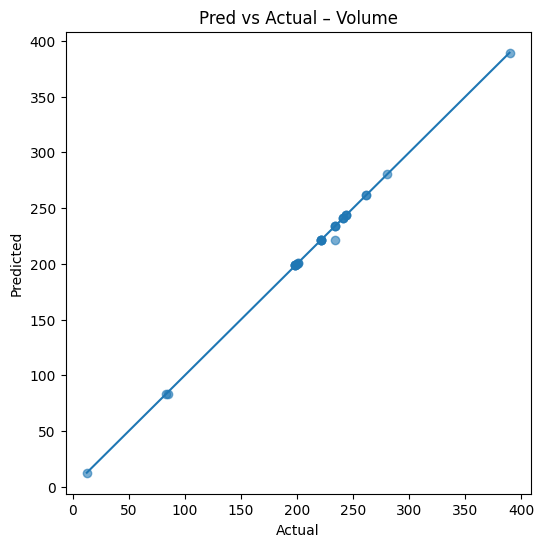

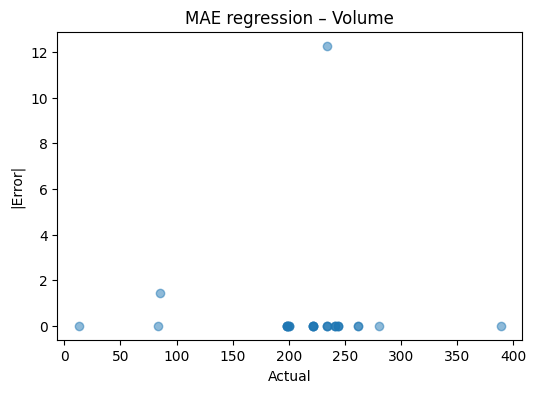


=== Weight(g) Metrics ===
count     : 30
mean_error: -0.3
MAE       : 0.3
MAPE(%)   : 0.15384615384615385
MSE       : 2.7
RMSE      : 1.6431676725154984
R2        : 0.9986862315443916


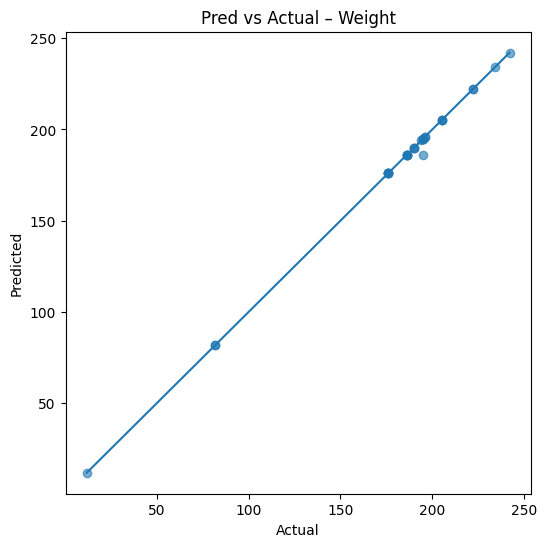

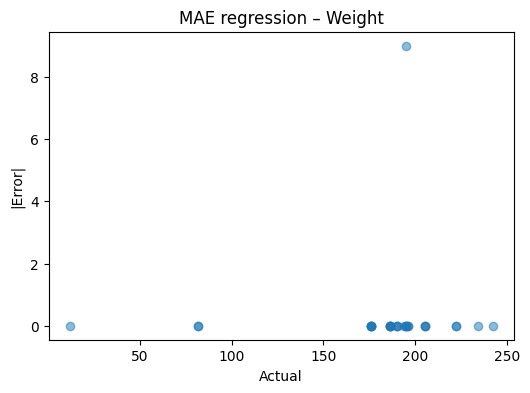

In [ ]:
# ==== FINAL Colab Cell: Parallel evaluation on tuned Gemini endpoint (no syntax errors) ====

MAX_EVAL     = 200
MAX_WORKERS  = 8
TARGET_QPS   = 4.0
REPORT_EVERY = 20

PROJECT_ID        = "927828199877"
LOCATION          = "us-central1"
TUNING_JOB_NAME   = "projects/927828199877/locations/us-central1/tuningJobs/6843384234116120576"
MODEL_NAME        = "projects/927828199877/locations/us-central1/models/5948862582105309184@1"
ENDPOINT_NAME     = "projects/927828199877/locations/us-central1/endpoints/6495240696272781312"

import io, json, math, re, time, requests, threading
import numpy as np, matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import deque
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from google.colab import auth as colab_auth
import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest
try:
    from google.cloud import storage
except ImportError:
    !pip -q install --no-deps google-cloud-storage==2.16.0
    from google.cloud import storage

# --- Auth ---
colab_auth.authenticate_user()
creds,_=google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid: creds.refresh(GoogleAuthRequest())
TOKEN=creds.token
session=requests.Session()
session.headers.update({"Authorization":f"Bearer {TOKEN}","Content-Type":"application/json"})

# --- Helpers ---
def _region_from_resource(name): return name.split("/")[name.split("/").index("locations")+1]
def _gcs_client(): return storage.Client(credentials=creds)
def _split_gs(gs_uri): b,*r=gs_uri[5:].split("/",1); return b,(r[0] if r else "")
def _gcs_read_text(gs_uri): b,p=_split_gs(gs_uri); return _gcs_client().bucket(b).blob(p).download_as_text()

def _guess_mime(uri):
    ext=re.search(r"\.([A-Za-z0-9]+)$",uri.split("?")[0])
    ext=(ext.group(1).lower() if ext else "jpg")
    return {"jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png","webp":"image/webp",
            "bmp":"image/bmp","tif":"image/tiff","tiff":"image/tiff","gif":"image/gif"}.get(ext,"image/jpeg")

def _endpoint_generate_json(endpoint,image_uri,prompt_text,timeout=60,max_retries=4):
    loc=_region_from_resource(endpoint)
    url=f"https://{loc}-aiplatform.googleapis.com/v1/{endpoint}:generateContent"
    payload={"contents":[{"role":"user","parts":[
                {"fileData":{"mimeType":_guess_mime(image_uri),"fileUri":image_uri}},
                {"text":prompt_text}]}],
             "generationConfig":{"temperature":0.0,"maxOutputTokens":64}}
    backoff=1
    for _ in range(max_retries):
        try:
            r=session.post(url,json=payload,timeout=timeout)
            if r.status_code==200:
                try:
                    t=r.json()["candidates"][0]["content"]["parts"][0]["text"]
                    return json.loads(t.strip().strip("`"))
                except: return None
            if r.status_code in (408,429,500,502,503,504):
                time.sleep(backoff); backoff=min(backoff*2,8); continue
            print(f"[warn] {r.status_code}: {r.text[:150]}"); return None
        except Exception: time.sleep(backoff); backoff=min(backoff*2,8)
    return None

def _metrics(y_true,y_pred):
    y_true=np.asarray(y_true,float); y_pred=np.asarray(y_pred,float)
    err=y_pred-y_true
    with np.errstate(divide="ignore",invalid="ignore"):
        ape=np.abs(err/y_true)*100; ape=ape[~np.isinf(ape)&~np.isnan(ape)]
    return {"count":len(y_true),"mean_error":float(np.mean(err)),
            "MAE":float(mean_absolute_error(y_true,y_pred)),
            "MAPE(%)":float(np.mean(ape)) if len(ape) else float("nan"),
            "MSE":float(mean_squared_error(y_true,y_pred)),
            "RMSE":float(math.sqrt(mean_squared_error(y_true,y_pred))),
            "R2":float(r2_score(y_true,y_pred))}

def _print_metrics(name,m):
    print(f"\n=== {name} Metrics ===")
    for k,v in m.items(): print(f"{k:10s}: {v}")

def _plots(y_true,y_pred,title):
    y_true,y_pred=np.asarray(y_true,float),np.asarray(y_pred,float)
    plt.figure(figsize=(6,6)); plt.scatter(y_true,y_pred,alpha=0.6)
    mn,mx=min(y_true.min(),y_pred.min()),max(y_true.max(),y_pred.max())
    plt.plot([mn,mx],[mn,mx]); plt.title(f"Pred vs Actual – {title}")
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.show()
    plt.figure(figsize=(6,4)); plt.scatter(y_true,np.abs(y_true-y_pred),alpha=0.5)
    plt.title(f"MAE regression – {title}"); plt.xlabel("Actual"); plt.ylabel("|Error|"); plt.show()

# --- Load validation data ---
job=requests.get(f"https://{LOCATION}-aiplatform.googleapis.com/v1/{TUNING_JOB_NAME}",
                 headers={"Authorization":f"Bearer {TOKEN}"},timeout=60).json()
uris=[u for v in job.values() for u in str(v).split() if u.startswith("gs://")]
val=[u for u in uris if "val.jsonl" in u]
VAL_JSONL=val[0] if val else "gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl"
raw=_gcs_read_text(VAL_JSONL).splitlines()
examples=[json.loads(l) for l in raw if l.strip()]
if MAX_EVAL: examples=examples[:MAX_EVAL]
print(f"Using {len(examples)} examples from {VAL_JSONL}")

# --- Extract IO pairs ---
def _extract(ex):
    try:
        user,model=ex["contents"][0],ex["contents"][1]
        gt=json.loads(model["parts"][0]["text"])
        yv,yw=float(gt["volume_cm3"]),float(gt["weight_g"])
        f,p=None,""
        for part in user["parts"]:
            if "fileData" in part: f=part["fileData"]["fileUri"]
            elif "text" in part: p=part["text"]
        return (f,p,yv,yw) if (f and p) else None
    except: return None

ios=[i for e in examples if (i:=_extract(e))]

# --- Parallel inference ---
pairs_vol,pairs_wt=[],[]
done=0; lock=threading.Lock(); start=time.time()

def worker(args):
    f,p,yv,yw=args
    pred=_endpoint_generate_json(ENDPOINT_NAME,f,p)
    pv=pw=np.nan
    if pred:
        def _num(x):
            try: return float(x)
            except: return float(re.sub(r"[^0-9eE\.\-\+]", "", str(x)) or "nan")
        pv=_num(pred.get("volume_cm3",np.nan)); pw=_num(pred.get("weight_g",np.nan))
    global done
    with lock:
        if not np.isnan(pv): pairs_vol.append((yv,pv))
        if not np.isnan(pw): pairs_wt.append((yw,pw))
        done+=1
        if done%REPORT_EVERY==0 or done==len(ios):
            print(f"progress: {done}/{len(ios)} in {time.time()-start:.1f}s")

print(f"Scoring {len(ios)} examples with {MAX_WORKERS} threads…")
with ThreadPoolExecutor(MAX_WORKERS) as pool:
    for _ in as_completed([pool.submit(worker,a) for a in ios]): pass

print(f"Finished {done}/{len(ios)} in {time.time()-start:.1f}s")
if pairs_vol: yv_t,yv_p=zip(*pairs_vol); mv=_metrics(yv_t,yv_p); _print_metrics("Volume(cm³)",mv); _plots(yv_t,yv_p,"Volume")
if pairs_wt:  yw_t,yw_p=zip(*pairs_wt); mw=_metrics(yw_t,yw_p); _print_metrics("Weight(g)",mw); _plots(yw_t,yw_p,"Weight")
if not pairs_vol and not pairs_wt: print("No usable prediction pairs.")


(0.01, 3)

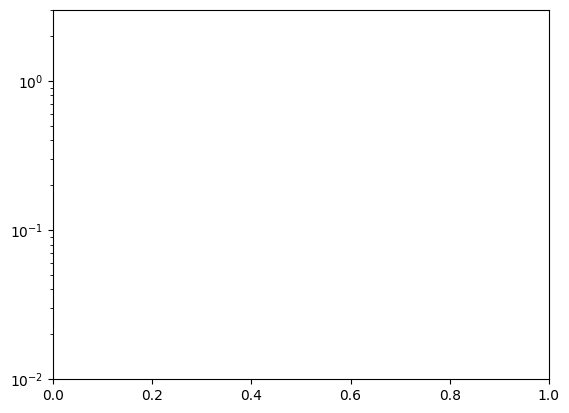

In [ ]:
plt.yscale("log")
plt.ylim(1e-2, 3)  # start just above zero


Using 454 examples from gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl
Scoring 454 examples with 8 threads…
progress: 20/454 in 6.8s
progress: 40/454 in 11.5s
progress: 60/454 in 16.3s
progress: 80/454 in 21.1s
progress: 100/454 in 25.5s
progress: 120/454 in 30.2s
progress: 140/454 in 34.5s
progress: 160/454 in 38.6s
progress: 180/454 in 42.4s
progress: 200/454 in 46.8s
progress: 220/454 in 50.9s
progress: 240/454 in 55.0s
progress: 260/454 in 58.6s
progress: 280/454 in 62.4s
progress: 300/454 in 66.7s
progress: 320/454 in 70.0s
progress: 340/454 in 74.4s
progress: 360/454 in 78.2s
progress: 380/454 in 81.9s
progress: 400/454 in 86.7s
progress: 420/454 in 90.3s
progress: 440/454 in 93.9s
progress: 454/454 in 96.7s
Finished 454/454 in 96.8s

=== Volume(cm³) Metrics ===
count     : 77
mean_error: -0.2148051948051949
MAE       : 0.2148051948051949
MAPE(%)   : 0.1333617584044388
MSE       : 2.0369818181818187
RMSE      : 1.427

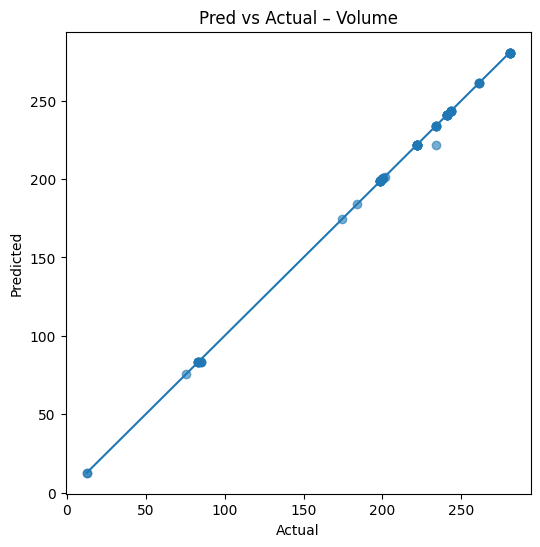

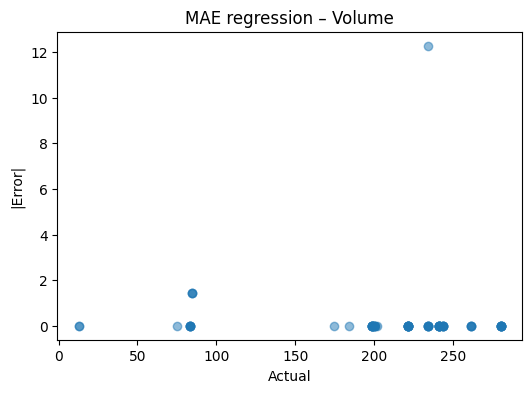


=== Weight(g) Metrics ===
count     : 77
mean_error: -0.11688311688311688
MAE       : 0.11688311688311688
MAPE(%)   : 0.059940059940059943
MSE       : 1.051948051948052
RMSE      : 1.0256451881367417
R2        : 0.999602912408602


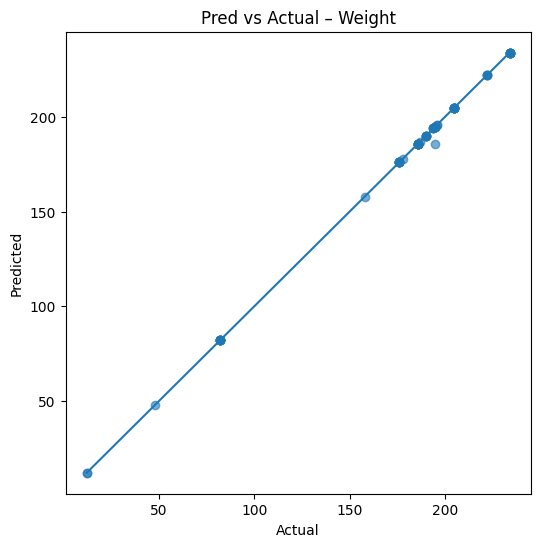

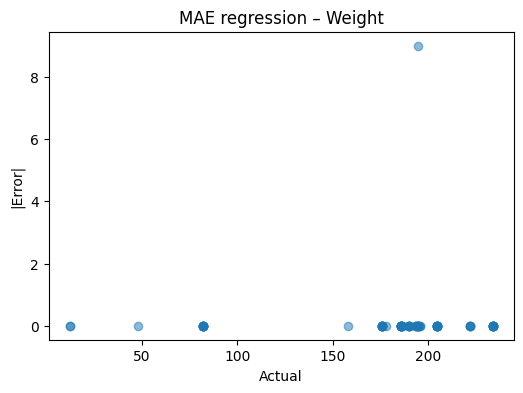

In [ ]:
# ==== FINAL Colab Cell: Parallel evaluation on tuned Gemini endpoint (no syntax errors) ====

MAX_EVAL     = None
MAX_WORKERS  = 8
TARGET_QPS   = 4.0
REPORT_EVERY = 20

PROJECT_ID        = "927828199877"
LOCATION          = "us-central1"
TUNING_JOB_NAME   = "projects/927828199877/locations/us-central1/tuningJobs/6843384234116120576"
MODEL_NAME        = "projects/927828199877/locations/us-central1/models/5948862582105309184@1"
ENDPOINT_NAME     = "projects/927828199877/locations/us-central1/endpoints/6495240696272781312"

import io, json, math, re, time, requests, threading
import numpy as np, matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import deque
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from google.colab import auth as colab_auth
import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest
try:
    from google.cloud import storage
except ImportError:
    !pip -q install --no-deps google-cloud-storage==2.16.0
    from google.cloud import storage

# --- Auth ---
colab_auth.authenticate_user()
creds,_=google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid: creds.refresh(GoogleAuthRequest())
TOKEN=creds.token
session=requests.Session()
session.headers.update({"Authorization":f"Bearer {TOKEN}","Content-Type":"application/json"})

# --- Helpers ---
def _region_from_resource(name): return name.split("/")[name.split("/").index("locations")+1]
def _gcs_client(): return storage.Client(credentials=creds)
def _split_gs(gs_uri): b,*r=gs_uri[5:].split("/",1); return b,(r[0] if r else "")
def _gcs_read_text(gs_uri): b,p=_split_gs(gs_uri); return _gcs_client().bucket(b).blob(p).download_as_text()

def _guess_mime(uri):
    ext=re.search(r"\.([A-Za-z0-9]+)$",uri.split("?")[0])
    ext=(ext.group(1).lower() if ext else "jpg")
    return {"jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png","webp":"image/webp",
            "bmp":"image/bmp","tif":"image/tiff","tiff":"image/tiff","gif":"image/gif"}.get(ext,"image/jpeg")

def _endpoint_generate_json(endpoint,image_uri,prompt_text,timeout=60,max_retries=4):
    loc=_region_from_resource(endpoint)
    url=f"https://{loc}-aiplatform.googleapis.com/v1/{endpoint}:generateContent"
    payload={"contents":[{"role":"user","parts":[
                {"fileData":{"mimeType":_guess_mime(image_uri),"fileUri":image_uri}},
                {"text":prompt_text}]}],
             "generationConfig":{"temperature":0.0,"maxOutputTokens":64}}
    backoff=1
    for _ in range(max_retries):
        try:
            r=session.post(url,json=payload,timeout=timeout)
            if r.status_code==200:
                try:
                    t=r.json()["candidates"][0]["content"]["parts"][0]["text"]
                    return json.loads(t.strip().strip("`"))
                except: return None
            if r.status_code in (408,429,500,502,503,504):
                time.sleep(backoff); backoff=min(backoff*2,8); continue
            print(f"[warn] {r.status_code}: {r.text[:150]}"); return None
        except Exception: time.sleep(backoff); backoff=min(backoff*2,8)
    return None

def _metrics(y_true,y_pred):
    y_true=np.asarray(y_true,float); y_pred=np.asarray(y_pred,float)
    err=y_pred-y_true
    with np.errstate(divide="ignore",invalid="ignore"):
        ape=np.abs(err/y_true)*100; ape=ape[~np.isinf(ape)&~np.isnan(ape)]
    return {"count":len(y_true),"mean_error":float(np.mean(err)),
            "MAE":float(mean_absolute_error(y_true,y_pred)),
            "MAPE(%)":float(np.mean(ape)) if len(ape) else float("nan"),
            "MSE":float(mean_squared_error(y_true,y_pred)),
            "RMSE":float(math.sqrt(mean_squared_error(y_true,y_pred))),
            "R2":float(r2_score(y_true,y_pred))}

def _print_metrics(name,m):
    print(f"\n=== {name} Metrics ===")
    for k,v in m.items(): print(f"{k:10s}: {v}")

def _plots(y_true,y_pred,title):
    y_true,y_pred=np.asarray(y_true,float),np.asarray(y_pred,float)
    plt.figure(figsize=(6,6)); plt.scatter(y_true,y_pred,alpha=0.6)
    mn,mx=min(y_true.min(),y_pred.min()),max(y_true.max(),y_pred.max())
    plt.plot([mn,mx],[mn,mx]); plt.title(f"Pred vs Actual – {title}")
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.show()
    plt.figure(figsize=(6,4)); plt.scatter(y_true,np.abs(y_true-y_pred),alpha=0.5)
    plt.title(f"MAE regression – {title}"); plt.xlabel("Actual"); plt.ylabel("|Error|"); plt.show()

# --- Load validation data ---
job=requests.get(f"https://{LOCATION}-aiplatform.googleapis.com/v1/{TUNING_JOB_NAME}",
                 headers={"Authorization":f"Bearer {TOKEN}"},timeout=60).json()
uris=[u for v in job.values() for u in str(v).split() if u.startswith("gs://")]
val=[u for u in uris if "val.jsonl" in u]
VAL_JSONL=val[0] if val else "gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl"
raw=_gcs_read_text(VAL_JSONL).splitlines()
examples=[json.loads(l) for l in raw if l.strip()]
if MAX_EVAL: examples=examples[:MAX_EVAL]
print(f"Using {len(examples)} examples from {VAL_JSONL}")

# --- Extract IO pairs ---
def _extract(ex):
    try:
        user,model=ex["contents"][0],ex["contents"][1]
        gt=json.loads(model["parts"][0]["text"])
        yv,yw=float(gt["volume_cm3"]),float(gt["weight_g"])
        f,p=None,""
        for part in user["parts"]:
            if "fileData" in part: f=part["fileData"]["fileUri"]
            elif "text" in part: p=part["text"]
        return (f,p,yv,yw) if (f and p) else None
    except: return None

ios=[i for e in examples if (i:=_extract(e))]

# --- Parallel inference ---
pairs_vol,pairs_wt=[],[]
done=0; lock=threading.Lock(); start=time.time()

def worker(args):
    f,p,yv,yw=args
    pred=_endpoint_generate_json(ENDPOINT_NAME,f,p)
    pv=pw=np.nan
    if pred:
        def _num(x):
            try: return float(x)
            except: return float(re.sub(r"[^0-9eE\.\-\+]", "", str(x)) or "nan")
        pv=_num(pred.get("volume_cm3",np.nan)); pw=_num(pred.get("weight_g",np.nan))
    global done
    with lock:
        if not np.isnan(pv): pairs_vol.append((yv,pv))
        if not np.isnan(pw): pairs_wt.append((yw,pw))
        done+=1
        if done%REPORT_EVERY==0 or done==len(ios):
            print(f"progress: {done}/{len(ios)} in {time.time()-start:.1f}s")

print(f"Scoring {len(ios)} examples with {MAX_WORKERS} threads…")
with ThreadPoolExecutor(MAX_WORKERS) as pool:
    for _ in as_completed([pool.submit(worker,a) for a in ios]): pass

print(f"Finished {done}/{len(ios)} in {time.time()-start:.1f}s")
if pairs_vol: yv_t,yv_p=zip(*pairs_vol); mv=_metrics(yv_t,yv_p); _print_metrics("Volume(cm³)",mv); _plots(yv_t,yv_p,"Volume")
if pairs_wt:  yw_t,yw_p=zip(*pairs_wt); mw=_metrics(yw_t,yw_p); _print_metrics("Weight(g)",mw); _plots(yw_t,yw_p,"Weight")
if not pairs_vol and not pairs_wt: print("No usable prediction pairs.")


In [ ]:
# ==== ONE-CELL: Export actual values from your validation JSONL to Excel ====

import json, pandas as pd
from google.cloud import storage
from google.colab import auth as colab_auth

# --- CONFIG ---
PROJECT_ID = "927828199877"
VAL_JSONL  = "gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl"
EXCEL_PATH = "/content/val_actuals.xlsx"

# --- AUTH & INIT ---
colab_auth.authenticate_user()
client = storage.Client(project=PROJECT_ID)

# --- LOAD JSONL ---
def _split_gs(gs_uri):
    b,*r=gs_uri[5:].split("/",1); return b,(r[0] if r else "")
b,p=_split_gs(VAL_JSONL)
blob = client.bucket(b).blob(p)
lines = blob.download_as_text().splitlines()
examples = [json.loads(l) for l in lines if l.strip()]

# --- EXTRACT actual values ---
rows=[]
for ex in examples:
    try:
        user, model = ex["contents"][0], ex["contents"][1]
        gt = json.loads(model["parts"][0]["text"])
        yv, yw = gt.get("volume_cm3"), gt.get("weight_g")
        f_uri, prompt = None, ""
        for part in user["parts"]:
            if "fileData" in part: f_uri = part["fileData"]["fileUri"]
            elif "text" in part:  prompt = part["text"]
        rows.append({
            "image_uri": f_uri,
            "prompt": prompt,
            "actual_volume_cm3": yv,
            "actual_weight_g": yw
        })
    except Exception as e:
        print("skip:", e)

df = pd.DataFrame(rows)
print("Extracted rows:", len(df))
display(df.head(10))

# --- SAVE ---
df.to_excel(EXCEL_PATH, index=False)
print(f"\n✅ Saved ground-truth validation data to {EXCEL_PATH}")
from google.colab import files; files.download(EXCEL_PATH)


Extracted rows: 454


,image_uri,prompt,actual_volume_cm3,actual_weight_g
0,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,23.67,12.0
1,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,175.08,167.0
2,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,240.84,205.0
3,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,174.41,158.0
4,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,175.08,167.0
5,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,75.37,48.0
6,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,199.83,194.0
7,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,174.41,158.0
8,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,243.52,190.0
9,gs://recipebuilder-finetune/recipebuilder-sft-...,Return JSON only with keys volume_cm3 and weig...,200.55,196.0



✅ Saved ground-truth validation data to /content/val_actuals.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ==== FINAL: Multimodal tuned Gemini batch evaluation ====

import json, re, time, math, pandas as pd, numpy as np, requests
from tqdm import tqdm
from google.colab import auth as colab_auth
import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest

# ---------------- CONFIG ----------------
PROJECT_ID    = "927828199877"
LOCATION      = "us-central1"
ENDPOINT_NAME = "projects/927828199877/locations/us-central1/endpoints/6495240696272781312"

INPUT_XLSX    = "/content/val_actuals.xlsx"   # must have: image_uri, prompt, actual_volume_cm3, actual_weight_g
OUTPUT_XLSX   = "/content/comparison_eval.xlsx"
MAX_EXAMPLES  = 50    # set None to process all

# ---------------- AUTH ----------------
colab_auth.authenticate_user()
creds, _ = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid:
    creds.refresh(GoogleAuthRequest())
TOKEN = creds.token

session = requests.Session()
session.headers.update({
    "Authorization": f"Bearer {TOKEN}",
    "Content-Type": "application/json",
})
API_URL = f"https://{LOCATION}-aiplatform.googleapis.com/v1/{ENDPOINT_NAME}:generateContent"

# ---------------- HELPERS ----------------
def _guess_mime(uri: str) -> str:
    ext = re.search(r"\.([A-Za-z0-9]+)$", uri.split("?")[0])
    ext = (ext.group(1).lower() if ext else "jpg")
    return {
        "jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png",
        "webp":"image/webp","bmp":"image/bmp","tif":"image/tiff",
        "tiff":"image/tiff","gif":"image/gif"
    }.get(ext,"image/jpeg")

def call_generate(image_uri, prompt_text, timeout=90):
    """Send one image+text request to the tuned Gemini endpoint."""
    body = {
      "contents": [{
        "role": "user",
        "parts": [
          {"fileData": {"fileUri": image_uri, "mimeType": _guess_mime(image_uri)}},
          {"text": str(prompt_text)}
        ]
      }],
      "generationConfig": {
        "temperature": 0.0,
        "maxOutputTokens": 128,
        "responseMimeType": "application/json",
        "responseSchema": {
          "type": "OBJECT",
          "properties": {
            "volume_cm3": {"type": "NUMBER"},
            "weight_g":   {"type": "NUMBER"}
          },
          "required": ["volume_cm3", "weight_g"]
        }
      }
    }
    r = session.post(API_URL, json=body, timeout=timeout)
    if r.status_code != 200:
        print(f"[HTTP {r.status_code}] {r.text[:200]}")
        return None
    try:
        data = r.json()
        txt = data["candidates"][0]["content"]["parts"][0]["text"]
        return json.loads(txt)
    except Exception as e:
        print("[warn] could not parse JSON:", e)
        return None

def fnum(x):
    try: return float(x)
    except: return np.nan

# ---------------- LOAD INPUT ----------------
df = pd.read_excel(INPUT_XLSX)
if MAX_EXAMPLES:
    df = df.head(MAX_EXAMPLES)
print(f"Loaded {len(df)} examples")

# ---------------- RUN INFERENCE ----------------
pred_vols, pred_wgts = [], []

for i, row in tqdm(df.iterrows(), total=len(df)):
    label = f"[{i+1}/{len(df)}]"
    image_uri = row["image_uri"]
    prompt_text = row["prompt"]

    pred = call_generate(image_uri, prompt_text)
    if pred and isinstance(pred, dict):
        v = fnum(pred.get("volume_cm3"))
        w = fnum(pred.get("weight_g"))
        pred_vols.append(v)
        pred_wgts.append(w)
        print(f"{label} ✓ volume={v} weight={w}")
    else:
        pred_vols.append(np.nan)
        pred_wgts.append(np.nan)
        print(f"{label} ⚠ no prediction")

# ---------------- SAVE OUTPUT ----------------
df["tuned_volume_cm3"] = pred_vols
df["tuned_weight_g"]   = pred_wgts
df.to_excel(OUTPUT_XLSX, index=False)
print(f"\n✅ Saved {len(df)} rows to {OUTPUT_XLSX}")
from google.colab import files; files.download(OUTPUT_XLSX)


Loaded 50 examples


  2%|▏         | 1/50 [00:02<01:51,  2.27s/it]

[warn] could not parse JSON: Expecting value: line 1 column 1 (char 0)
[1/50] ⚠ no prediction


  4%|▍         | 2/50 [00:04<01:55,  2.40s/it]

[warn] could not parse JSON: Expecting value: line 1 column 1 (char 0)
[2/50] ⚠ no prediction


  4%|▍         | 2/50 [00:06<02:40,  3.35s/it]


KeyboardInterrupt: 

In [ ]:
# ==== RECREATE val_actuals.xlsx from GCS validation JSONL ====
import json, pandas as pd
from google.colab import auth as colab_auth
from google.cloud import storage

# --- CONFIG ---
PROJECT_ID = "927828199877"
VAL_JSONL  = "gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized_20251005-225223/all/jsonl/val.jsonl"
OUT_PATH   = "/content/val_actuals.xlsx"

# --- AUTH & INIT ---
colab_auth.authenticate_user()
client = storage.Client(project=PROJECT_ID)

# --- LOAD JSONL ---
def _split_gs(uri):
    b,*r = uri[5:].split("/",1)
    return b,(r[0] if r else "")
b,p = _split_gs(VAL_JSONL)
blob = client.bucket(b).blob(p)
lines = blob.download_as_text().splitlines()
examples = [json.loads(l) for l in lines if l.strip()]

# --- EXTRACT image + prompt + targets ---
rows = []
for ex in examples:
    try:
        user = ex["contents"][0]
        model = ex["contents"][1]
        gt = json.loads(model["parts"][0]["text"])
        yv, yw = gt.get("volume_cm3"), gt.get("weight_g")
        f_uri, prompt = None, ""
        for part in user["parts"]:
            if "fileData" in part:
                f_uri = part["fileData"]["fileUri"]
            elif "text" in part:
                prompt = part["text"]
        if f_uri and prompt and yv is not None and yw is not None:
            rows.append({
                "image_uri": f_uri,
                "prompt": prompt,
                "actual_volume_cm3": yv,
                "actual_weight_g": yw
            })
    except Exception as e:
        pass

df = pd.DataFrame(rows)
df.to_excel(OUT_PATH, index=False)
print(f"✅ Recreated {len(df)} validation rows → {OUT_PATH}")
from google.colab import files; files.download(OUT_PATH)


✅ Recreated 454 validation rows → /content/val_actuals.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ==== FINAL ONE-CELL: Batched (50) Base vs Tuned with auto-refresh & Drive checkpoints ====
import os, json, re, time, base64, pandas as pd, numpy as np
from tqdm import tqdm
from google.colab import auth as colab_auth, drive as colab_drive
import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest, AuthorizedSession

# ---------------- CONFIG ----------------
PROJECT_ID      = "927828199877"
LOCATION        = "us-central1"
ENDPOINT_TUNED  = "projects/927828199877/locations/us-central1/endpoints/6495240696272781312"
BASE_MODEL_PATH = f"projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/gemini-2.5-flash"

INPUT_XLSX   = "/content/val_actuals.xlsx"
DRIVE_DIR    = "/content/drive/MyDrive/gemini_evals"   # change if you like
OUTPUT_BASENAME = "comparison_evalsss.xlsx"               # rolling file (overwritten each batch)
BATCH_SIZE   = 50
MAX_EXAMPLES = None        # None = full run
RETRIES      = 1
RETRY_SLEEP  = 1.0
MAX_TOKENS   = 2048
POST_TIMEOUT = 120
GET_TIMEOUT  = 45

# ---------------- AUTH (Vertex auto-refresh) ----------------
colab_auth.authenticate_user()
creds, _ = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid:
    creds.refresh(GoogleAuthRequest())
session = AuthorizedSession(creds)

URL_BASE  = f"https://{LOCATION}-aiplatform.googleapis.com/v1/{BASE_MODEL_PATH}:generateContent"
URL_TUNED = f"https://{LOCATION}-aiplatform.googleapis.com/v1/{ENDPOINT_TUNED}:generateContent"

# ---------------- MOUNT DRIVE (prompt ONCE per session) ----------------
colab_drive.mount("/content/drive", force_remount=False)
os.makedirs(DRIVE_DIR, exist_ok=True)
OUTPUT_XLSX = os.path.join(DRIVE_DIR, OUTPUT_BASENAME)

# ---------------- HELPERS ----------------
def _guess_mime(uri: str):
    ext = re.search(r"\.([A-Za-z0-9]+)$", uri.split("?")[0])
    ext = (ext.group(1).lower() if ext else "jpg")
    return {
        "jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png","webp":"image/webp",
        "bmp":"image/bmp","tif":"image/tiff","tiff":"image/tiff","gif":"image/gif"
    }.get(ext, "image/jpeg")

def _load_bytes_b64(uri):
    mime = _guess_mime(uri)
    if uri.startswith("gs://"):
        from google.cloud import storage
        bkt, path = uri[5:].split("/", 1)
        blob = storage.Client(project=PROJECT_ID).bucket(bkt).blob(path)
        data = blob.download_as_bytes()
    else:
        r = session.get(uri, timeout=GET_TIMEOUT)
        r.raise_for_status()
        data = r.content
    return mime, base64.b64encode(data).decode("utf-8")

def _clean_json_text(txt):
    if not txt: return ""
    t = txt.strip().strip("`").lstrip("json").strip()
    return re.sub(r"^json\s*", "", t, flags=re.I)

def _parse_json(txt):
    t = _clean_json_text(txt)
    if not t: return None
    try:
        return json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, re.S)
        if m:
            try: return json.loads(m.group(0))
            except: return None
    return None

FEWSHOT = [
    {"role":"user",  "parts":[{"text":"Return only JSON. Label: Apple\nWidth (in): 3.40\nHeight (in): 3.60"}]},
    {"role":"model", "parts":[{"text":'{"volume_cm3": 242.0, "weight_g": 205.0}'}]},
    {"role":"user",  "parts":[{"text":"Return only JSON. Label: Banana\nWidth (in): 6.10\nHeight (in): 2.40"}]},
    {"role":"model", "parts":[{"text":'{"volume_cm3": 200.0, "weight_g": 185.0}'}]},
]

def _genconfig(with_schema=True):
    cfg = {"temperature":0.0, "maxOutputTokens":MAX_TOKENS}
    if with_schema:
        cfg.update({
            "responseMimeType":"application/json",
            "responseSchema":{
                "type":"OBJECT",
                "properties":{
                    "volume_cm3":{"type":"NUMBER"},
                    "weight_g":{"type":"NUMBER"}
                },
                "required":["volume_cm3","weight_g"]
            }
        })
    return cfg

def fnum(x):
    try: return float(x)
    except: return np.nan

# ---- Base ----
def predict_base_inline(image_uri, prompt, label):
    try:
        mime, b64 = _load_bytes_b64(image_uri)
    except Exception as e:
        print(f"{label} base [load-error] {e}")
        return None
    body = {
        "contents": FEWSHOT + [{
            "role":"user",
            "parts":[
                {"inlineData":{"mimeType":mime,"data":b64}},
                {"text":('Return ONLY valid JSON with numeric keys "volume_cm3" and "weight_g". '
                         'No code fences, no words.\n'+prompt)}
            ]
        }],
        "generationConfig": _genconfig(True)
    }
    r = session.post(URL_BASE, json=body, timeout=POST_TIMEOUT,
                     headers={"Content-Type":"application/json"})
    if r.status_code != 200:
        print(f"{label} base [HTTP {r.status_code}] {r.text[:120]}")
        return None
    try:
        txt = r.json()["candidates"][0]["content"]["parts"][0].get("text","")
        return _parse_json(txt)
    except: return None

# ---- Tuned ----
def predict_tuned_fileuri(image_uri, prompt, label):
    body = {
        "contents":[{
            "role":"user",
            "parts":[
                {"fileData":{"fileUri":image_uri,"mimeType":_guess_mime(image_uri)}},
                {"text":('Return ONLY valid JSON with numeric keys "volume_cm3" and "weight_g". '
                         'No code fences, no words.\n'+prompt)}
            ]
        }],
        "generationConfig": _genconfig(True)
    }
    r = session.post(URL_TUNED, json=body, timeout=POST_TIMEOUT,
                     headers={"Content-Type":"application/json"})
    if r.status_code != 200:
        print(f"{label} tuned [HTTP {r.status_code}] {r.text[:120]}")
        return None
    try:
        txt = r.json()["candidates"][0]["content"]["parts"][0].get("text","")
        return _parse_json(txt)
    except: return None

# ---------------- LOAD INPUT ----------------
df = pd.read_excel(INPUT_XLSX)
if MAX_EXAMPLES: df = df.head(MAX_EXAMPLES)
print(f"Loaded {len(df)} examples")

# Ensure result columns exist (supports resume)
for c in ["base_volume_cm3","base_weight_g","tuned_volume_cm3","tuned_weight_g"]:
    if c not in df.columns: df[c] = np.nan

# Resume point: first row missing tuned result
start_idx = int(df[df["tuned_volume_cm3"].isna()].index.min() or 0)
n = len(df)

# ---------------- BATCHED RUN (saves to Drive after each batch) ----------------
for start in range(start_idx, n, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n)
    batch = df.iloc[start:end]
    print(f"\n=== Processing rows {start+1}-{end}/{n} ===")

    for i, row in tqdm(batch.iterrows(), total=len(batch), leave=False):
        label = f"[{i+1}/{n}]"
        img, text = row["image_uri"], row["prompt"]

        # Base
        base_pred = predict_base_inline(img, text, label)
        tries = 0
        while (not base_pred) and tries < RETRIES:
            time.sleep(RETRY_SLEEP)
            base_pred = predict_base_inline(img, text, label+" (retry)")
            tries += 1

        # Tuned
        tuned_pred = predict_tuned_fileuri(img, text, label)
        tries = 0
        while (not tuned_pred) and tries < RETRIES:
            time.sleep(RETRY_SLEEP)
            tuned_pred = predict_tuned_fileuri(img, text, label+" (retry)")
            tries += 1

        bv = fnum(base_pred.get("volume_cm3")) if base_pred else np.nan
        bw = fnum(base_pred.get("weight_g"))   if base_pred else np.nan
        tv = fnum(tuned_pred.get("volume_cm3")) if tuned_pred else np.nan
        tw = fnum(tuned_pred.get("weight_g"))   if tuned_pred else np.nan

        df.loc[i, "base_volume_cm3"]  = bv
        df.loc[i, "base_weight_g"]    = bw
        df.loc[i, "tuned_volume_cm3"] = tv
        df.loc[i, "tuned_weight_g"]   = tw

    # Save a rolling checkpoint to Drive (overwrites same file)
    df.to_excel(OUTPUT_XLSX, index=False)
    print(f"✅ Saved checkpoint to: {OUTPUT_XLSX}")

print(f"\n✅ All {n} rows processed. Final saved at: {OUTPUT_XLSX}")


Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/val_actuals.xlsx'

In [ ]:
import json, requests, google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest
from google.colab import auth as colab_auth

PROJECT_ID="927828199877"
LOCATION="us-central1"
ENDPOINT="projects/927828199877/locations/us-central1/endpoints/6495240696272781312"

IMAGE="gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/33bf9585a6a5_24_jpg.rf.310cb87441fd05067873dc7ec52c6330.jpg"
TEXT="""Return **only valid JSON**, no words or code fences.
Use keys "volume_cm3" and "weight_g" (numbers only).
Label: Bell Pepper
Width (in): 116.535496
Height (in): 144.488267"""

colab_auth.authenticate_user()
creds,_=google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
creds.refresh(GoogleAuthRequest())

url=f"https://{LOCATION}-aiplatform.googleapis.com/v1/{ENDPOINT}:generateContent"
headers={"Authorization":f"Bearer {creds.token}","Content-Type":"application/json"}
body={
 "contents":[{"role":"user","parts":[
   {"fileData":{"fileUri":IMAGE,"mimeType":"image/jpeg"}},
   {"text":TEXT}]}],
 "generationConfig":{"temperature":0.0,"maxOutputTokens":1024}
}
r=requests.post(url,headers=headers,json=body,timeout=120)
print("HTTP",r.status_code)
print(json.dumps(r.json(),indent=2)[:1500])


HTTP 200
{
  "candidates": [
    {
      "content": {
        "role": "model",
        "parts": [
          {
            "text": "{\"volume_cm3\":23.67,\"weight_g\":12.0}"
          }
        ]
      },
      "finishReason": "STOP",
      "avgLogprobs": -0.01392761440504165
    }
  ],
  "usageMetadata": {
    "promptTokenCount": 326,
    "candidatesTokenCount": 21,
    "totalTokenCount": 347,
    "trafficType": "ON_DEMAND",
    "promptTokensDetails": [
      {
        "modality": "IMAGE",
        "tokenCount": 258
      },
      {
        "modality": "TEXT",
        "tokenCount": 68
      }
    ],
    "candidatesTokensDetails": [
      {
        "modality": "TEXT",
        "tokenCount": 21
      }
    ]
  },
  "modelVersion": "gemini-2.5-flash@default",
  "createTime": "2025-10-24T04:08:57.985652Z",
  "responseId": "2fv6aLSUPKCH3NoPqZW5gAo"
}


In [ ]:
# ==== ONE-CELL: Base Gemini 2.5 Flash (multimodal) with schema + few-shot ====
import json, re, requests, google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest
from google.colab import auth as colab_auth

# --- CONFIG ---
PROJECT_ID = "927828199877"
LOCATION   = "us-central1"
BASE_MODEL = f"projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/gemini-2.5-flash"

# Test sample (same style as your val file)
IMAGE_URI = "gs://recipebuilder-finetune/recipebuilder-sft-20251005-213246/data_resized/images/33bf9585a6a5_24_jpg.rf.310cb87441fd05067873dc7ec52c6330.jpg"
PROMPT_TEXT = """Return values for volume_cm3 and weight_g based on the object and dimensions below.
Label: Bell Pepper
Width (in): 116.535496
Height (in): 144.488267"""

# --- AUTH ---
colab_auth.authenticate_user()
creds, _ = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid: creds.refresh(GoogleAuthRequest())

url = f"https://{LOCATION}-aiplatform.googleapis.com/v1/{BASE_MODEL}:generateContent"
headers = {"Authorization": f"Bearer {creds.token}", "Content-Type": "application/json"}

# --- FEW-SHOT EXAMPLES (text-only exemplars to teach output shape) ---
fewshot_user_1  = """Return only the JSON object for these values.
Label: Apple
Width (in): 3.40
Height (in): 3.60"""
fewshot_model_1 = '{"volume_cm3": 242.0, "weight_g": 205.0}'

fewshot_user_2  = """Return only the JSON object for these values.
Label: Banana
Width (in): 6.10
Height (in): 2.40"""
fewshot_model_2 = '{"volume_cm3": 200.0, "weight_g": 185.0}'

# --- REQUEST BODY ---
body = {
  "contents": [
    # few-shot 1
    {"role": "user",  "parts": [{"text": fewshot_user_1}]},
    {"role": "model", "parts": [{"text": fewshot_model_1}]},
    # few-shot 2
    {"role": "user",  "parts": [{"text": fewshot_user_2}]},
    {"role": "model", "parts": [{"text": fewshot_model_2}]},
    # now the actual multimodal example
    {"role": "user", "parts": [
      {"fileData": {"fileUri": IMAGE_URI, "mimeType": "image/jpeg"}},
      {"text": (
        'Return *only* valid JSON with numeric keys "volume_cm3" and "weight_g". '
        'No code fences, no words.\n' + PROMPT_TEXT
      )}
    ]}
  ],
  "generationConfig": {
    "temperature": 0.0,
    "maxOutputTokens": 1024,
    "responseMimeType": "application/json",
    "responseSchema": {
      "type": "OBJECT",
      "properties": {
        "volume_cm3": {"type": "NUMBER"},
        "weight_g":   {"type": "NUMBER"}
      },
      "required": ["volume_cm3", "weight_g"]
    }
  }
}

# --- CALL ---
r = requests.post(url, headers=headers, json=body, timeout=120)
print("HTTP", r.status_code)
resp = r.json()
print(json.dumps(resp, indent=2)[:1000])

# --- PARSE (robust to stray formatting) ---
def parse_json_from_response(d):
    try:
        txt = d["candidates"][0]["content"]["parts"][0].get("text", "")
    except Exception:
        return None
    t = txt.strip().strip("`").lstrip("json").strip()
    t = re.sub(r"^json\s*", "", t, flags=re.I)
    try:
        return json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, re.S)
        return json.loads(m.group(0)) if m else None

parsed = parse_json_from_response(resp)
print("\nParsed:", parsed)


HTTP 200
{
  "candidates": [
    {
      "content": {
        "role": "model",
        "parts": [
          {
            "text": "{\"volume_cm3\": 300.0, \"weight_g\": 200.0}\n"
          }
        ]
      },
      "finishReason": "MAX_TOKENS",
      "avgLogprobs": -6.877856914813702
    }
  ],
  "usageMetadata": {
    "promptTokenCount": 476,
    "candidatesTokenCount": 26,
    "totalTokenCount": 1488,
    "trafficType": "ON_DEMAND",
    "promptTokensDetails": [
      {
        "modality": "TEXT",
        "tokenCount": 218
      },
      {
        "modality": "IMAGE",
        "tokenCount": 258
      }
    ],
    "candidatesTokensDetails": [
      {
        "modality": "TEXT",
        "tokenCount": 26
      }
    ],
    "thoughtsTokenCount": 986
  },
  "modelVersion": "gemini-2.5-flash",
  "createTime": "2025-10-24T04:15:44.230528Z",
  "responseId": "cP36aICJDqeonvgPirTKyQE"
}

Parsed: {'volume_cm3': 300.0, 'weight_g': 200.0}


In [ ]:
# ==== SweetPotato Validation: Base vs Tuned Endpoint (checkpoint every 50) ====
# - Restricts to validation rows from VAL_JSONL_URI when ONLY_VALIDATION=True
# - Compares BASE vs TUNED (endpoint id)
# - Parallel workers=8
# - Writes to a NEW output Excel (does not overwrite your original)

import os, json, re, time, base64, math, concurrent.futures as cf
import pandas as pd, numpy as np
from tqdm import tqdm

# ---------------- USER CONFIG ----------------
PROJECT_ID       = "927828199877"
LOCATION         = "us-central1"

# (Optional) tuned model name (kept for logging)
TUNED_MODEL_NAME = "projects/927828199877/locations/us-central1/models/8949350649468813312@1"

# UPDATED tuned endpoint id (sweet potato)
ENDPOINT_NAME    = "projects/927828199877/locations/us-central1/endpoints/6710547063223877632"

# Base model
BASE_MODEL_PATH  = f"projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/gemini-2.5-flash"

# Validation JSONL to select rows
VAL_JSONL_URI = "gs://recipebuilder-finetune/recipebuilder-sft-20251029-182246/data_resized_20251029-191544/all/jsonl/val.jsonl"

# Drive input/output
DRIVE_DIR       = "/content/drive/MyDrive/gemini_evals"
INPUT_XLSX      = os.path.join(DRIVE_DIR, "comparison_eval_sweetpotato_all.xlsx")   # existing input
OUTPUT_XLSX     = os.path.join(DRIVE_DIR, "comparison_eval_sweetpotato_data.xlsx")  # NEW output file

# Behavior
ONLY_VALIDATION = True     # set False to run all rows in INPUT_XLSX
BATCH_SIZE      = 50
MAX_EXAMPLES    = None     # None = all selected rows
RETRIES         = 2
RETRY_SLEEP_S   = 2.0
MAX_TOKENS      = 2048
POST_TIMEOUT    = 120
GET_TIMEOUT     = 45
WORKERS         = 8        # parallel calls; tweak if you see quota/429s

# ---------------- AUTH (Vertex + Drive) ----------------
try:
    from google.colab import auth as colab_auth, drive as colab_drive
    colab_auth.authenticate_user()
    IN_COLAB = True
except Exception:
    IN_COLAB = False

import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest, AuthorizedSession
creds, _ = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid:
    creds.refresh(GoogleAuthRequest())
session = AuthorizedSession(creds)

# Drive mount
if IN_COLAB:
    try:
        from google.colab import drive as colab_drive
        colab_drive.mount("/content/drive", force_remount=False)
    except Exception:
        pass
os.makedirs(DRIVE_DIR, exist_ok=True)

# ---------------- URLs ----------------
def _url_models_generate(model_name: str) -> str:
    # projects/.../locations/.../models/<id>@1:generateContent
    return f"https://{LOCATION}-aiplatform.googleapis.com/v1/{model_name}:generateContent"

def _url_endpoints_generate(endpoint_name: str) -> str:
    # projects/.../locations/.../endpoints/<id>:generateContent
    return f"https://{LOCATION}-aiplatform.googleapis.com/v1/{endpoint_name}:generateContent"

URL_BASE  = _url_models_generate(BASE_MODEL_PATH)
URL_TUNED = _url_endpoints_generate(ENDPOINT_NAME)

# ---------------- HELPERS ----------------
def _guess_mime(uri: str):
    ext = re.search(r"\.([A-Za-z0-9]+)$", uri.split("?")[0])
    ext = (ext.group(1).lower() if ext else "jpg")
    return {
        "jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png","webp":"image/webp",
        "bmp":"image/bmp","tif":"image/tiff","tiff":"image/tiff","gif":"image/gif"
    }.get(ext, "image/jpeg")

def _load_bytes_b64(uri: str):
    mime = _guess_mime(uri)
    if uri.startswith("gs://"):
        from google.cloud import storage
        bkt, path = uri[5:].split("/", 1)
        blob = storage.Client(project=PROJECT_ID).bucket(bkt).blob(path)
        data = blob.download_as_bytes()
    else:
        r = session.get(uri, timeout=GET_TIMEOUT)
        r.raise_for_status()
        data = r.content
    return mime, base64.b64encode(data).decode("utf-8")

def _clean_json_text(txt: str):
    if not txt: return ""
    t = txt.strip().strip("`").lstrip("json").strip()
    return re.sub(r"^json\s*", "", t, flags=re.I)

def _parse_json(txt: str):
    t = _clean_json_text(txt)
    if not t: return None
    try:
        return json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, re.S)
        if m:
            try: return json.loads(m.group(0))
            except: return None
    return None

def _genconfig(with_schema=True):
    cfg = {"temperature":0.0, "maxOutputTokens":MAX_TOKENS}
    if with_schema:
        cfg.update({
            "responseMimeType":"application/json",
            "responseSchema":{
                "type":"OBJECT",
                "properties":{
                    "volume_cm3":{"type":"NUMBER"},
                    "weight_g":{"type":"NUMBER"}
                },
                "required":["volume_cm3","weight_g"]
            }
        })
    return cfg

def _fnum(x):
    try: return float(x)
    except: return np.nan

# ---- Base prediction (inline image for fairness) ----
def predict_base_inline(image_uri, prompt, label):
    try:
        mime, b64 = _load_bytes_b64(image_uri)
    except Exception as e:
        print(f"{label} base [load-error] {e}")
        return None
    body = {
        "contents": [{
            "role":"user",
            "parts":[
                {"inlineData":{"mimeType":mime,"data":b64}},
                {"text":('Return ONLY valid JSON with numeric keys "volume_cm3" and "weight_g". '
                         'No code fences, no words.\n'+prompt)}
            ]
        }],
        "generationConfig": _genconfig(True)
    }
    r = session.post(URL_BASE, json=body, timeout=POST_TIMEOUT,
                     headers={"Content-Type":"application/json"})
    if r.status_code != 200:
        print(f"{label} base [HTTP {r.status_code}] {r.text[:200]}")
        return None
    try:
        txt = r.json()["candidates"][0]["content"]["parts"][0].get("text","")
        return _parse_json(txt)
    except Exception:
        return None

# ---- Tuned (robust) ----
def predict_tuned_fileuri(image_uri, prompt, label, *, retries=RETRIES, backoff=RETRY_SLEEP_S):
    """
    Calls tuned model at URL_TUNED (endpoint).
    Retries + schema fallback; returns {"volume_cm3": float, "weight_g": float} or None.
    """
    def _call(with_schema=True):
        body = {
            "contents":[{
                "role":"user",
                "parts":[
                    {"fileData":{"fileUri":image_uri,"mimeType":_guess_mime(image_uri)}},
                    {"text":('Return ONLY valid JSON with numeric keys "volume_cm3" and "weight_g". '
                             'No code fences, no words.\n'+prompt)}
                ]
            }],
            "generationConfig": _genconfig(with_schema)
        }
        return session.post(URL_TUNED, json=body, timeout=POST_TIMEOUT,
                            headers={"Content-Type":"application/json"})

    attempt = 0
    while attempt <= retries:
        r = _call(with_schema=True)
        if r.status_code == 200:
            try:
                txt = r.json()["candidates"][0]["content"]["parts"][0].get("text","")
                out = _parse_json(txt)
                if isinstance(out, dict) and "volume_cm3" in out and "weight_g" in out:
                    return out
            except Exception:
                pass
            # fallback no-schema
            r2 = _call(with_schema=False)
            if r2.status_code == 200:
                try:
                    txt2 = r2.json()["candidates"][0]["content"]["parts"][0].get("text","")
                    out2 = _parse_json(txt2)
                    if isinstance(out2, dict) and "volume_cm3" in out2 and "weight_g" in out2:
                        return out2
                except Exception:
                    pass
            else:
                print(f"{label} tuned [HTTP {r2.status_code}] {r2.text[:200]}")
        else:
            print(f"{label} tuned [HTTP {r.status_code}] {r.text[:200]}")

        attempt += 1
        if attempt <= retries:
            time.sleep(backoff * attempt)

    return None

# ---------------- Load INPUT Excel ----------------
assert os.path.exists(INPUT_XLSX), f"Input Excel not found: {INPUT_XLSX}\nCheck the path or generate it first."
df = pd.read_excel(INPUT_XLSX)
print(f"Loaded {len(df)} rows from INPUT: {INPUT_XLSX}")

# Ensure expected cols exist (for resume/idempotence)
for c in ["base_volume_cm3","base_weight_g","tuned_volume_cm3","tuned_weight_g"]:
    if c not in df.columns:
        df[c] = np.nan

# ---------------- Restrict to VALIDATION set (optional) ----------------
if ONLY_VALIDATION:
    from google.cloud import storage
    bkt, path = VAL_JSONL_URI.replace("gs://","").split("/", 1)
    blob = storage.Client(project=PROJECT_ID).bucket(bkt).blob(path)
    val_lines = blob.download_as_text().splitlines()
    val_ex = [json.loads(l) for l in val_lines]
    val_uris = set(
        ex["contents"][0]["parts"][0]["fileData"]["fileUri"]
        for ex in val_ex
        if ex["contents"][0]["parts"] and "fileData" in ex["contents"][0]["parts"][0]
    )
    print("Validation rows in JSONL:", len(val_uris))
    before = len(df)
    df = df[df["image_uri"].isin(val_uris)].reset_index(drop=True)
    print("Rows in INPUT that are part of VALIDATION:", len(df), f"(filtered from {before})")

# Optional limit
if MAX_EXAMPLES:
    df = df.head(MAX_EXAMPLES).copy()

# ---------------- Batch update (Base + Tuned) ----------------
print("Using tuned endpoint:", ENDPOINT_NAME)
print("Tuned model name   :", TUNED_MODEL_NAME)
print("Base model path    :", BASE_MODEL_PATH)
print("Saving to (NEW)    :", OUTPUT_XLSX)

def _proc_row(i_row_tuple):
    i, row = i_row_tuple
    label = f"[{i+1}/{len(df)}]"
    img   = row["image_uri"]
    text  = row["prompt"]

    # Base (compute if missing)
    bv = row.get("base_volume_cm3", np.nan)
    bw = row.get("base_weight_g", np.nan)
    if (pd.isna(bv) or pd.isna(bw)):
        base_pred = predict_base_inline(img, text, label)
        if base_pred:
            bv = _fnum(base_pred.get("volume_cm3"))
            bw = _fnum(base_pred.get("weight_g"))

    tuned_pred = predict_tuned_fileuri(img, text, label, retries=RETRIES, backoff=RETRY_SLEEP_S)
    if tuned_pred:
        tv = _fnum(tuned_pred.get("volume_cm3"))
        tw = _fnum(tuned_pred.get("weight_g"))
    else:
        tv, tw = np.nan, np.nan

    return i, bv, bw, tv, tw

# Safe start index even if nothing is pending
pending_idx = df.index[df["tuned_volume_cm3"].isna()]
start_idx = int(pending_idx.min()) if len(pending_idx) else 0
n = len(df)
print(f"Starting at row: {start_idx+1} / {n}")

for start in range(start_idx, n, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n)
    batch = list(df.iloc[start:end].iterrows())
    print(f"\n=== Updating rows {start+1}-{end}/{n} (workers={WORKERS}) ===")

    ok = 0
    with cf.ThreadPoolExecutor(max_workers=WORKERS) as ex:
        for i, bv, bw, tv, tw in tqdm(ex.map(_proc_row, batch), total=len(batch), leave=False):
            # write back to df (in-memory)
            if not pd.isna(bv): df.loc[i, "base_volume_cm3"]  = bv
            if not pd.isna(bw): df.loc[i, "base_weight_g"]    = bw
            if not pd.isna(tv): df.loc[i, "tuned_volume_cm3"] = tv
            if not pd.isna(tw): df.loc[i, "tuned_weight_g"]   = tw
            if not (pd.isna(tv) or pd.isna(tw)): ok += 1

    # checkpoint to NEW output file each batch
    df.to_excel(OUTPUT_XLSX, index=False)
    nn_tv = int(df["tuned_volume_cm3"].notna().sum())
    nn_tw = int(df["tuned_weight_g"].notna().sum())
    print(f"✅ Saved checkpoint: {OUTPUT_XLSX} | batch ok={ok}/{len(batch)} | "
          f"non-null tuned so far: vol={nn_tv}, wt={nn_tw}")

print(f"\n✅ Done. Final saved at: {OUTPUT_XLSX}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 1790 rows from INPUT: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx
Validation rows in JSONL: 179
Rows in INPUT that are part of VALIDATION: 1790 (filtered from 1790)
Using tuned endpoint: projects/927828199877/locations/us-central1/endpoints/6710547063223877632
Tuned model name   : projects/927828199877/locations/us-central1/models/8949350649468813312@1
Base model path    : projects/927828199877/locations/us-central1/publishers/google/models/gemini-2.5-flash
Saving to (NEW)    : /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx
Starting at row: 1 / 1790

=== Updating rows 1-50/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 51-100/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 101-150/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 151-200/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 201-250/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 251-300/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 301-350/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 351-400/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 401-450/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 451-500/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 501-550/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 551-600/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 601-650/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 651-700/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 701-750/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 751-800/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 801-850/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 851-900/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 901-950/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 951-1000/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 1001-1050/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 1051-1100/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 1101-1150/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 1151-1200/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 1201-1250/1790 (workers=8) ===


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 1251-1300/1790 (workers=8) ===


  0%|          | 0/50 [00:00<?, ?it/s]

[1268/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1270/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 52%|█████▏    | 26/50 [00:26<00:19,  1.21it/s]

[1277/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 1301-1350/1790 (workers=8) ===


  0%|          | 0/50 [00:00<?, ?it/s]

[1303/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1301/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1304/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 16%|█▌        | 8/50 [00:24<02:09,  3.08s/it]

[1329/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1328/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1330/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1331/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1330/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Res

 38%|███▊      | 19/50 [00:40<00:58,  1.88s/it]

[1336/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 46%|████▌     | 23/50 [00:48<00:51,  1.92s/it]

[1340/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 1351-1400/1790 (workers=8) ===


 40%|████      | 20/50 [00:18<00:20,  1.46it/s]

[1387/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 58%|█████▊    | 29/50 [00:26<00:18,  1.15it/s]

[1386/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1394/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


 64%|██████▍   | 32/50 [00:31<00:19,  1.11s/it]

[1396/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1391/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1390/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1395/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=50/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 1401-1450/1790 (workers=8) ===


  0%|          | 0/50 [00:00<?, ?it/s]

[1407/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1408/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1404/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1409/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1401/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Res

  2%|▏         | 1/50 [00:16<13:07, 16.07s/it]

[1423/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1422/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1422/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1429/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   
[1422/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Res

✅ Saved checkpoint: /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_data.xlsx | batch ok=49/50 | non-null tuned so far: vol=1790, wt=1790

=== Updating rows 1451-1500/1790 (workers=8) ===


  0%|          | 0/50 [00:00<?, ?it/s]

[1456/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


  2%|▏         | 1/50 [00:02<02:00,  2.46s/it]

[1456/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


  4%|▍         | 2/50 [00:09<04:03,  5.08s/it]

[1462/1790] tuned [HTTP 429] {
  "error": {
    "code": 429,
    "message": "Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.",
   


KeyboardInterrupt: 

In [ ]:
# === Fix rows where tuned values are 0 (force overwrite, even with NaN) ===
import os, re, json, time, concurrent.futures as cf
import numpy as np, pandas as pd
from tqdm import tqdm
import google.auth
from google.auth.transport.requests import Request as GoogleAuthRequest, AuthorizedSession

# --- CONFIG ---
LOCATION      = "us-central1"
ENDPOINT_NAME = "projects/927828199877/locations/us-central1/endpoints/6710547063223877632"
DRIVE_DIR     = "/content/drive/MyDrive/gemini_evals"
XLSX_PATH     = os.path.join(DRIVE_DIR, "comparison_eval_sweetpotato_all.xlsx")

WORKERS         = 2
BATCH_SIZE      = 10
RETRIES         = 6
RETRY_SLEEP_S   = 3.0
POST_TIMEOUT    = 120
BATCH_COOLDOWN_S= 5

# --- AUTH (Colab) ---
from google.colab import auth as colab_auth, drive as colab_drive
colab_auth.authenticate_user()
colab_drive.mount("/content/drive", force_remount=False)

creds, _ = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
if not creds.valid:
    creds.refresh(GoogleAuthRequest())
session = AuthorizedSession(creds)

# --- Helpers ---
def _guess_mime(uri: str):
    ext = re.search(r"\.([A-Za-z0-9]+)$", uri.split("?")[0])
    ext = (ext.group(1).lower() if ext else "jpg")
    return {
        "jpg":"image/jpeg","jpeg":"image/jpeg","png":"image/png","webp":"image/webp",
        "bmp":"image/bmp","tif":"image/tiff","tiff":"image/tiff","gif":"image/gif"
    }.get(ext, "image/jpeg")

def _clean_json_text(txt: str):
    if not txt: return ""
    t = txt.strip().strip("`").lstrip("json").strip()
    return re.sub(r"^json\s*", "", t, flags=re.I)

def _parse_json(txt: str):
    t = _clean_json_text(txt)
    if not t: return None
    try:
        return json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, re.S)
        if m:
            try: return json.loads(m.group(0))
            except: return None
    return None

def _genconfig(with_schema=True):
    cfg = {"temperature":0.0, "maxOutputTokens":2048}
    if with_schema:
        cfg.update({
            "responseMimeType":"application/json",
            "responseSchema":{
                "type":"OBJECT",
                "properties":{
                    "volume_cm3":{"type":"NUMBER"},
                    "weight_g":{"type":"NUMBER"}
                },
                "required":["volume_cm3","weight_g"]
            }
        })
    return cfg

def _fnum(x):
    try: return float(x)
    except: return np.nan

def predict_tuned_fileuri(image_uri, prompt, label, *, retries=RETRIES, backoff=RETRY_SLEEP_S):
    URL_TUNED = f"https://{LOCATION}-aiplatform.googleapis.com/v1/{ENDPOINT_NAME}:generateContent"
    headers = {"Content-Type":"application/json"}
    def _call(with_schema=True):
        body = {
            "contents":[{"role":"user","parts":[
                {"fileData":{"fileUri":image_uri,"mimeType":_guess_mime(image_uri)}},
                {"text":('Return ONLY valid JSON with numeric keys "volume_cm3" and "weight_g". '
                         'No code fences, no words.\n'+prompt)}
            ]}],
            "generationConfig": _genconfig(with_schema)
        }
        return session.post(URL_TUNED, json=body, timeout=POST_TIMEOUT, headers=headers)

    for attempt in range(retries+1):
        r = _call(True)
        if r.status_code == 200:
            try:
                txt = r.json()["candidates"][0]["content"]["parts"][0].get("text","")
                out = _parse_json(txt)
                if isinstance(out, dict) and "volume_cm3" in out and "weight_g" in out:
                    return out
            except: pass
            # fallback w/o schema
            r2 = _call(False)
            if r2.status_code == 200:
                try:
                    txt2 = r2.json()["candidates"][0]["content"]["parts"][0].get("text","")
                    out2 = _parse_json(txt2)
                    if isinstance(out2, dict) and "volume_cm3" in out2 and "weight_g" in out2:
                        return out2
                except: pass
        else:
            print(f"{label} tuned [HTTP {r.status_code}] {r.text[:200]}")
        time.sleep(backoff * (attempt + 1))
    return None

# --- Load & select rows where tuned is 0 or negative ---
assert os.path.exists(XLSX_PATH), f"File not found: {XLSX_PATH}"
df = pd.read_excel(XLSX_PATH)
n_total = len(df)
print(f"Loaded {n_total} rows.")

def le_zero(x):
    try: return np.isfinite(x) and float(x) <= 0
    except: return False

mask_zero_tuned = df["tuned_volume_cm3"].apply(le_zero) | df["tuned_weight_g"].apply(le_zero)

# (Optional) also include rows with NaN tuned values:
mask_nan_tuned = df["tuned_volume_cm3"].isna() | df["tuned_weight_g"].isna()

target_mask = mask_zero_tuned | mask_nan_tuned
target_idx = df.index[target_mask].tolist()
print(f"Rows to fix (tuned <= 0 or NaN): {len(target_idx)}")

if not target_idx:
    print("✅ Nothing to do.")
else:
    # Make them explicitly NaN first so you don't keep stale zeros if a call fails
    df.loc[target_idx, ["tuned_volume_cm3","tuned_weight_g"]] = np.nan

    needed_cols = ["image_uri","prompt"]
    for c in needed_cols:
        assert c in df.columns, f"Missing required column: {c}"
    sub = df.loc[target_idx, needed_cols]

    def _proc(i_row_tuple):
        i, row = i_row_tuple
        label = f"[{i+1}/{n_total}]"
        pred = predict_tuned_fileuri(row["image_uri"], row["prompt"], label)
        tv = _fnum(pred.get("volume_cm3")) if pred else np.nan
        tw = _fnum(pred.get("weight_g"))   if pred else np.nan
        return i, tv, tw

    for start in range(0, len(target_idx), BATCH_SIZE):
        batch_idx = target_idx[start:start+BATCH_SIZE]
        batch = list(sub.loc[batch_idx].iterrows())
        print(f"\n=== Fixing rows {start+1}-{start+len(batch)}/{len(target_idx)} (workers={WORKERS}) ===")
        ok = 0
        with cf.ThreadPoolExecutor(max_workers=WORKERS) as ex:
            for i, tv, tw in tqdm(ex.map(_proc, batch), total=len(batch), leave=False):
                # OVERWRITE even if NaN (we already set to NaN to purge zeros)
                df.loc[i, "tuned_volume_cm3"] = tv
                df.loc[i, "tuned_weight_g"]   = tw
                if not (pd.isna(tv) or pd.isna(tw)): ok += 1

        df.to_excel(XLSX_PATH, index=False)
        print(f"✅ Saved checkpoint: {ok}/{len(batch)} successful")
        if start + BATCH_SIZE < len(target_idx):
            time.sleep(BATCH_COOLDOWN_S)

    print(f"\n✅ Done. Saved to {XLSX_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 1790 rows.
Rows to fix (tuned <= 0 or NaN): 1

=== Fixing rows 1-1/1 (workers=2) ===


✅ Saved checkpoint: 1/1 successful

✅ Done. Saved to /content/drive/MyDrive/gemini_evals/comparison_eval_sweetpotato_all.xlsx
